In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from tqdm import tqdm_notebook

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# default parameters
batch_size = 64  # input batch size
image_size = 32  # height / width of input image to network
nz = 100 # size of latent z vector
ngf = 32
ndf = 32
niter = 25 # number of epochs
lr = 0.0002 # learning rate
beta1 = 0.5 # beta1 for adam
outf = 'output_images'
workers = 2
ngpu = 1
nc = 3 # number of channels
netG_weights = '' # pre-defined model for generator
netD_weights = '' # pre-defined model for discriminator

In [51]:
if not os.path.exists(outf):
    os.makedirs(outf)

In [4]:
path_to_data = '/efs/data/CIFAR'
%time dataset = dset.CIFAR10(root=path_to_data, download=True, \
                            transform=transforms.Compose([ \
                            transforms.Scale(image_size), \
                            transforms.ToTensor(), \
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) \
                        ]))
%time raw_dataset = dset.CIFAR10(root=path_to_data, download=False)

Files already downloaded and verified
CPU times: user 808 ms, sys: 348 ms, total: 1.16 s
Wall time: 1.24 s
CPU times: user 484 ms, sys: 232 ms, total: 716 ms
Wall time: 756 ms


In [5]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [6]:
# cust weights initialization called on generator and discriminator networks
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [29]:
# generator network
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution                                                                                                                                                                                                          
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4                                                                                                                                                                                                                   
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8                                                                                                                                                                                                                   
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16                                                                                                                                                                                                                 
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32                                                                                                                                                                                                                    
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


In [30]:
# discriminator network
class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32                                                                                                                                                                                                                       
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16                                                                                                                                                                                                                   
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8                                                                                                                                                                                                                 
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4                                                                                                                                                                                                                   
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


In [31]:
netG = _netG(ngpu)
netG.apply(weights_init)
if netG_weights != '':
    netG.load_state_dict(torch.load(netG_weights))
print(netG)

_netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh ()
  )
)


In [32]:
netD = _netD(ngpu)
netD.apply(weights_init)
if netD_weights != '':
    netD.load_state_dict(torch.load(netD_weights))
print(netD)

_netD (
  (main): Sequential (
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid ()
  )
)


In [33]:
criterion = nn.BCELoss()

In [34]:
# define tensors
input = torch.FloatTensor(batch_size, 3, image_size, image_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [35]:
# switch to cuda if on GPU
if torch.cuda.is_available():
    print('cuda true')
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

cuda true


In [36]:
fixed_noise = Variable(fixed_noise)

In [37]:
# setup optimizer                                                                                                                                                                                                                                 
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [70]:
# test sample
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                              shuffle=False, num_workers=1)
test_data_iter = iter(test_dataloader)
img_id = 9
for _ in range(img_id+1):
    test_sample = next(test_data_iter)

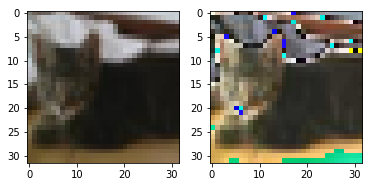

In [71]:
# plot original raw image against normalized image
plt.figure()
plt.subplot(121)
plt.imshow(np.asarray(raw_dataset[img_id][0]))
plt.subplot(122)
plt.imshow(test_sample[0].numpy()[0].transpose(1,2,0))

In [83]:
# run discriminator against image (real label = 1, fake label = 0)
# - test against real image first
test_input = Variable(test_sample[0])
if torch.cuda.is_available():
    test_input = test_input.cuda()
test_output = netD(test_input)
print('Real image score: ' + str(test_output.cpu().data.numpy()))

Real image score: [ 0.7928564]


In [90]:
# - test against fake image
test_noise = torch.FloatTensor(1, nz, 1, 1)
test_noisev = Variable(test_noise)
if torch.cuda.is_available():
    test_noisev = test_noisev.cuda()
test_fake_input = netG(test_noisev)
if torch.cuda.is_available():
    test_fake_input = test_fake_input.cuda()
test_fake_output = netD(test_fake_input)
print('Fake image score: ' + str(test_fake_output.cpu().data.numpy()))

Fake image score: [ 0.00231348]


In [40]:
# single pass though networks
netD.zero_grad()
real_cpu, _ = test_sample
batch_size = real_cpu.size(0)
if torch.cuda.is_available():
    real_cpu = real_cpu.cuda()
input.resize_as_(real_cpu).copy_(real_cpu)
label.resize_(batch_size).fill_(real_label)
inputv = Variable(input)
labelv = Variable(label)

In [43]:
output = netD(inputv)
errD_real = criterion(output, labelv)
errD_real.backward()
D_x = output.data.mean()

In [44]:
fake = netG(noisev)
fake.size()

torch.Size([64, 3, 32, 32])

In [53]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################                                                                                                                                                                                                              
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))                                                                                                                                                                             
        ###########################                                                                                                                                                                                                               
        # train with real                                                                                                                                                                                                                         
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake                                                                                                                                                                                                                         
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################                                                                                                                                                                                                              
        # (2) Update G network: maximize log(D(G(z)))                                                                                                                                                                                             
        ###########################                                                                                                                                                                                                               
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost                                                                                                                                                     
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

    # do checkpointing                                                                                                                                                                                                                            
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/25][0/782] Loss_D: 0.3981 Loss_G: 3.8208 D(x): 0.8814 D(G(z)): 0.2036 / 0.0360
[0/25][1/782] Loss_D: 0.4231 Loss_G: 3.4115 D(x): 0.7761 D(G(z)): 0.0783 / 0.0502
[0/25][2/782] Loss_D: 0.3050 Loss_G: 3.3575 D(x): 0.8888 D(G(z)): 0.1477 / 0.0503
[0/25][3/782] Loss_D: 0.4017 Loss_G: 3.5887 D(x): 0.8820 D(G(z)): 0.2176 / 0.0378
[0/25][4/782] Loss_D: 0.2948 Loss_G: 3.6663 D(x): 0.8393 D(G(z)): 0.0914 / 0.0430
[0/25][5/782] Loss_D: 0.3058 Loss_G: 3.1385 D(x): 0.8671 D(G(z)): 0.1339 / 0.0626
[0/25][6/782] Loss_D: 0.3627 Loss_G: 3.4838 D(x): 0.8978 D(G(z)): 0.1931 / 0.0453
[0/25][7/782] Loss_D: 0.4058 Loss_G: 3.5522 D(x): 0.8376 D(G(z)): 0.1545 / 0.0449
[0/25][8/782] Loss_D: 0.5472 Loss_G: 3.2254 D(x): 0.7831 D(G(z)): 0.1883 / 0.0656
[0/25][9/782] Loss_D: 0.5217 Loss_G: 3.5061 D(x): 0.8138 D(G(z)): 0.2212 / 0.0506
[0/25][10/782] Loss_D: 0.5038 Loss_G: 3.7249 D(x): 0.7894 D(G(z)): 0.1714 / 0.0410
[0/25][11/782] Loss_D: 0.6740 Loss_G: 3.5736 D(x): 0.7698 D(G(z)): 0.2504 / 0.0435
[0/25][12/782]

[0/25][101/782] Loss_D: 0.3249 Loss_G: 3.2750 D(x): 0.8907 D(G(z)): 0.1545 / 0.0605
[0/25][102/782] Loss_D: 0.3218 Loss_G: 3.6165 D(x): 0.8917 D(G(z)): 0.1623 / 0.0417
[0/25][103/782] Loss_D: 0.5221 Loss_G: 2.7946 D(x): 0.7798 D(G(z)): 0.1496 / 0.1034
[0/25][104/782] Loss_D: 0.7071 Loss_G: 4.2527 D(x): 0.8379 D(G(z)): 0.3180 / 0.0345
[0/25][105/782] Loss_D: 0.7039 Loss_G: 2.7903 D(x): 0.6597 D(G(z)): 0.1213 / 0.1029
[0/25][106/782] Loss_D: 0.6913 Loss_G: 4.6688 D(x): 0.8572 D(G(z)): 0.3300 / 0.0168
[0/25][107/782] Loss_D: 1.1144 Loss_G: 1.3732 D(x): 0.4592 D(G(z)): 0.0574 / 0.3471
[0/25][108/782] Loss_D: 1.3635 Loss_G: 6.1448 D(x): 0.9491 D(G(z)): 0.6485 / 0.0046
[0/25][109/782] Loss_D: 1.4829 Loss_G: 1.6365 D(x): 0.3426 D(G(z)): 0.0161 / 0.2773
[0/25][110/782] Loss_D: 0.7593 Loss_G: 4.5449 D(x): 0.9708 D(G(z)): 0.4333 / 0.0228
[0/25][111/782] Loss_D: 0.3111 Loss_G: 4.2218 D(x): 0.8065 D(G(z)): 0.0493 / 0.0303
[0/25][112/782] Loss_D: 0.2617 Loss_G: 3.5237 D(x): 0.8779 D(G(z)): 0.0992 /

[0/25][200/782] Loss_D: 0.3705 Loss_G: 3.8150 D(x): 0.9229 D(G(z)): 0.2185 / 0.0352
[0/25][201/782] Loss_D: 0.2038 Loss_G: 3.8007 D(x): 0.8945 D(G(z)): 0.0763 / 0.0335
[0/25][202/782] Loss_D: 0.3416 Loss_G: 3.2205 D(x): 0.8300 D(G(z)): 0.0973 / 0.0618
[0/25][203/782] Loss_D: 0.2351 Loss_G: 3.4126 D(x): 0.9118 D(G(z)): 0.1185 / 0.0464
[0/25][204/782] Loss_D: 0.4233 Loss_G: 3.7911 D(x): 0.8687 D(G(z)): 0.2049 / 0.0354
[0/25][205/782] Loss_D: 0.3584 Loss_G: 3.3906 D(x): 0.8452 D(G(z)): 0.1423 / 0.0465
[0/25][206/782] Loss_D: 0.3190 Loss_G: 3.0928 D(x): 0.8379 D(G(z)): 0.1125 / 0.0554
[0/25][207/782] Loss_D: 0.3612 Loss_G: 3.4327 D(x): 0.8733 D(G(z)): 0.1770 / 0.0457
[0/25][208/782] Loss_D: 0.4601 Loss_G: 3.3086 D(x): 0.8015 D(G(z)): 0.1639 / 0.0461
[0/25][209/782] Loss_D: 0.5787 Loss_G: 3.0566 D(x): 0.7296 D(G(z)): 0.1742 / 0.0569
[0/25][210/782] Loss_D: 0.4784 Loss_G: 2.8623 D(x): 0.7405 D(G(z)): 0.1240 / 0.0795
[0/25][211/782] Loss_D: 0.4263 Loss_G: 4.3496 D(x): 0.9087 D(G(z)): 0.2504 /

[0/25][304/782] Loss_D: 1.0273 Loss_G: 3.9062 D(x): 0.8268 D(G(z)): 0.4782 / 0.0355
[0/25][305/782] Loss_D: 0.6458 Loss_G: 3.0812 D(x): 0.6728 D(G(z)): 0.1095 / 0.1176
[0/25][306/782] Loss_D: 0.9927 Loss_G: 1.4626 D(x): 0.6105 D(G(z)): 0.2232 / 0.3079
[0/25][307/782] Loss_D: 1.0934 Loss_G: 3.4911 D(x): 0.7919 D(G(z)): 0.4756 / 0.0521
[0/25][308/782] Loss_D: 1.0140 Loss_G: 2.1149 D(x): 0.5458 D(G(z)): 0.1794 / 0.1673
[0/25][309/782] Loss_D: 0.8348 Loss_G: 6.9646 D(x): 0.9231 D(G(z)): 0.4687 / 0.0016
[0/25][310/782] Loss_D: 2.0492 Loss_G: 2.9467 D(x): 0.2305 D(G(z)): 0.0061 / 0.0881
[0/25][311/782] Loss_D: 0.4254 Loss_G: 1.3549 D(x): 0.8599 D(G(z)): 0.2138 / 0.3024
[0/25][312/782] Loss_D: 1.2916 Loss_G: 4.7408 D(x): 0.9467 D(G(z)): 0.6316 / 0.0143
[0/25][313/782] Loss_D: 0.4457 Loss_G: 4.5810 D(x): 0.7313 D(G(z)): 0.0526 / 0.0194
[0/25][314/782] Loss_D: 0.7027 Loss_G: 1.6606 D(x): 0.6056 D(G(z)): 0.0634 / 0.2461
[0/25][315/782] Loss_D: 0.7813 Loss_G: 3.2024 D(x): 0.8806 D(G(z)): 0.4076 /

[0/25][410/782] Loss_D: 0.4292 Loss_G: 2.7991 D(x): 0.8398 D(G(z)): 0.1998 / 0.0816
[0/25][411/782] Loss_D: 0.4374 Loss_G: 2.9674 D(x): 0.8164 D(G(z)): 0.1779 / 0.0748
[0/25][412/782] Loss_D: 0.5720 Loss_G: 2.3172 D(x): 0.7124 D(G(z)): 0.1705 / 0.1333
[0/25][413/782] Loss_D: 0.5079 Loss_G: 3.2397 D(x): 0.8895 D(G(z)): 0.2844 / 0.0514
[0/25][414/782] Loss_D: 0.5512 Loss_G: 2.9062 D(x): 0.7619 D(G(z)): 0.1706 / 0.0848
[0/25][415/782] Loss_D: 0.4278 Loss_G: 3.0967 D(x): 0.8240 D(G(z)): 0.1815 / 0.0596
[0/25][416/782] Loss_D: 0.3784 Loss_G: 2.7902 D(x): 0.8315 D(G(z)): 0.1522 / 0.0827
[0/25][417/782] Loss_D: 0.4853 Loss_G: 3.6582 D(x): 0.8827 D(G(z)): 0.2681 / 0.0370
[0/25][418/782] Loss_D: 0.7326 Loss_G: 1.8840 D(x): 0.6026 D(G(z)): 0.1020 / 0.2040
[0/25][419/782] Loss_D: 0.4100 Loss_G: 2.4853 D(x): 0.8534 D(G(z)): 0.1906 / 0.1106
[0/25][420/782] Loss_D: 0.4710 Loss_G: 3.8249 D(x): 0.8885 D(G(z)): 0.2719 / 0.0284
[0/25][421/782] Loss_D: 0.4399 Loss_G: 2.8293 D(x): 0.7249 D(G(z)): 0.0669 /

[0/25][516/782] Loss_D: 0.5847 Loss_G: 2.3480 D(x): 0.6757 D(G(z)): 0.1011 / 0.1334
[0/25][517/782] Loss_D: 0.5912 Loss_G: 1.9497 D(x): 0.7598 D(G(z)): 0.2065 / 0.1893
[0/25][518/782] Loss_D: 0.5638 Loss_G: 3.7235 D(x): 0.8937 D(G(z)): 0.3323 / 0.0419
[0/25][519/782] Loss_D: 0.7269 Loss_G: 2.6876 D(x): 0.6760 D(G(z)): 0.1672 / 0.1154
[0/25][520/782] Loss_D: 0.3987 Loss_G: 3.0939 D(x): 0.8731 D(G(z)): 0.2017 / 0.0657
[0/25][521/782] Loss_D: 0.4784 Loss_G: 2.9192 D(x): 0.8228 D(G(z)): 0.2097 / 0.0810
[0/25][522/782] Loss_D: 0.6876 Loss_G: 1.9726 D(x): 0.6704 D(G(z)): 0.1852 / 0.2022
[0/25][523/782] Loss_D: 0.4260 Loss_G: 3.1730 D(x): 0.8724 D(G(z)): 0.2232 / 0.0632
[0/25][524/782] Loss_D: 0.4084 Loss_G: 3.0895 D(x): 0.8202 D(G(z)): 0.1496 / 0.0683
[0/25][525/782] Loss_D: 0.4811 Loss_G: 2.6050 D(x): 0.7833 D(G(z)): 0.1714 / 0.1145
[0/25][526/782] Loss_D: 0.5463 Loss_G: 2.4029 D(x): 0.7828 D(G(z)): 0.2166 / 0.1214
[0/25][527/782] Loss_D: 0.4701 Loss_G: 3.7164 D(x): 0.8859 D(G(z)): 0.2549 /

[0/25][622/782] Loss_D: 0.3450 Loss_G: 2.7942 D(x): 0.8588 D(G(z)): 0.1410 / 0.0860
[0/25][623/782] Loss_D: 0.4630 Loss_G: 2.9573 D(x): 0.8448 D(G(z)): 0.2182 / 0.0785
[0/25][624/782] Loss_D: 0.4998 Loss_G: 2.5234 D(x): 0.7577 D(G(z)): 0.1535 / 0.1041
[0/25][625/782] Loss_D: 0.3879 Loss_G: 2.4597 D(x): 0.8542 D(G(z)): 0.1716 / 0.1134
[0/25][626/782] Loss_D: 0.6073 Loss_G: 2.9112 D(x): 0.7410 D(G(z)): 0.2256 / 0.0729
[0/25][627/782] Loss_D: 0.5264 Loss_G: 1.7092 D(x): 0.7039 D(G(z)): 0.1218 / 0.2176
[0/25][628/782] Loss_D: 0.5943 Loss_G: 3.1009 D(x): 0.8880 D(G(z)): 0.3488 / 0.0576
[0/25][629/782] Loss_D: 0.5165 Loss_G: 2.3053 D(x): 0.7014 D(G(z)): 0.1020 / 0.1413
[0/25][630/782] Loss_D: 0.4853 Loss_G: 2.9699 D(x): 0.8630 D(G(z)): 0.2470 / 0.0689
[0/25][631/782] Loss_D: 0.4174 Loss_G: 2.9299 D(x): 0.8246 D(G(z)): 0.1669 / 0.0739
[0/25][632/782] Loss_D: 0.4586 Loss_G: 2.1546 D(x): 0.7630 D(G(z)): 0.1268 / 0.1507
[0/25][633/782] Loss_D: 0.4721 Loss_G: 2.9040 D(x): 0.8466 D(G(z)): 0.2297 /

[0/25][728/782] Loss_D: 0.4738 Loss_G: 3.1585 D(x): 0.8654 D(G(z)): 0.2449 / 0.0547
[0/25][729/782] Loss_D: 0.2623 Loss_G: 3.1298 D(x): 0.8505 D(G(z)): 0.0832 / 0.0629
[0/25][730/782] Loss_D: 0.2721 Loss_G: 2.7208 D(x): 0.8632 D(G(z)): 0.1010 / 0.0956
[0/25][731/782] Loss_D: 0.3367 Loss_G: 2.6225 D(x): 0.8804 D(G(z)): 0.1669 / 0.0957
[0/25][732/782] Loss_D: 0.3916 Loss_G: 3.0120 D(x): 0.9213 D(G(z)): 0.2476 / 0.0628
[0/25][733/782] Loss_D: 0.5285 Loss_G: 2.4169 D(x): 0.6755 D(G(z)): 0.0783 / 0.1164
[0/25][734/782] Loss_D: 0.4915 Loss_G: 1.9858 D(x): 0.7980 D(G(z)): 0.1917 / 0.1829
[0/25][735/782] Loss_D: 0.5644 Loss_G: 2.6835 D(x): 0.8973 D(G(z)): 0.3379 / 0.0877
[0/25][736/782] Loss_D: 0.3653 Loss_G: 2.9632 D(x): 0.8348 D(G(z)): 0.1533 / 0.0642
[0/25][737/782] Loss_D: 0.3921 Loss_G: 2.5127 D(x): 0.7916 D(G(z)): 0.1275 / 0.1032
[0/25][738/782] Loss_D: 0.5375 Loss_G: 2.4004 D(x): 0.8168 D(G(z)): 0.2536 / 0.1133
[0/25][739/782] Loss_D: 0.5657 Loss_G: 2.1467 D(x): 0.7217 D(G(z)): 0.1745 /

[1/25][52/782] Loss_D: 0.4603 Loss_G: 2.9511 D(x): 0.9215 D(G(z)): 0.2844 / 0.0672
[1/25][53/782] Loss_D: 0.4476 Loss_G: 2.6629 D(x): 0.7725 D(G(z)): 0.1445 / 0.0831
[1/25][54/782] Loss_D: 0.5849 Loss_G: 1.8858 D(x): 0.7279 D(G(z)): 0.1875 / 0.1938
[1/25][55/782] Loss_D: 0.7180 Loss_G: 2.9836 D(x): 0.8235 D(G(z)): 0.3310 / 0.0864
[1/25][56/782] Loss_D: 0.5107 Loss_G: 2.7206 D(x): 0.7725 D(G(z)): 0.1614 / 0.0883
[1/25][57/782] Loss_D: 0.5529 Loss_G: 2.5444 D(x): 0.7577 D(G(z)): 0.1912 / 0.1070
[1/25][58/782] Loss_D: 0.7572 Loss_G: 2.7466 D(x): 0.8073 D(G(z)): 0.3619 / 0.0819
[1/25][59/782] Loss_D: 0.5657 Loss_G: 2.1168 D(x): 0.6822 D(G(z)): 0.1139 / 0.1683
[1/25][60/782] Loss_D: 0.5256 Loss_G: 2.3794 D(x): 0.8066 D(G(z)): 0.2357 / 0.1229
[1/25][61/782] Loss_D: 0.4243 Loss_G: 3.3254 D(x): 0.8703 D(G(z)): 0.2231 / 0.0503
[1/25][62/782] Loss_D: 0.6084 Loss_G: 1.6283 D(x): 0.6853 D(G(z)): 0.1510 / 0.2411
[1/25][63/782] Loss_D: 0.5601 Loss_G: 2.9121 D(x): 0.8882 D(G(z)): 0.3207 / 0.0717
[1/2

[1/25][158/782] Loss_D: 1.0214 Loss_G: 0.5176 D(x): 0.4452 D(G(z)): 0.0447 / 0.6317
[1/25][159/782] Loss_D: 1.7615 Loss_G: 6.1211 D(x): 0.9658 D(G(z)): 0.7705 / 0.0036
[1/25][160/782] Loss_D: 1.9928 Loss_G: 1.9174 D(x): 0.2168 D(G(z)): 0.0054 / 0.2146
[1/25][161/782] Loss_D: 1.2029 Loss_G: 4.0074 D(x): 0.8481 D(G(z)): 0.5599 / 0.0321
[1/25][162/782] Loss_D: 0.7996 Loss_G: 2.2734 D(x): 0.5624 D(G(z)): 0.0508 / 0.1545
[1/25][163/782] Loss_D: 0.6108 Loss_G: 2.1073 D(x): 0.7851 D(G(z)): 0.2340 / 0.1837
[1/25][164/782] Loss_D: 0.7092 Loss_G: 3.2125 D(x): 0.8547 D(G(z)): 0.3328 / 0.0655
[1/25][165/782] Loss_D: 0.4726 Loss_G: 2.8839 D(x): 0.7523 D(G(z)): 0.1223 / 0.0905
[1/25][166/782] Loss_D: 0.4401 Loss_G: 2.3452 D(x): 0.7866 D(G(z)): 0.1486 / 0.1309
[1/25][167/782] Loss_D: 0.4531 Loss_G: 3.0790 D(x): 0.8912 D(G(z)): 0.2526 / 0.0664
[1/25][168/782] Loss_D: 0.4709 Loss_G: 2.7051 D(x): 0.7614 D(G(z)): 0.1254 / 0.0943
[1/25][169/782] Loss_D: 0.4650 Loss_G: 2.2589 D(x): 0.7877 D(G(z)): 0.1681 /

[1/25][264/782] Loss_D: 0.3978 Loss_G: 3.3128 D(x): 0.8304 D(G(z)): 0.1636 / 0.0552
[1/25][265/782] Loss_D: 0.4699 Loss_G: 2.6488 D(x): 0.7921 D(G(z)): 0.1803 / 0.0923
[1/25][266/782] Loss_D: 0.2329 Loss_G: 2.9202 D(x): 0.8860 D(G(z)): 0.0957 / 0.0673
[1/25][267/782] Loss_D: 0.6116 Loss_G: 1.3307 D(x): 0.6980 D(G(z)): 0.1593 / 0.3279
[1/25][268/782] Loss_D: 0.7015 Loss_G: 3.9578 D(x): 0.9407 D(G(z)): 0.4281 / 0.0252
[1/25][269/782] Loss_D: 0.9001 Loss_G: 1.2375 D(x): 0.5179 D(G(z)): 0.1004 / 0.3528
[1/25][270/782] Loss_D: 0.8179 Loss_G: 3.9831 D(x): 0.8946 D(G(z)): 0.4427 / 0.0261
[1/25][271/782] Loss_D: 1.1978 Loss_G: 0.3663 D(x): 0.3797 D(G(z)): 0.0419 / 0.7210
[1/25][272/782] Loss_D: 2.3729 Loss_G: 4.3015 D(x): 0.9869 D(G(z)): 0.8399 / 0.0279
[1/25][273/782] Loss_D: 0.9761 Loss_G: 0.3242 D(x): 0.5044 D(G(z)): 0.0627 / 0.7680
[1/25][274/782] Loss_D: 2.0492 Loss_G: 5.8938 D(x): 0.9766 D(G(z)): 0.7902 / 0.0060
[1/25][275/782] Loss_D: 2.3487 Loss_G: 2.1978 D(x): 0.1725 D(G(z)): 0.0073 /

[1/25][370/782] Loss_D: 0.4596 Loss_G: 1.7738 D(x): 0.7310 D(G(z)): 0.1109 / 0.2072
[1/25][371/782] Loss_D: 0.5468 Loss_G: 2.4379 D(x): 0.8396 D(G(z)): 0.2837 / 0.1068
[1/25][372/782] Loss_D: 0.3982 Loss_G: 2.6656 D(x): 0.8109 D(G(z)): 0.1404 / 0.0902
[1/25][373/782] Loss_D: 0.4174 Loss_G: 2.1971 D(x): 0.7986 D(G(z)): 0.1485 / 0.1427
[1/25][374/782] Loss_D: 0.3546 Loss_G: 2.4671 D(x): 0.8798 D(G(z)): 0.1854 / 0.1091
[1/25][375/782] Loss_D: 0.4325 Loss_G: 2.4451 D(x): 0.8141 D(G(z)): 0.1798 / 0.1081
[1/25][376/782] Loss_D: 0.3411 Loss_G: 2.5454 D(x): 0.8292 D(G(z)): 0.1220 / 0.1116
[1/25][377/782] Loss_D: 0.5195 Loss_G: 2.0340 D(x): 0.7708 D(G(z)): 0.1949 / 0.1581
[1/25][378/782] Loss_D: 0.4516 Loss_G: 2.6947 D(x): 0.8640 D(G(z)): 0.2423 / 0.0835
[1/25][379/782] Loss_D: 0.4148 Loss_G: 2.5724 D(x): 0.7994 D(G(z)): 0.1499 / 0.1023
[1/25][380/782] Loss_D: 0.6782 Loss_G: 1.3740 D(x): 0.6151 D(G(z)): 0.1075 / 0.3079
[1/25][381/782] Loss_D: 0.5839 Loss_G: 3.0008 D(x): 0.9397 D(G(z)): 0.3660 /

[1/25][476/782] Loss_D: 0.3225 Loss_G: 2.8973 D(x): 0.8533 D(G(z)): 0.1342 / 0.0689
[1/25][477/782] Loss_D: 0.5507 Loss_G: 2.1995 D(x): 0.7267 D(G(z)): 0.1671 / 0.1544
[1/25][478/782] Loss_D: 0.4503 Loss_G: 2.5635 D(x): 0.8314 D(G(z)): 0.2124 / 0.0996
[1/25][479/782] Loss_D: 0.5116 Loss_G: 2.6403 D(x): 0.7909 D(G(z)): 0.2057 / 0.0967
[1/25][480/782] Loss_D: 0.3347 Loss_G: 3.0862 D(x): 0.8537 D(G(z)): 0.1412 / 0.0664
[1/25][481/782] Loss_D: 0.4093 Loss_G: 2.3965 D(x): 0.7605 D(G(z)): 0.0966 / 0.1349
[1/25][482/782] Loss_D: 0.5715 Loss_G: 3.1761 D(x): 0.8761 D(G(z)): 0.3147 / 0.0602
[1/25][483/782] Loss_D: 0.3635 Loss_G: 3.1698 D(x): 0.8310 D(G(z)): 0.1365 / 0.0559
[1/25][484/782] Loss_D: 0.4126 Loss_G: 2.0975 D(x): 0.7659 D(G(z)): 0.0950 / 0.1602
[1/25][485/782] Loss_D: 0.3793 Loss_G: 3.2722 D(x): 0.8687 D(G(z)): 0.1935 / 0.0515
[1/25][486/782] Loss_D: 0.2608 Loss_G: 2.8851 D(x): 0.8853 D(G(z)): 0.1148 / 0.0736
[1/25][487/782] Loss_D: 0.3412 Loss_G: 3.2997 D(x): 0.8834 D(G(z)): 0.1746 /

[1/25][582/782] Loss_D: 0.2760 Loss_G: 2.4927 D(x): 0.8661 D(G(z)): 0.1060 / 0.1066
[1/25][583/782] Loss_D: 0.3319 Loss_G: 2.6548 D(x): 0.9101 D(G(z)): 0.1948 / 0.0911
[1/25][584/782] Loss_D: 0.3342 Loss_G: 3.2401 D(x): 0.9186 D(G(z)): 0.2044 / 0.0496
[1/25][585/782] Loss_D: 0.3774 Loss_G: 3.0239 D(x): 0.8300 D(G(z)): 0.1490 / 0.0728
[1/25][586/782] Loss_D: 0.3761 Loss_G: 2.3684 D(x): 0.7688 D(G(z)): 0.0823 / 0.1205
[1/25][587/782] Loss_D: 0.4644 Loss_G: 1.9796 D(x): 0.7974 D(G(z)): 0.1822 / 0.1645
[1/25][588/782] Loss_D: 0.4396 Loss_G: 2.8923 D(x): 0.8873 D(G(z)): 0.2394 / 0.0771
[1/25][589/782] Loss_D: 0.5733 Loss_G: 2.4107 D(x): 0.7106 D(G(z)): 0.1656 / 0.1198
[1/25][590/782] Loss_D: 0.3848 Loss_G: 2.4957 D(x): 0.8671 D(G(z)): 0.1885 / 0.1120
[1/25][591/782] Loss_D: 0.2943 Loss_G: 3.0765 D(x): 0.8757 D(G(z)): 0.1318 / 0.0617
[1/25][592/782] Loss_D: 0.2326 Loss_G: 3.0703 D(x): 0.8868 D(G(z)): 0.0981 / 0.0648
[1/25][593/782] Loss_D: 0.2770 Loss_G: 3.0599 D(x): 0.9024 D(G(z)): 0.1407 /

[1/25][688/782] Loss_D: 0.5817 Loss_G: 2.4735 D(x): 0.6928 D(G(z)): 0.1354 / 0.1169
[1/25][689/782] Loss_D: 0.4877 Loss_G: 2.8544 D(x): 0.8753 D(G(z)): 0.2672 / 0.0803
[1/25][690/782] Loss_D: 0.4888 Loss_G: 2.6684 D(x): 0.7522 D(G(z)): 0.1314 / 0.0960
[1/25][691/782] Loss_D: 0.3230 Loss_G: 2.9255 D(x): 0.8858 D(G(z)): 0.1682 / 0.0723
[1/25][692/782] Loss_D: 0.4641 Loss_G: 2.5938 D(x): 0.7920 D(G(z)): 0.1603 / 0.1038
[1/25][693/782] Loss_D: 0.4981 Loss_G: 2.9380 D(x): 0.8169 D(G(z)): 0.2016 / 0.0719
[1/25][694/782] Loss_D: 0.3620 Loss_G: 2.9813 D(x): 0.8270 D(G(z)): 0.1312 / 0.0699
[1/25][695/782] Loss_D: 0.3909 Loss_G: 2.6481 D(x): 0.8191 D(G(z)): 0.1372 / 0.1004
[1/25][696/782] Loss_D: 0.5104 Loss_G: 2.7649 D(x): 0.8519 D(G(z)): 0.2467 / 0.0852
[1/25][697/782] Loss_D: 0.3816 Loss_G: 2.7972 D(x): 0.8149 D(G(z)): 0.1185 / 0.0822
[1/25][698/782] Loss_D: 0.3004 Loss_G: 3.3777 D(x): 0.9216 D(G(z)): 0.1767 / 0.0509
[1/25][699/782] Loss_D: 0.3671 Loss_G: 2.8993 D(x): 0.7998 D(G(z)): 0.1054 /

[2/25][7/782] Loss_D: 0.8798 Loss_G: 2.5961 D(x): 0.5137 D(G(z)): 0.0848 / 0.1310
[2/25][8/782] Loss_D: 0.5372 Loss_G: 2.5604 D(x): 0.8126 D(G(z)): 0.2386 / 0.1058
[2/25][9/782] Loss_D: 0.3004 Loss_G: 4.6731 D(x): 0.9586 D(G(z)): 0.2111 / 0.0135
[2/25][10/782] Loss_D: 0.4448 Loss_G: 3.6260 D(x): 0.7278 D(G(z)): 0.0548 / 0.0458
[2/25][11/782] Loss_D: 0.2409 Loss_G: 3.0452 D(x): 0.8580 D(G(z)): 0.0653 / 0.0771
[2/25][12/782] Loss_D: 0.2028 Loss_G: 3.7529 D(x): 0.9785 D(G(z)): 0.1536 / 0.0364
[2/25][13/782] Loss_D: 0.2116 Loss_G: 4.1765 D(x): 0.9389 D(G(z)): 0.1285 / 0.0236
[2/25][14/782] Loss_D: 0.1880 Loss_G: 4.1241 D(x): 0.9227 D(G(z)): 0.0859 / 0.0319
[2/25][15/782] Loss_D: 0.2129 Loss_G: 3.6365 D(x): 0.8854 D(G(z)): 0.0742 / 0.0405
[2/25][16/782] Loss_D: 0.2298 Loss_G: 2.9465 D(x): 0.8607 D(G(z)): 0.0638 / 0.0734
[2/25][17/782] Loss_D: 0.5008 Loss_G: 3.8864 D(x): 0.9373 D(G(z)): 0.2970 / 0.0311
[2/25][18/782] Loss_D: 0.4421 Loss_G: 2.8840 D(x): 0.7448 D(G(z)): 0.0797 / 0.0863
[2/25][

[2/25][113/782] Loss_D: 0.7504 Loss_G: 1.8378 D(x): 0.5628 D(G(z)): 0.0887 / 0.2137
[2/25][114/782] Loss_D: 0.4064 Loss_G: 2.4766 D(x): 0.8878 D(G(z)): 0.2240 / 0.1191
[2/25][115/782] Loss_D: 0.4848 Loss_G: 3.1285 D(x): 0.8868 D(G(z)): 0.2632 / 0.0613
[2/25][116/782] Loss_D: 0.3867 Loss_G: 2.6271 D(x): 0.7734 D(G(z)): 0.0961 / 0.1038
[2/25][117/782] Loss_D: 0.3671 Loss_G: 2.3935 D(x): 0.8394 D(G(z)): 0.1442 / 0.1255
[2/25][118/782] Loss_D: 0.3671 Loss_G: 2.7429 D(x): 0.8708 D(G(z)): 0.1834 / 0.0888
[2/25][119/782] Loss_D: 0.4080 Loss_G: 2.2740 D(x): 0.7865 D(G(z)): 0.1317 / 0.1337
[2/25][120/782] Loss_D: 0.4506 Loss_G: 2.8367 D(x): 0.8671 D(G(z)): 0.2360 / 0.0786
[2/25][121/782] Loss_D: 0.4398 Loss_G: 2.2002 D(x): 0.7762 D(G(z)): 0.1254 / 0.1451
[2/25][122/782] Loss_D: 0.6335 Loss_G: 2.7769 D(x): 0.8390 D(G(z)): 0.3171 / 0.0864
[2/25][123/782] Loss_D: 0.3287 Loss_G: 2.7683 D(x): 0.8290 D(G(z)): 0.1108 / 0.0887
[2/25][124/782] Loss_D: 0.3753 Loss_G: 2.3270 D(x): 0.8357 D(G(z)): 0.1471 /

[2/25][219/782] Loss_D: 0.5994 Loss_G: 2.1673 D(x): 0.7071 D(G(z)): 0.1782 / 0.1472
[2/25][220/782] Loss_D: 0.5737 Loss_G: 2.0405 D(x): 0.7936 D(G(z)): 0.2409 / 0.1606
[2/25][221/782] Loss_D: 0.4949 Loss_G: 2.8914 D(x): 0.8435 D(G(z)): 0.2494 / 0.0774
[2/25][222/782] Loss_D: 0.5261 Loss_G: 2.4296 D(x): 0.7355 D(G(z)): 0.1522 / 0.1182
[2/25][223/782] Loss_D: 0.4268 Loss_G: 1.9727 D(x): 0.7593 D(G(z)): 0.1110 / 0.1658
[2/25][224/782] Loss_D: 0.6450 Loss_G: 2.7054 D(x): 0.8550 D(G(z)): 0.3480 / 0.0860
[2/25][225/782] Loss_D: 0.6199 Loss_G: 1.6493 D(x): 0.6526 D(G(z)): 0.1252 / 0.2316
[2/25][226/782] Loss_D: 0.6400 Loss_G: 3.4425 D(x): 0.9170 D(G(z)): 0.3739 / 0.0497
[2/25][227/782] Loss_D: 0.5265 Loss_G: 2.5794 D(x): 0.7164 D(G(z)): 0.1280 / 0.1158
[2/25][228/782] Loss_D: 0.5525 Loss_G: 2.4882 D(x): 0.8040 D(G(z)): 0.2376 / 0.1093
[2/25][229/782] Loss_D: 0.6083 Loss_G: 2.1343 D(x): 0.7227 D(G(z)): 0.1926 / 0.1586
[2/25][230/782] Loss_D: 0.4860 Loss_G: 2.3687 D(x): 0.8197 D(G(z)): 0.2001 /

[2/25][325/782] Loss_D: 0.4780 Loss_G: 3.0000 D(x): 0.9118 D(G(z)): 0.2830 / 0.0677
[2/25][326/782] Loss_D: 0.8017 Loss_G: 1.2571 D(x): 0.5733 D(G(z)): 0.1217 / 0.3409
[2/25][327/782] Loss_D: 0.5062 Loss_G: 2.8936 D(x): 0.9394 D(G(z)): 0.3265 / 0.0788
[2/25][328/782] Loss_D: 0.4674 Loss_G: 3.1728 D(x): 0.8144 D(G(z)): 0.1909 / 0.0544
[2/25][329/782] Loss_D: 0.4254 Loss_G: 1.8267 D(x): 0.7404 D(G(z)): 0.0739 / 0.2062
[2/25][330/782] Loss_D: 0.4108 Loss_G: 2.7206 D(x): 0.9103 D(G(z)): 0.2466 / 0.0901
[2/25][331/782] Loss_D: 0.3510 Loss_G: 3.0970 D(x): 0.8642 D(G(z)): 0.1670 / 0.0608
[2/25][332/782] Loss_D: 0.2747 Loss_G: 3.0121 D(x): 0.8762 D(G(z)): 0.1021 / 0.0700
[2/25][333/782] Loss_D: 0.3276 Loss_G: 2.8501 D(x): 0.8840 D(G(z)): 0.1563 / 0.0886
[2/25][334/782] Loss_D: 0.3290 Loss_G: 2.4553 D(x): 0.8248 D(G(z)): 0.0903 / 0.1162
[2/25][335/782] Loss_D: 0.8961 Loss_G: 1.0849 D(x): 0.6222 D(G(z)): 0.2712 / 0.3871
[2/25][336/782] Loss_D: 0.6764 Loss_G: 3.3056 D(x): 0.8451 D(G(z)): 0.3621 /

[2/25][431/782] Loss_D: 0.4692 Loss_G: 1.9904 D(x): 0.7594 D(G(z)): 0.1347 / 0.1735
[2/25][432/782] Loss_D: 0.6731 Loss_G: 3.1217 D(x): 0.8529 D(G(z)): 0.3484 / 0.0613
[2/25][433/782] Loss_D: 0.7161 Loss_G: 1.7130 D(x): 0.5755 D(G(z)): 0.0760 / 0.2235
[2/25][434/782] Loss_D: 0.5472 Loss_G: 2.4115 D(x): 0.8451 D(G(z)): 0.2834 / 0.1214
[2/25][435/782] Loss_D: 0.5705 Loss_G: 2.9295 D(x): 0.8215 D(G(z)): 0.2538 / 0.0788
[2/25][436/782] Loss_D: 0.5677 Loss_G: 1.7493 D(x): 0.7050 D(G(z)): 0.1612 / 0.2091
[2/25][437/782] Loss_D: 0.4488 Loss_G: 2.8493 D(x): 0.8910 D(G(z)): 0.2404 / 0.0874
[2/25][438/782] Loss_D: 0.4294 Loss_G: 2.8013 D(x): 0.7981 D(G(z)): 0.1563 / 0.0872
[2/25][439/782] Loss_D: 0.3887 Loss_G: 2.1961 D(x): 0.8048 D(G(z)): 0.1305 / 0.1474
[2/25][440/782] Loss_D: 0.5019 Loss_G: 2.7679 D(x): 0.8317 D(G(z)): 0.2476 / 0.0882
[2/25][441/782] Loss_D: 0.3856 Loss_G: 2.6976 D(x): 0.8260 D(G(z)): 0.1520 / 0.0954
[2/25][442/782] Loss_D: 0.4970 Loss_G: 2.0683 D(x): 0.7617 D(G(z)): 0.1516 /

[2/25][537/782] Loss_D: 0.4077 Loss_G: 2.5830 D(x): 0.8020 D(G(z)): 0.1303 / 0.0997
[2/25][538/782] Loss_D: 0.4275 Loss_G: 2.6460 D(x): 0.8493 D(G(z)): 0.1966 / 0.1030
[2/25][539/782] Loss_D: 0.5408 Loss_G: 1.8642 D(x): 0.7122 D(G(z)): 0.1351 / 0.2049
[2/25][540/782] Loss_D: 0.6240 Loss_G: 3.0407 D(x): 0.8867 D(G(z)): 0.3351 / 0.0707
[2/25][541/782] Loss_D: 0.5127 Loss_G: 2.3288 D(x): 0.7298 D(G(z)): 0.1154 / 0.1327
[2/25][542/782] Loss_D: 0.5676 Loss_G: 2.0452 D(x): 0.7605 D(G(z)): 0.2012 / 0.1998
[2/25][543/782] Loss_D: 0.6534 Loss_G: 2.9592 D(x): 0.7961 D(G(z)): 0.2775 / 0.0769
[2/25][544/782] Loss_D: 0.5710 Loss_G: 1.8317 D(x): 0.6990 D(G(z)): 0.1398 / 0.2017
[2/25][545/782] Loss_D: 0.4612 Loss_G: 2.3787 D(x): 0.8518 D(G(z)): 0.2317 / 0.1225
[2/25][546/782] Loss_D: 0.4902 Loss_G: 2.4899 D(x): 0.8143 D(G(z)): 0.2135 / 0.1075
[2/25][547/782] Loss_D: 0.6351 Loss_G: 1.9425 D(x): 0.7005 D(G(z)): 0.1722 / 0.2028
[2/25][548/782] Loss_D: 0.4345 Loss_G: 2.6347 D(x): 0.8727 D(G(z)): 0.2281 /

[2/25][643/782] Loss_D: 0.3635 Loss_G: 2.4014 D(x): 0.8342 D(G(z)): 0.1448 / 0.1148
[2/25][644/782] Loss_D: 0.4467 Loss_G: 2.9328 D(x): 0.8634 D(G(z)): 0.2370 / 0.0695
[2/25][645/782] Loss_D: 0.3617 Loss_G: 2.6066 D(x): 0.7809 D(G(z)): 0.0765 / 0.0956
[2/25][646/782] Loss_D: 0.2861 Loss_G: 2.3936 D(x): 0.8742 D(G(z)): 0.1253 / 0.1215
[2/25][647/782] Loss_D: 0.5344 Loss_G: 2.2745 D(x): 0.8123 D(G(z)): 0.2339 / 0.1295
[2/25][648/782] Loss_D: 0.4065 Loss_G: 3.0098 D(x): 0.8809 D(G(z)): 0.2197 / 0.0683
[2/25][649/782] Loss_D: 0.5103 Loss_G: 1.8734 D(x): 0.6798 D(G(z)): 0.0832 / 0.1933
[2/25][650/782] Loss_D: 0.6739 Loss_G: 1.4085 D(x): 0.7212 D(G(z)): 0.2392 / 0.2986
[2/25][651/782] Loss_D: 0.6134 Loss_G: 3.0818 D(x): 0.8979 D(G(z)): 0.3574 / 0.0636
[2/25][652/782] Loss_D: 0.5575 Loss_G: 2.2008 D(x): 0.6981 D(G(z)): 0.1342 / 0.1449
[2/25][653/782] Loss_D: 0.3097 Loss_G: 2.3918 D(x): 0.8682 D(G(z)): 0.1413 / 0.1235
[2/25][654/782] Loss_D: 0.4821 Loss_G: 2.2232 D(x): 0.8183 D(G(z)): 0.2142 /

[2/25][749/782] Loss_D: 0.5976 Loss_G: 2.6180 D(x): 0.7764 D(G(z)): 0.2292 / 0.1059
[2/25][750/782] Loss_D: 0.6828 Loss_G: 1.8478 D(x): 0.6598 D(G(z)): 0.1648 / 0.2064
[2/25][751/782] Loss_D: 0.6078 Loss_G: 2.1812 D(x): 0.8244 D(G(z)): 0.2857 / 0.1494
[2/25][752/782] Loss_D: 0.5446 Loss_G: 2.2806 D(x): 0.7695 D(G(z)): 0.2013 / 0.1401
[2/25][753/782] Loss_D: 0.5696 Loss_G: 2.3852 D(x): 0.7913 D(G(z)): 0.2396 / 0.1167
[2/25][754/782] Loss_D: 0.6552 Loss_G: 1.7912 D(x): 0.6816 D(G(z)): 0.1571 / 0.2092
[2/25][755/782] Loss_D: 0.6255 Loss_G: 2.4207 D(x): 0.8238 D(G(z)): 0.3043 / 0.1151
[2/25][756/782] Loss_D: 0.4552 Loss_G: 2.7444 D(x): 0.8558 D(G(z)): 0.2239 / 0.0854
[2/25][757/782] Loss_D: 0.4526 Loss_G: 2.1422 D(x): 0.7402 D(G(z)): 0.0952 / 0.1488
[2/25][758/782] Loss_D: 0.5034 Loss_G: 2.1657 D(x): 0.8292 D(G(z)): 0.2466 / 0.1424
[2/25][759/782] Loss_D: 0.5938 Loss_G: 2.2343 D(x): 0.7465 D(G(z)): 0.2081 / 0.1387
[2/25][760/782] Loss_D: 0.3653 Loss_G: 2.6599 D(x): 0.8972 D(G(z)): 0.2037 /

[3/25][70/782] Loss_D: 0.7678 Loss_G: 2.1793 D(x): 0.7098 D(G(z)): 0.2666 / 0.1525
[3/25][71/782] Loss_D: 0.4940 Loss_G: 2.2843 D(x): 0.8097 D(G(z)): 0.2088 / 0.1361
[3/25][72/782] Loss_D: 0.4400 Loss_G: 2.3848 D(x): 0.8313 D(G(z)): 0.1954 / 0.1206
[3/25][73/782] Loss_D: 0.3929 Loss_G: 2.1905 D(x): 0.8215 D(G(z)): 0.1463 / 0.1389
[3/25][74/782] Loss_D: 0.6221 Loss_G: 2.0733 D(x): 0.7568 D(G(z)): 0.2538 / 0.1516
[3/25][75/782] Loss_D: 0.4991 Loss_G: 2.6089 D(x): 0.8267 D(G(z)): 0.2332 / 0.0975
[3/25][76/782] Loss_D: 0.9497 Loss_G: 1.3960 D(x): 0.5523 D(G(z)): 0.2269 / 0.3010
[3/25][77/782] Loss_D: 0.6217 Loss_G: 2.8736 D(x): 0.9227 D(G(z)): 0.3833 / 0.0707
[3/25][78/782] Loss_D: 0.5275 Loss_G: 2.1839 D(x): 0.6930 D(G(z)): 0.1082 / 0.1453
[3/25][79/782] Loss_D: 0.6711 Loss_G: 2.0055 D(x): 0.7423 D(G(z)): 0.2533 / 0.1729
[3/25][80/782] Loss_D: 0.3711 Loss_G: 2.5737 D(x): 0.8961 D(G(z)): 0.2070 / 0.1034
[3/25][81/782] Loss_D: 0.3612 Loss_G: 2.9001 D(x): 0.8720 D(G(z)): 0.1761 / 0.0722
[3/2

[3/25][176/782] Loss_D: 0.5761 Loss_G: 2.2414 D(x): 0.6753 D(G(z)): 0.1082 / 0.1586
[3/25][177/782] Loss_D: 0.3260 Loss_G: 2.7205 D(x): 0.9268 D(G(z)): 0.2052 / 0.0915
[3/25][178/782] Loss_D: 0.4589 Loss_G: 2.4127 D(x): 0.7995 D(G(z)): 0.1807 / 0.1149
[3/25][179/782] Loss_D: 0.4142 Loss_G: 2.1844 D(x): 0.8064 D(G(z)): 0.1598 / 0.1361
[3/25][180/782] Loss_D: 0.3663 Loss_G: 2.3151 D(x): 0.8465 D(G(z)): 0.1616 / 0.1281
[3/25][181/782] Loss_D: 0.4949 Loss_G: 2.5114 D(x): 0.8133 D(G(z)): 0.2141 / 0.1107
[3/25][182/782] Loss_D: 0.4996 Loss_G: 2.2322 D(x): 0.7933 D(G(z)): 0.2112 / 0.1316
[3/25][183/782] Loss_D: 0.4211 Loss_G: 2.4839 D(x): 0.8568 D(G(z)): 0.2140 / 0.1023
[3/25][184/782] Loss_D: 0.5847 Loss_G: 2.2152 D(x): 0.7563 D(G(z)): 0.2233 / 0.1358
[3/25][185/782] Loss_D: 0.4024 Loss_G: 2.3425 D(x): 0.8225 D(G(z)): 0.1685 / 0.1249
[3/25][186/782] Loss_D: 0.7443 Loss_G: 1.3274 D(x): 0.6390 D(G(z)): 0.2041 / 0.3238
[3/25][187/782] Loss_D: 0.6053 Loss_G: 2.6377 D(x): 0.8605 D(G(z)): 0.3286 /

[3/25][282/782] Loss_D: 0.4662 Loss_G: 2.1527 D(x): 0.8058 D(G(z)): 0.1909 / 0.1540
[3/25][283/782] Loss_D: 0.7502 Loss_G: 1.7897 D(x): 0.7125 D(G(z)): 0.2736 / 0.2179
[3/25][284/782] Loss_D: 0.6260 Loss_G: 2.4906 D(x): 0.8346 D(G(z)): 0.3160 / 0.1090
[3/25][285/782] Loss_D: 0.7086 Loss_G: 1.7876 D(x): 0.6502 D(G(z)): 0.1933 / 0.2073
[3/25][286/782] Loss_D: 0.5419 Loss_G: 1.8483 D(x): 0.8062 D(G(z)): 0.2403 / 0.2048
[3/25][287/782] Loss_D: 0.5406 Loss_G: 2.4707 D(x): 0.8462 D(G(z)): 0.2817 / 0.1160
[3/25][288/782] Loss_D: 0.5495 Loss_G: 2.1792 D(x): 0.7507 D(G(z)): 0.1892 / 0.1468
[3/25][289/782] Loss_D: 0.4755 Loss_G: 2.0871 D(x): 0.8012 D(G(z)): 0.1919 / 0.1604
[3/25][290/782] Loss_D: 0.5470 Loss_G: 2.2363 D(x): 0.8019 D(G(z)): 0.2459 / 0.1376
[3/25][291/782] Loss_D: 0.5214 Loss_G: 2.2662 D(x): 0.7894 D(G(z)): 0.2150 / 0.1332
[3/25][292/782] Loss_D: 0.7366 Loss_G: 2.5965 D(x): 0.7777 D(G(z)): 0.3250 / 0.1036
[3/25][293/782] Loss_D: 0.7689 Loss_G: 1.5650 D(x): 0.5555 D(G(z)): 0.0928 /

[3/25][388/782] Loss_D: 0.3691 Loss_G: 3.2337 D(x): 0.8230 D(G(z)): 0.1380 / 0.0575
[3/25][389/782] Loss_D: 0.7483 Loss_G: 1.0388 D(x): 0.5777 D(G(z)): 0.0989 / 0.3948
[3/25][390/782] Loss_D: 0.7196 Loss_G: 2.8221 D(x): 0.8706 D(G(z)): 0.3978 / 0.0775
[3/25][391/782] Loss_D: 0.6258 Loss_G: 1.9765 D(x): 0.6716 D(G(z)): 0.1482 / 0.1717
[3/25][392/782] Loss_D: 0.4716 Loss_G: 2.3793 D(x): 0.8480 D(G(z)): 0.2403 / 0.1132
[3/25][393/782] Loss_D: 0.5475 Loss_G: 2.9333 D(x): 0.8236 D(G(z)): 0.2538 / 0.0686
[3/25][394/782] Loss_D: 0.5237 Loss_G: 1.6970 D(x): 0.6740 D(G(z)): 0.0843 / 0.2183
[3/25][395/782] Loss_D: 0.5546 Loss_G: 2.9192 D(x): 0.9281 D(G(z)): 0.3457 / 0.0717
[3/25][396/782] Loss_D: 0.5157 Loss_G: 2.1498 D(x): 0.7128 D(G(z)): 0.1257 / 0.1495
[3/25][397/782] Loss_D: 0.6387 Loss_G: 2.0211 D(x): 0.7483 D(G(z)): 0.2478 / 0.1665
[3/25][398/782] Loss_D: 0.4829 Loss_G: 2.2119 D(x): 0.7798 D(G(z)): 0.1696 / 0.1379
[3/25][399/782] Loss_D: 0.4717 Loss_G: 2.4162 D(x): 0.8568 D(G(z)): 0.2485 /

[3/25][494/782] Loss_D: 0.6274 Loss_G: 1.6864 D(x): 0.6492 D(G(z)): 0.1351 / 0.2298
[3/25][495/782] Loss_D: 0.7383 Loss_G: 2.0951 D(x): 0.8420 D(G(z)): 0.3866 / 0.1515
[3/25][496/782] Loss_D: 0.4636 Loss_G: 2.5098 D(x): 0.7914 D(G(z)): 0.1748 / 0.1071
[3/25][497/782] Loss_D: 0.6239 Loss_G: 1.4225 D(x): 0.6522 D(G(z)): 0.1153 / 0.2830
[3/25][498/782] Loss_D: 0.9319 Loss_G: 2.5064 D(x): 0.8369 D(G(z)): 0.4839 / 0.1069
[3/25][499/782] Loss_D: 0.4124 Loss_G: 2.9563 D(x): 0.8205 D(G(z)): 0.1675 / 0.0753
[3/25][500/782] Loss_D: 0.7914 Loss_G: 1.1179 D(x): 0.5422 D(G(z)): 0.1012 / 0.3704
[3/25][501/782] Loss_D: 0.7634 Loss_G: 2.2521 D(x): 0.8611 D(G(z)): 0.4241 / 0.1305
[3/25][502/782] Loss_D: 0.7740 Loss_G: 2.5339 D(x): 0.7279 D(G(z)): 0.3074 / 0.1088
[3/25][503/782] Loss_D: 0.8351 Loss_G: 1.1296 D(x): 0.5421 D(G(z)): 0.1199 / 0.3728
[3/25][504/782] Loss_D: 1.0980 Loss_G: 2.9392 D(x): 0.8654 D(G(z)): 0.5455 / 0.0747
[3/25][505/782] Loss_D: 0.8945 Loss_G: 1.3838 D(x): 0.5106 D(G(z)): 0.0936 /

[3/25][600/782] Loss_D: 0.5659 Loss_G: 2.6864 D(x): 0.7867 D(G(z)): 0.2340 / 0.0999
[3/25][601/782] Loss_D: 0.4925 Loss_G: 2.4997 D(x): 0.8205 D(G(z)): 0.2177 / 0.1044
[3/25][602/782] Loss_D: 0.3059 Loss_G: 2.7448 D(x): 0.8665 D(G(z)): 0.1299 / 0.0819
[3/25][603/782] Loss_D: 0.3712 Loss_G: 2.4095 D(x): 0.8491 D(G(z)): 0.1678 / 0.1102
[3/25][604/782] Loss_D: 0.9275 Loss_G: 1.9817 D(x): 0.6514 D(G(z)): 0.3419 / 0.1624
[3/25][605/782] Loss_D: 0.5089 Loss_G: 2.3546 D(x): 0.8065 D(G(z)): 0.2213 / 0.1223
[3/25][606/782] Loss_D: 1.0301 Loss_G: 1.3035 D(x): 0.5856 D(G(z)): 0.2919 / 0.3234
[3/25][607/782] Loss_D: 0.7816 Loss_G: 2.9928 D(x): 0.8315 D(G(z)): 0.4056 / 0.0683
[3/25][608/782] Loss_D: 0.5820 Loss_G: 1.7103 D(x): 0.6682 D(G(z)): 0.1221 / 0.2336
[3/25][609/782] Loss_D: 0.6064 Loss_G: 3.3424 D(x): 0.9087 D(G(z)): 0.3694 / 0.0482
[3/25][610/782] Loss_D: 0.6022 Loss_G: 1.8909 D(x): 0.6471 D(G(z)): 0.0857 / 0.2049
[3/25][611/782] Loss_D: 0.5754 Loss_G: 2.0083 D(x): 0.8504 D(G(z)): 0.2811 /

[3/25][704/782] Loss_D: 0.9515 Loss_G: 0.9031 D(x): 0.4840 D(G(z)): 0.1118 / 0.4461
[3/25][705/782] Loss_D: 1.0777 Loss_G: 2.6210 D(x): 0.8852 D(G(z)): 0.5391 / 0.0996
[3/25][706/782] Loss_D: 0.4204 Loss_G: 2.9670 D(x): 0.7858 D(G(z)): 0.1420 / 0.0741
[3/25][707/782] Loss_D: 0.7084 Loss_G: 1.3601 D(x): 0.5912 D(G(z)): 0.0921 / 0.3048
[3/25][708/782] Loss_D: 0.8865 Loss_G: 1.8633 D(x): 0.7601 D(G(z)): 0.4033 / 0.1917
[3/25][709/782] Loss_D: 0.7258 Loss_G: 3.1045 D(x): 0.7962 D(G(z)): 0.3489 / 0.0664
[3/25][710/782] Loss_D: 0.6164 Loss_G: 1.4369 D(x): 0.6417 D(G(z)): 0.1097 / 0.3071
[3/25][711/782] Loss_D: 0.8441 Loss_G: 3.0837 D(x): 0.8461 D(G(z)): 0.4217 / 0.0677
[3/25][712/782] Loss_D: 0.7009 Loss_G: 1.5694 D(x): 0.6321 D(G(z)): 0.1454 / 0.2497
[3/25][713/782] Loss_D: 0.5563 Loss_G: 1.4191 D(x): 0.7378 D(G(z)): 0.1912 / 0.2720
[3/25][714/782] Loss_D: 0.9620 Loss_G: 2.9214 D(x): 0.7879 D(G(z)): 0.4638 / 0.0869
[3/25][715/782] Loss_D: 0.6531 Loss_G: 2.2801 D(x): 0.6350 D(G(z)): 0.1129 /

[4/25][25/782] Loss_D: 0.6134 Loss_G: 2.4083 D(x): 0.8875 D(G(z)): 0.3033 / 0.1242
[4/25][26/782] Loss_D: 0.7733 Loss_G: 1.9928 D(x): 0.6161 D(G(z)): 0.1514 / 0.2053
[4/25][27/782] Loss_D: 0.8565 Loss_G: 1.8335 D(x): 0.7391 D(G(z)): 0.3556 / 0.2105
[4/25][28/782] Loss_D: 0.7635 Loss_G: 3.0486 D(x): 0.8751 D(G(z)): 0.4117 / 0.0739
[4/25][29/782] Loss_D: 1.0414 Loss_G: 1.8228 D(x): 0.4512 D(G(z)): 0.0853 / 0.2257
[4/25][30/782] Loss_D: 0.5835 Loss_G: 1.9946 D(x): 0.8801 D(G(z)): 0.3259 / 0.1796
[4/25][31/782] Loss_D: 0.6038 Loss_G: 2.5530 D(x): 0.8208 D(G(z)): 0.2951 / 0.1038
[4/25][32/782] Loss_D: 0.4846 Loss_G: 2.3550 D(x): 0.7492 D(G(z)): 0.1495 / 0.1209
[4/25][33/782] Loss_D: 0.4674 Loss_G: 2.3455 D(x): 0.8384 D(G(z)): 0.2174 / 0.1250
[4/25][34/782] Loss_D: 0.7407 Loss_G: 1.7772 D(x): 0.6447 D(G(z)): 0.1853 / 0.2107
[4/25][35/782] Loss_D: 0.7872 Loss_G: 2.8236 D(x): 0.8641 D(G(z)): 0.4284 / 0.0762
[4/25][36/782] Loss_D: 0.6547 Loss_G: 2.1839 D(x): 0.6479 D(G(z)): 0.1454 / 0.1404
[4/2

[4/25][131/782] Loss_D: 0.8304 Loss_G: 1.6235 D(x): 0.5893 D(G(z)): 0.1845 / 0.2402
[4/25][132/782] Loss_D: 0.7198 Loss_G: 1.4805 D(x): 0.7058 D(G(z)): 0.2682 / 0.2666
[4/25][133/782] Loss_D: 0.9118 Loss_G: 3.4481 D(x): 0.9345 D(G(z)): 0.5120 / 0.0474
[4/25][134/782] Loss_D: 0.8453 Loss_G: 2.2551 D(x): 0.5276 D(G(z)): 0.0754 / 0.1434
[4/25][135/782] Loss_D: 0.6382 Loss_G: 1.6033 D(x): 0.7485 D(G(z)): 0.2424 / 0.2536
[4/25][136/782] Loss_D: 0.6785 Loss_G: 2.1151 D(x): 0.7647 D(G(z)): 0.2925 / 0.1480
[4/25][137/782] Loss_D: 1.2049 Loss_G: 1.7375 D(x): 0.5187 D(G(z)): 0.3335 / 0.2299
[4/25][138/782] Loss_D: 0.7194 Loss_G: 2.2373 D(x): 0.7956 D(G(z)): 0.3347 / 0.1502
[4/25][139/782] Loss_D: 0.5429 Loss_G: 1.8854 D(x): 0.7576 D(G(z)): 0.1959 / 0.1916
[4/25][140/782] Loss_D: 0.7183 Loss_G: 2.8757 D(x): 0.7923 D(G(z)): 0.3435 / 0.0743
[4/25][141/782] Loss_D: 0.6946 Loss_G: 1.5064 D(x): 0.6019 D(G(z)): 0.1002 / 0.2681
[4/25][142/782] Loss_D: 0.6756 Loss_G: 2.8914 D(x): 0.9204 D(G(z)): 0.4000 /

[4/25][237/782] Loss_D: 0.7114 Loss_G: 1.9795 D(x): 0.7213 D(G(z)): 0.2726 / 0.1799
[4/25][238/782] Loss_D: 0.8513 Loss_G: 2.7384 D(x): 0.7488 D(G(z)): 0.3578 / 0.0918
[4/25][239/782] Loss_D: 0.8051 Loss_G: 1.6691 D(x): 0.6276 D(G(z)): 0.1769 / 0.2372
[4/25][240/782] Loss_D: 0.7405 Loss_G: 1.6139 D(x): 0.6891 D(G(z)): 0.2465 / 0.2479
[4/25][241/782] Loss_D: 0.8369 Loss_G: 3.8480 D(x): 0.8790 D(G(z)): 0.4543 / 0.0337
[4/25][242/782] Loss_D: 0.8335 Loss_G: 1.8800 D(x): 0.5253 D(G(z)): 0.0748 / 0.2172
[4/25][243/782] Loss_D: 0.7563 Loss_G: 1.4447 D(x): 0.7365 D(G(z)): 0.3112 / 0.2951
[4/25][244/782] Loss_D: 0.7387 Loss_G: 3.2815 D(x): 0.9010 D(G(z)): 0.4195 / 0.0574
[4/25][245/782] Loss_D: 0.7257 Loss_G: 2.3223 D(x): 0.5752 D(G(z)): 0.0454 / 0.1520
[4/25][246/782] Loss_D: 0.5610 Loss_G: 2.0705 D(x): 0.8443 D(G(z)): 0.2912 / 0.1508
[4/25][247/782] Loss_D: 0.5723 Loss_G: 3.0319 D(x): 0.8499 D(G(z)): 0.2979 / 0.0629
[4/25][248/782] Loss_D: 1.4989 Loss_G: 0.6002 D(x): 0.3191 D(G(z)): 0.1223 /

[4/25][343/782] Loss_D: 0.5890 Loss_G: 2.3648 D(x): 0.8960 D(G(z)): 0.3332 / 0.1197
[4/25][344/782] Loss_D: 0.5790 Loss_G: 2.0002 D(x): 0.7092 D(G(z)): 0.1772 / 0.1755
[4/25][345/782] Loss_D: 0.5689 Loss_G: 2.3128 D(x): 0.8259 D(G(z)): 0.2865 / 0.1209
[4/25][346/782] Loss_D: 0.4948 Loss_G: 2.5015 D(x): 0.8111 D(G(z)): 0.2206 / 0.1053
[4/25][347/782] Loss_D: 0.6863 Loss_G: 1.5604 D(x): 0.6330 D(G(z)): 0.1608 / 0.2497
[4/25][348/782] Loss_D: 0.6527 Loss_G: 2.2367 D(x): 0.8407 D(G(z)): 0.3473 / 0.1438
[4/25][349/782] Loss_D: 0.4788 Loss_G: 2.4861 D(x): 0.8139 D(G(z)): 0.2126 / 0.1075
[4/25][350/782] Loss_D: 0.5145 Loss_G: 2.0196 D(x): 0.7231 D(G(z)): 0.1400 / 0.1639
[4/25][351/782] Loss_D: 0.4835 Loss_G: 2.4641 D(x): 0.8762 D(G(z)): 0.2647 / 0.1091
[4/25][352/782] Loss_D: 0.7142 Loss_G: 1.8004 D(x): 0.6418 D(G(z)): 0.1851 / 0.2043
[4/25][353/782] Loss_D: 0.6084 Loss_G: 2.2512 D(x): 0.8281 D(G(z)): 0.3044 / 0.1357
[4/25][354/782] Loss_D: 0.3882 Loss_G: 3.3932 D(x): 0.9317 D(G(z)): 0.2426 /

[4/25][449/782] Loss_D: 0.5829 Loss_G: 1.8441 D(x): 0.8112 D(G(z)): 0.2688 / 0.1882
[4/25][450/782] Loss_D: 0.5782 Loss_G: 2.3822 D(x): 0.8488 D(G(z)): 0.3109 / 0.1178
[4/25][451/782] Loss_D: 0.7160 Loss_G: 1.3774 D(x): 0.6019 D(G(z)): 0.1270 / 0.2882
[4/25][452/782] Loss_D: 0.6682 Loss_G: 2.5463 D(x): 0.8858 D(G(z)): 0.3714 / 0.1035
[4/25][453/782] Loss_D: 0.6712 Loss_G: 1.9132 D(x): 0.6458 D(G(z)): 0.1546 / 0.1921
[4/25][454/782] Loss_D: 0.7008 Loss_G: 1.5296 D(x): 0.7187 D(G(z)): 0.2672 / 0.2549
[4/25][455/782] Loss_D: 0.4318 Loss_G: 3.1079 D(x): 0.9469 D(G(z)): 0.2947 / 0.0601
[4/25][456/782] Loss_D: 0.6593 Loss_G: 1.8461 D(x): 0.6421 D(G(z)): 0.1428 / 0.1891
[4/25][457/782] Loss_D: 0.5718 Loss_G: 1.9529 D(x): 0.7992 D(G(z)): 0.2669 / 0.1790
[4/25][458/782] Loss_D: 0.6258 Loss_G: 2.0276 D(x): 0.7472 D(G(z)): 0.2487 / 0.1648
[4/25][459/782] Loss_D: 0.5236 Loss_G: 1.9384 D(x): 0.7410 D(G(z)): 0.1638 / 0.1798
[4/25][460/782] Loss_D: 0.5013 Loss_G: 2.9045 D(x): 0.9688 D(G(z)): 0.3445 /

[4/25][555/782] Loss_D: 0.4337 Loss_G: 2.7824 D(x): 0.8335 D(G(z)): 0.2052 / 0.0832
[4/25][556/782] Loss_D: 0.7514 Loss_G: 1.8901 D(x): 0.6605 D(G(z)): 0.2301 / 0.1946
[4/25][557/782] Loss_D: 0.6027 Loss_G: 1.6966 D(x): 0.7150 D(G(z)): 0.1950 / 0.2284
[4/25][558/782] Loss_D: 0.7152 Loss_G: 2.8126 D(x): 0.8614 D(G(z)): 0.3927 / 0.0740
[4/25][559/782] Loss_D: 0.6809 Loss_G: 1.6397 D(x): 0.6370 D(G(z)): 0.1257 / 0.2348
[4/25][560/782] Loss_D: 0.5523 Loss_G: 2.4166 D(x): 0.8672 D(G(z)): 0.3003 / 0.1202
[4/25][561/782] Loss_D: 0.5557 Loss_G: 1.9851 D(x): 0.7693 D(G(z)): 0.2204 / 0.1843
[4/25][562/782] Loss_D: 0.5426 Loss_G: 2.0513 D(x): 0.7890 D(G(z)): 0.2226 / 0.1556
[4/25][563/782] Loss_D: 0.6632 Loss_G: 1.9312 D(x): 0.6665 D(G(z)): 0.1778 / 0.1930
[4/25][564/782] Loss_D: 0.6557 Loss_G: 2.2658 D(x): 0.8059 D(G(z)): 0.3174 / 0.1395
[4/25][565/782] Loss_D: 0.4397 Loss_G: 2.8889 D(x): 0.8615 D(G(z)): 0.2217 / 0.0793
[4/25][566/782] Loss_D: 0.5243 Loss_G: 1.9818 D(x): 0.7158 D(G(z)): 0.1396 /

[4/25][661/782] Loss_D: 0.6016 Loss_G: 2.2860 D(x): 0.7753 D(G(z)): 0.2585 / 0.1183
[4/25][662/782] Loss_D: 0.5536 Loss_G: 2.1847 D(x): 0.7295 D(G(z)): 0.1711 / 0.1441
[4/25][663/782] Loss_D: 0.5199 Loss_G: 2.3356 D(x): 0.8313 D(G(z)): 0.2574 / 0.1279
[4/25][664/782] Loss_D: 0.5024 Loss_G: 2.1664 D(x): 0.7628 D(G(z)): 0.1752 / 0.1493
[4/25][665/782] Loss_D: 0.4579 Loss_G: 2.1342 D(x): 0.8190 D(G(z)): 0.2000 / 0.1470
[4/25][666/782] Loss_D: 0.4010 Loss_G: 2.4143 D(x): 0.8393 D(G(z)): 0.1827 / 0.1204
[4/25][667/782] Loss_D: 0.4682 Loss_G: 2.6346 D(x): 0.8725 D(G(z)): 0.2611 / 0.0916
[4/25][668/782] Loss_D: 0.8516 Loss_G: 1.4881 D(x): 0.5867 D(G(z)): 0.1986 / 0.2709
[4/25][669/782] Loss_D: 0.4976 Loss_G: 1.9443 D(x): 0.8289 D(G(z)): 0.2387 / 0.1765
[4/25][670/782] Loss_D: 0.8815 Loss_G: 2.7470 D(x): 0.7757 D(G(z)): 0.4141 / 0.0884
[4/25][671/782] Loss_D: 0.5168 Loss_G: 2.3211 D(x): 0.6900 D(G(z)): 0.0841 / 0.1250
[4/25][672/782] Loss_D: 0.7094 Loss_G: 1.7716 D(x): 0.7104 D(G(z)): 0.2627 /

[4/25][767/782] Loss_D: 0.5494 Loss_G: 2.1080 D(x): 0.8511 D(G(z)): 0.2944 / 0.1525
[4/25][768/782] Loss_D: 0.6756 Loss_G: 3.4146 D(x): 0.7714 D(G(z)): 0.3075 / 0.0459
[4/25][769/782] Loss_D: 0.5915 Loss_G: 2.2698 D(x): 0.7483 D(G(z)): 0.1836 / 0.1505
[4/25][770/782] Loss_D: 0.3597 Loss_G: 2.4510 D(x): 0.8848 D(G(z)): 0.1885 / 0.1031
[4/25][771/782] Loss_D: 0.5052 Loss_G: 2.2782 D(x): 0.7341 D(G(z)): 0.1352 / 0.1415
[4/25][772/782] Loss_D: 0.5765 Loss_G: 2.1298 D(x): 0.7804 D(G(z)): 0.2322 / 0.1624
[4/25][773/782] Loss_D: 0.8588 Loss_G: 2.0618 D(x): 0.6674 D(G(z)): 0.3035 / 0.1698
[4/25][774/782] Loss_D: 0.8329 Loss_G: 3.1734 D(x): 0.8252 D(G(z)): 0.4224 / 0.0615
[4/25][775/782] Loss_D: 0.7845 Loss_G: 1.7693 D(x): 0.5690 D(G(z)): 0.0942 / 0.2363
[4/25][776/782] Loss_D: 0.6360 Loss_G: 2.9549 D(x): 0.9224 D(G(z)): 0.3771 / 0.0760
[4/25][777/782] Loss_D: 0.4905 Loss_G: 2.3287 D(x): 0.7281 D(G(z)): 0.1077 / 0.1314
[4/25][778/782] Loss_D: 0.8257 Loss_G: 3.5325 D(x): 0.8669 D(G(z)): 0.4336 /

[5/25][88/782] Loss_D: 0.4873 Loss_G: 1.9894 D(x): 0.7426 D(G(z)): 0.1461 / 0.1662
[5/25][89/782] Loss_D: 0.5681 Loss_G: 1.7799 D(x): 0.7801 D(G(z)): 0.2465 / 0.1976
[5/25][90/782] Loss_D: 0.6172 Loss_G: 2.3210 D(x): 0.7948 D(G(z)): 0.2833 / 0.1282
[5/25][91/782] Loss_D: 0.4079 Loss_G: 2.1640 D(x): 0.7778 D(G(z)): 0.1200 / 0.1396
[5/25][92/782] Loss_D: 0.4922 Loss_G: 2.7368 D(x): 0.9021 D(G(z)): 0.2867 / 0.0836
[5/25][93/782] Loss_D: 0.7670 Loss_G: 1.3757 D(x): 0.5567 D(G(z)): 0.1034 / 0.2922
[5/25][94/782] Loss_D: 0.7531 Loss_G: 2.8116 D(x): 0.9413 D(G(z)): 0.4405 / 0.0817
[5/25][95/782] Loss_D: 0.4825 Loss_G: 2.6957 D(x): 0.7848 D(G(z)): 0.1867 / 0.0833
[5/25][96/782] Loss_D: 0.5778 Loss_G: 2.3861 D(x): 0.7582 D(G(z)): 0.2214 / 0.1256
[5/25][97/782] Loss_D: 0.6905 Loss_G: 1.3944 D(x): 0.5809 D(G(z)): 0.0935 / 0.2881
[5/25][98/782] Loss_D: 0.7490 Loss_G: 2.3081 D(x): 0.8997 D(G(z)): 0.4328 / 0.1221
[5/25][99/782] Loss_D: 0.6982 Loss_G: 2.2110 D(x): 0.7090 D(G(z)): 0.2440 / 0.1400
[5/2

[5/25][194/782] Loss_D: 1.3787 Loss_G: 0.4846 D(x): 0.4293 D(G(z)): 0.1982 / 0.6795
[5/25][195/782] Loss_D: 1.3976 Loss_G: 4.4072 D(x): 0.8638 D(G(z)): 0.6234 / 0.0196
[5/25][196/782] Loss_D: 2.1849 Loss_G: 0.1212 D(x): 0.1824 D(G(z)): 0.0904 / 0.8906
[5/25][197/782] Loss_D: 2.7501 Loss_G: 4.2042 D(x): 0.9557 D(G(z)): 0.8919 / 0.0331
[5/25][198/782] Loss_D: 2.9258 Loss_G: 0.7060 D(x): 0.1090 D(G(z)): 0.0651 / 0.5309
[5/25][199/782] Loss_D: 0.9931 Loss_G: 1.4421 D(x): 0.7588 D(G(z)): 0.4323 / 0.3222
[5/25][200/782] Loss_D: 1.4621 Loss_G: 2.9411 D(x): 0.7001 D(G(z)): 0.5949 / 0.0736
[5/25][201/782] Loss_D: 1.6428 Loss_G: 0.6485 D(x): 0.3223 D(G(z)): 0.1925 / 0.6042
[5/25][202/782] Loss_D: 1.4670 Loss_G: 1.9547 D(x): 0.7198 D(G(z)): 0.5801 / 0.2002
[5/25][203/782] Loss_D: 1.3996 Loss_G: 1.4975 D(x): 0.4913 D(G(z)): 0.3885 / 0.2644
[5/25][204/782] Loss_D: 1.0469 Loss_G: 1.2682 D(x): 0.5767 D(G(z)): 0.3030 / 0.3609
[5/25][205/782] Loss_D: 1.3905 Loss_G: 1.0320 D(x): 0.5481 D(G(z)): 0.4386 /

[5/25][300/782] Loss_D: 0.6612 Loss_G: 2.7175 D(x): 0.8546 D(G(z)): 0.3613 / 0.0842
[5/25][301/782] Loss_D: 0.4439 Loss_G: 2.3951 D(x): 0.7652 D(G(z)): 0.1319 / 0.1172
[5/25][302/782] Loss_D: 0.6198 Loss_G: 1.4921 D(x): 0.6961 D(G(z)): 0.1880 / 0.2673
[5/25][303/782] Loss_D: 0.9033 Loss_G: 2.3071 D(x): 0.7555 D(G(z)): 0.4219 / 0.1213
[5/25][304/782] Loss_D: 0.4955 Loss_G: 2.5103 D(x): 0.7737 D(G(z)): 0.1889 / 0.1095
[5/25][305/782] Loss_D: 0.8981 Loss_G: 1.1408 D(x): 0.5272 D(G(z)): 0.1431 / 0.3762
[5/25][306/782] Loss_D: 0.9269 Loss_G: 3.1414 D(x): 0.8882 D(G(z)): 0.4896 / 0.0566
[5/25][307/782] Loss_D: 0.6195 Loss_G: 2.2153 D(x): 0.6260 D(G(z)): 0.0760 / 0.1545
[5/25][308/782] Loss_D: 0.6307 Loss_G: 1.7926 D(x): 0.7778 D(G(z)): 0.2746 / 0.2050
[5/25][309/782] Loss_D: 0.4721 Loss_G: 3.1575 D(x): 0.9254 D(G(z)): 0.2852 / 0.0637
[5/25][310/782] Loss_D: 0.4060 Loss_G: 2.5712 D(x): 0.7856 D(G(z)): 0.1275 / 0.0938
[5/25][311/782] Loss_D: 0.4333 Loss_G: 2.0423 D(x): 0.7543 D(G(z)): 0.1082 /

[5/25][404/782] Loss_D: 0.7054 Loss_G: 0.8111 D(x): 0.6170 D(G(z)): 0.1364 / 0.5059
[5/25][405/782] Loss_D: 1.1521 Loss_G: 3.3711 D(x): 0.8929 D(G(z)): 0.5663 / 0.0428
[5/25][406/782] Loss_D: 0.8483 Loss_G: 1.2027 D(x): 0.5186 D(G(z)): 0.1084 / 0.3645
[5/25][407/782] Loss_D: 0.8684 Loss_G: 2.6638 D(x): 0.8438 D(G(z)): 0.4454 / 0.0913
[5/25][408/782] Loss_D: 1.0151 Loss_G: 1.2989 D(x): 0.4527 D(G(z)): 0.1234 / 0.3298
[5/25][409/782] Loss_D: 0.7451 Loss_G: 3.0150 D(x): 0.8925 D(G(z)): 0.4126 / 0.0735
[5/25][410/782] Loss_D: 0.5753 Loss_G: 1.8308 D(x): 0.6745 D(G(z)): 0.1212 / 0.2078
[5/25][411/782] Loss_D: 0.7023 Loss_G: 2.3222 D(x): 0.8709 D(G(z)): 0.3868 / 0.1225
[5/25][412/782] Loss_D: 0.5437 Loss_G: 1.7541 D(x): 0.6916 D(G(z)): 0.1312 / 0.2035
[5/25][413/782] Loss_D: 0.6551 Loss_G: 2.1011 D(x): 0.7571 D(G(z)): 0.2730 / 0.1604
[5/25][414/782] Loss_D: 0.6405 Loss_G: 2.0927 D(x): 0.7239 D(G(z)): 0.2339 / 0.1529
[5/25][415/782] Loss_D: 0.5515 Loss_G: 1.9359 D(x): 0.7512 D(G(z)): 0.2026 /

[5/25][510/782] Loss_D: 0.6525 Loss_G: 1.6833 D(x): 0.6308 D(G(z)): 0.1205 / 0.2248
[5/25][511/782] Loss_D: 0.3432 Loss_G: 2.3146 D(x): 0.9084 D(G(z)): 0.1954 / 0.1234
[5/25][512/782] Loss_D: 0.6205 Loss_G: 3.1982 D(x): 0.9064 D(G(z)): 0.3675 / 0.0598
[5/25][513/782] Loss_D: 0.7055 Loss_G: 1.8564 D(x): 0.5813 D(G(z)): 0.0984 / 0.1970
[5/25][514/782] Loss_D: 0.8849 Loss_G: 2.0447 D(x): 0.7462 D(G(z)): 0.4054 / 0.1497
[5/25][515/782] Loss_D: 0.4333 Loss_G: 2.9544 D(x): 0.8566 D(G(z)): 0.2210 / 0.0679
[5/25][516/782] Loss_D: 0.6754 Loss_G: 1.8692 D(x): 0.5928 D(G(z)): 0.0831 / 0.2196
[5/25][517/782] Loss_D: 0.9236 Loss_G: 2.4136 D(x): 0.8405 D(G(z)): 0.4588 / 0.1148
[5/25][518/782] Loss_D: 0.5775 Loss_G: 2.5011 D(x): 0.7353 D(G(z)): 0.1888 / 0.1157
[5/25][519/782] Loss_D: 0.7761 Loss_G: 1.6656 D(x): 0.6174 D(G(z)): 0.1594 / 0.2299
[5/25][520/782] Loss_D: 0.8996 Loss_G: 2.3258 D(x): 0.7898 D(G(z)): 0.4211 / 0.1260
[5/25][521/782] Loss_D: 0.5450 Loss_G: 2.9467 D(x): 0.8150 D(G(z)): 0.2502 /

[5/25][616/782] Loss_D: 0.3271 Loss_G: 2.6830 D(x): 0.8329 D(G(z)): 0.1115 / 0.0941
[5/25][617/782] Loss_D: 0.2860 Loss_G: 2.6415 D(x): 0.9066 D(G(z)): 0.1576 / 0.0979
[5/25][618/782] Loss_D: 0.4464 Loss_G: 2.5917 D(x): 0.8307 D(G(z)): 0.2050 / 0.1047
[5/25][619/782] Loss_D: 0.3307 Loss_G: 2.9782 D(x): 0.9016 D(G(z)): 0.1818 / 0.0704
[5/25][620/782] Loss_D: 0.8963 Loss_G: 1.1473 D(x): 0.5207 D(G(z)): 0.0955 / 0.3733
[5/25][621/782] Loss_D: 1.1368 Loss_G: 3.4902 D(x): 0.9005 D(G(z)): 0.5873 / 0.0458
[5/25][622/782] Loss_D: 0.3408 Loss_G: 3.4160 D(x): 0.7920 D(G(z)): 0.0858 / 0.0445
[5/25][623/782] Loss_D: 1.3034 Loss_G: 0.5484 D(x): 0.3638 D(G(z)): 0.0559 / 0.6468
[5/25][624/782] Loss_D: 1.5311 Loss_G: 4.0094 D(x): 0.9773 D(G(z)): 0.7251 / 0.0295
[5/25][625/782] Loss_D: 1.5390 Loss_G: 1.0124 D(x): 0.2964 D(G(z)): 0.0606 / 0.4431
[5/25][626/782] Loss_D: 1.0678 Loss_G: 3.5177 D(x): 0.9260 D(G(z)): 0.5477 / 0.0471
[5/25][627/782] Loss_D: 0.4325 Loss_G: 3.2098 D(x): 0.7607 D(G(z)): 0.1021 /

[5/25][722/782] Loss_D: 0.3904 Loss_G: 2.4133 D(x): 0.8350 D(G(z)): 0.1686 / 0.1217
[5/25][723/782] Loss_D: 0.7239 Loss_G: 1.1704 D(x): 0.6284 D(G(z)): 0.1737 / 0.3510
[5/25][724/782] Loss_D: 1.3007 Loss_G: 4.0561 D(x): 0.9426 D(G(z)): 0.6606 / 0.0258
[5/25][725/782] Loss_D: 1.1757 Loss_G: 0.9871 D(x): 0.3759 D(G(z)): 0.0372 / 0.4357
[5/25][726/782] Loss_D: 1.1719 Loss_G: 4.3464 D(x): 0.9405 D(G(z)): 0.6169 / 0.0196
[5/25][727/782] Loss_D: 1.0055 Loss_G: 1.8422 D(x): 0.4328 D(G(z)): 0.0556 / 0.2307
[5/25][728/782] Loss_D: 0.6936 Loss_G: 2.0269 D(x): 0.7838 D(G(z)): 0.3234 / 0.1703
[5/25][729/782] Loss_D: 1.2772 Loss_G: 3.5570 D(x): 0.7654 D(G(z)): 0.5699 / 0.0417
[5/25][730/782] Loss_D: 1.0776 Loss_G: 1.1882 D(x): 0.4153 D(G(z)): 0.0446 / 0.3828
[5/25][731/782] Loss_D: 1.0860 Loss_G: 2.7332 D(x): 0.8296 D(G(z)): 0.5060 / 0.0977
[5/25][732/782] Loss_D: 0.6833 Loss_G: 2.4035 D(x): 0.6973 D(G(z)): 0.2341 / 0.1140
[5/25][733/782] Loss_D: 0.7968 Loss_G: 1.6121 D(x): 0.6389 D(G(z)): 0.2144 /

[6/25][43/782] Loss_D: 0.4777 Loss_G: 2.7722 D(x): 0.9142 D(G(z)): 0.2905 / 0.0890
[6/25][44/782] Loss_D: 0.5744 Loss_G: 2.2889 D(x): 0.7164 D(G(z)): 0.1703 / 0.1314
[6/25][45/782] Loss_D: 0.4351 Loss_G: 2.1548 D(x): 0.8216 D(G(z)): 0.1904 / 0.1475
[6/25][46/782] Loss_D: 0.6198 Loss_G: 2.5812 D(x): 0.8251 D(G(z)): 0.3146 / 0.0945
[6/25][47/782] Loss_D: 0.9524 Loss_G: 1.1634 D(x): 0.5027 D(G(z)): 0.1177 / 0.3552
[6/25][48/782] Loss_D: 0.7290 Loss_G: 2.4150 D(x): 0.9058 D(G(z)): 0.4296 / 0.1068
[6/25][49/782] Loss_D: 0.7344 Loss_G: 2.2586 D(x): 0.6517 D(G(z)): 0.2282 / 0.1328
[6/25][50/782] Loss_D: 0.6006 Loss_G: 1.6822 D(x): 0.7216 D(G(z)): 0.1782 / 0.2217
[6/25][51/782] Loss_D: 0.4935 Loss_G: 2.6825 D(x): 0.8726 D(G(z)): 0.2779 / 0.0957
[6/25][52/782] Loss_D: 0.3927 Loss_G: 2.5819 D(x): 0.8171 D(G(z)): 0.1450 / 0.0992
[6/25][53/782] Loss_D: 0.6705 Loss_G: 1.6393 D(x): 0.6805 D(G(z)): 0.1707 / 0.2476
[6/25][54/782] Loss_D: 0.4236 Loss_G: 2.6792 D(x): 0.9402 D(G(z)): 0.2831 / 0.0889
[6/2

[6/25][149/782] Loss_D: 0.4887 Loss_G: 2.1430 D(x): 0.7136 D(G(z)): 0.1062 / 0.1431
[6/25][150/782] Loss_D: 0.6386 Loss_G: 2.2419 D(x): 0.8460 D(G(z)): 0.3474 / 0.1224
[6/25][151/782] Loss_D: 0.5470 Loss_G: 2.1977 D(x): 0.7757 D(G(z)): 0.2221 / 0.1343
[6/25][152/782] Loss_D: 0.4903 Loss_G: 1.7035 D(x): 0.7144 D(G(z)): 0.1194 / 0.2246
[6/25][153/782] Loss_D: 0.6384 Loss_G: 2.9263 D(x): 0.8633 D(G(z)): 0.3513 / 0.0769
[6/25][154/782] Loss_D: 0.7241 Loss_G: 1.6514 D(x): 0.6123 D(G(z)): 0.1739 / 0.2434
[6/25][155/782] Loss_D: 0.4703 Loss_G: 2.9131 D(x): 0.9591 D(G(z)): 0.3151 / 0.0810
[6/25][156/782] Loss_D: 0.6177 Loss_G: 1.8115 D(x): 0.6268 D(G(z)): 0.0901 / 0.2079
[6/25][157/782] Loss_D: 0.4213 Loss_G: 2.3415 D(x): 0.9087 D(G(z)): 0.2550 / 0.1271
[6/25][158/782] Loss_D: 0.6499 Loss_G: 2.0797 D(x): 0.7237 D(G(z)): 0.2301 / 0.1645
[6/25][159/782] Loss_D: 0.5452 Loss_G: 2.1505 D(x): 0.8234 D(G(z)): 0.2693 / 0.1451
[6/25][160/782] Loss_D: 0.5263 Loss_G: 1.9695 D(x): 0.7388 D(G(z)): 0.1700 /

[6/25][255/782] Loss_D: 0.5462 Loss_G: 2.4218 D(x): 0.8321 D(G(z)): 0.2770 / 0.1160
[6/25][256/782] Loss_D: 0.7056 Loss_G: 2.5302 D(x): 0.7501 D(G(z)): 0.2992 / 0.1036
[6/25][257/782] Loss_D: 0.5730 Loss_G: 1.6162 D(x): 0.6541 D(G(z)): 0.1022 / 0.2348
[6/25][258/782] Loss_D: 0.5570 Loss_G: 2.1696 D(x): 0.8740 D(G(z)): 0.3159 / 0.1449
[6/25][259/782] Loss_D: 0.3806 Loss_G: 3.2240 D(x): 0.8941 D(G(z)): 0.2140 / 0.0599
[6/25][260/782] Loss_D: 0.4990 Loss_G: 2.1065 D(x): 0.7007 D(G(z)): 0.0936 / 0.1582
[6/25][261/782] Loss_D: 0.6971 Loss_G: 1.5061 D(x): 0.7096 D(G(z)): 0.2542 / 0.2758
[6/25][262/782] Loss_D: 0.5693 Loss_G: 3.3271 D(x): 0.9594 D(G(z)): 0.3819 / 0.0473
[6/25][263/782] Loss_D: 0.5019 Loss_G: 2.3785 D(x): 0.6916 D(G(z)): 0.0892 / 0.1210
[6/25][264/782] Loss_D: 0.7990 Loss_G: 1.5681 D(x): 0.6795 D(G(z)): 0.2937 / 0.2619
[6/25][265/782] Loss_D: 0.4083 Loss_G: 2.9396 D(x): 0.8992 D(G(z)): 0.2351 / 0.0695
[6/25][266/782] Loss_D: 0.6784 Loss_G: 1.7753 D(x): 0.6249 D(G(z)): 0.1505 /

[6/25][361/782] Loss_D: 0.8164 Loss_G: 1.4813 D(x): 0.5977 D(G(z)): 0.1959 / 0.2894
[6/25][362/782] Loss_D: 0.5113 Loss_G: 2.6967 D(x): 0.9166 D(G(z)): 0.3209 / 0.0797
[6/25][363/782] Loss_D: 0.4881 Loss_G: 3.1315 D(x): 0.8443 D(G(z)): 0.2527 / 0.0569
[6/25][364/782] Loss_D: 0.9702 Loss_G: 1.2725 D(x): 0.4621 D(G(z)): 0.0726 / 0.3496
[6/25][365/782] Loss_D: 0.9932 Loss_G: 2.2895 D(x): 0.7619 D(G(z)): 0.4786 / 0.1152
[6/25][366/782] Loss_D: 0.5376 Loss_G: 1.9403 D(x): 0.7270 D(G(z)): 0.1582 / 0.1679
[6/25][367/782] Loss_D: 0.5726 Loss_G: 3.4134 D(x): 0.8806 D(G(z)): 0.3237 / 0.0446
[6/25][368/782] Loss_D: 1.2835 Loss_G: 0.7491 D(x): 0.3975 D(G(z)): 0.1679 / 0.5171
[6/25][369/782] Loss_D: 0.8284 Loss_G: 1.7424 D(x): 0.8032 D(G(z)): 0.4011 / 0.2359
[6/25][370/782] Loss_D: 0.5041 Loss_G: 3.0991 D(x): 0.8812 D(G(z)): 0.2886 / 0.0596
[6/25][371/782] Loss_D: 0.6384 Loss_G: 1.8920 D(x): 0.6379 D(G(z)): 0.1298 / 0.1974
[6/25][372/782] Loss_D: 0.7501 Loss_G: 1.9584 D(x): 0.7883 D(G(z)): 0.3569 /

[6/25][467/782] Loss_D: 0.4689 Loss_G: 2.5661 D(x): 0.8261 D(G(z)): 0.2207 / 0.0957
[6/25][468/782] Loss_D: 0.6899 Loss_G: 1.2932 D(x): 0.6131 D(G(z)): 0.1267 / 0.3346
[6/25][469/782] Loss_D: 0.7211 Loss_G: 2.9184 D(x): 0.8814 D(G(z)): 0.3913 / 0.0775
[6/25][470/782] Loss_D: 0.5563 Loss_G: 1.6785 D(x): 0.6952 D(G(z)): 0.1340 / 0.2148
[6/25][471/782] Loss_D: 0.5858 Loss_G: 2.6551 D(x): 0.8672 D(G(z)): 0.3231 / 0.0963
[6/25][472/782] Loss_D: 0.4356 Loss_G: 2.2774 D(x): 0.7290 D(G(z)): 0.0855 / 0.1309
[6/25][473/782] Loss_D: 0.5995 Loss_G: 1.4841 D(x): 0.7296 D(G(z)): 0.2186 / 0.2691
[6/25][474/782] Loss_D: 0.8542 Loss_G: 3.6906 D(x): 0.9443 D(G(z)): 0.5004 / 0.0384
[6/25][475/782] Loss_D: 0.8065 Loss_G: 1.5497 D(x): 0.5241 D(G(z)): 0.0591 / 0.2753
[6/25][476/782] Loss_D: 0.7792 Loss_G: 2.1268 D(x): 0.7878 D(G(z)): 0.3719 / 0.1531
[6/25][477/782] Loss_D: 0.4253 Loss_G: 2.4283 D(x): 0.7990 D(G(z)): 0.1642 / 0.1097
[6/25][478/782] Loss_D: 0.6092 Loss_G: 2.3482 D(x): 0.7433 D(G(z)): 0.2316 /

[6/25][573/782] Loss_D: 0.5229 Loss_G: 2.9882 D(x): 0.8269 D(G(z)): 0.2369 / 0.0757
[6/25][574/782] Loss_D: 0.5804 Loss_G: 1.9703 D(x): 0.6929 D(G(z)): 0.1433 / 0.1827
[6/25][575/782] Loss_D: 0.3906 Loss_G: 2.3046 D(x): 0.8390 D(G(z)): 0.1725 / 0.1457
[6/25][576/782] Loss_D: 0.7237 Loss_G: 2.2668 D(x): 0.7600 D(G(z)): 0.3179 / 0.1306
[6/25][577/782] Loss_D: 0.7219 Loss_G: 1.5884 D(x): 0.6323 D(G(z)): 0.1612 / 0.2511
[6/25][578/782] Loss_D: 0.6235 Loss_G: 2.2579 D(x): 0.8508 D(G(z)): 0.3400 / 0.1305
[6/25][579/782] Loss_D: 0.5052 Loss_G: 2.4013 D(x): 0.7572 D(G(z)): 0.1736 / 0.1154
[6/25][580/782] Loss_D: 0.5929 Loss_G: 2.4119 D(x): 0.8018 D(G(z)): 0.2732 / 0.1169
[6/25][581/782] Loss_D: 0.4219 Loss_G: 2.8596 D(x): 0.8331 D(G(z)): 0.1931 / 0.0696
[6/25][582/782] Loss_D: 0.7017 Loss_G: 1.7512 D(x): 0.6021 D(G(z)): 0.1004 / 0.2273
[6/25][583/782] Loss_D: 0.6192 Loss_G: 1.7959 D(x): 0.8121 D(G(z)): 0.3010 / 0.1958
[6/25][584/782] Loss_D: 0.4901 Loss_G: 2.9484 D(x): 0.9089 D(G(z)): 0.3030 /

[6/25][679/782] Loss_D: 0.9282 Loss_G: 1.3867 D(x): 0.5347 D(G(z)): 0.1743 / 0.3102
[6/25][680/782] Loss_D: 0.6036 Loss_G: 3.0849 D(x): 0.9489 D(G(z)): 0.3922 / 0.0603
[6/25][681/782] Loss_D: 0.5882 Loss_G: 2.3397 D(x): 0.6676 D(G(z)): 0.0899 / 0.1269
[6/25][682/782] Loss_D: 0.5747 Loss_G: 2.1293 D(x): 0.8545 D(G(z)): 0.3050 / 0.1517
[6/25][683/782] Loss_D: 0.6832 Loss_G: 1.7838 D(x): 0.6844 D(G(z)): 0.2050 / 0.2055
[6/25][684/782] Loss_D: 0.7328 Loss_G: 2.0210 D(x): 0.7512 D(G(z)): 0.2955 / 0.1605
[6/25][685/782] Loss_D: 0.5615 Loss_G: 2.2568 D(x): 0.7934 D(G(z)): 0.2453 / 0.1334
[6/25][686/782] Loss_D: 0.5570 Loss_G: 1.9027 D(x): 0.7401 D(G(z)): 0.1870 / 0.1861
[6/25][687/782] Loss_D: 0.6800 Loss_G: 2.5919 D(x): 0.7711 D(G(z)): 0.3048 / 0.1003
[6/25][688/782] Loss_D: 0.6598 Loss_G: 1.7832 D(x): 0.6635 D(G(z)): 0.1679 / 0.2054
[6/25][689/782] Loss_D: 0.4738 Loss_G: 2.4883 D(x): 0.9144 D(G(z)): 0.2957 / 0.1063
[6/25][690/782] Loss_D: 0.7467 Loss_G: 1.6643 D(x): 0.5951 D(G(z)): 0.1473 /

[7/25][0/782] Loss_D: 0.9398 Loss_G: 0.9860 D(x): 0.4938 D(G(z)): 0.1054 / 0.4496
[7/25][1/782] Loss_D: 0.9095 Loss_G: 3.1950 D(x): 0.8727 D(G(z)): 0.4685 / 0.0644
[7/25][2/782] Loss_D: 0.7641 Loss_G: 1.6061 D(x): 0.5925 D(G(z)): 0.1229 / 0.2589
[7/25][3/782] Loss_D: 0.6660 Loss_G: 1.7453 D(x): 0.7650 D(G(z)): 0.2805 / 0.2178
[7/25][4/782] Loss_D: 0.5073 Loss_G: 2.7259 D(x): 0.8427 D(G(z)): 0.2637 / 0.0824
[7/25][5/782] Loss_D: 0.5650 Loss_G: 2.1241 D(x): 0.6774 D(G(z)): 0.1176 / 0.1651
[7/25][6/782] Loss_D: 0.5394 Loss_G: 2.0948 D(x): 0.8147 D(G(z)): 0.2515 / 0.1663
[7/25][7/782] Loss_D: 0.6171 Loss_G: 1.9024 D(x): 0.7637 D(G(z)): 0.2586 / 0.1737
[7/25][8/782] Loss_D: 0.6509 Loss_G: 1.7928 D(x): 0.7276 D(G(z)): 0.2333 / 0.2039
[7/25][9/782] Loss_D: 0.4989 Loss_G: 2.1623 D(x): 0.8375 D(G(z)): 0.2446 / 0.1393
[7/25][10/782] Loss_D: 0.5262 Loss_G: 2.5565 D(x): 0.8072 D(G(z)): 0.2376 / 0.1005
[7/25][11/782] Loss_D: 0.3822 Loss_G: 2.2101 D(x): 0.7840 D(G(z)): 0.1009 / 0.1418
[7/25][12/782]

[7/25][104/782] Loss_D: 0.5773 Loss_G: 2.6694 D(x): 0.8494 D(G(z)): 0.3059 / 0.0895
[7/25][105/782] Loss_D: 0.5809 Loss_G: 2.4189 D(x): 0.7494 D(G(z)): 0.2197 / 0.1144
[7/25][106/782] Loss_D: 0.5739 Loss_G: 1.7700 D(x): 0.7140 D(G(z)): 0.1706 / 0.2116
[7/25][107/782] Loss_D: 0.5342 Loss_G: 1.8329 D(x): 0.7663 D(G(z)): 0.2090 / 0.2008
[7/25][108/782] Loss_D: 0.9302 Loss_G: 3.9089 D(x): 0.8824 D(G(z)): 0.5041 / 0.0296
[7/25][109/782] Loss_D: 1.1672 Loss_G: 1.0163 D(x): 0.3836 D(G(z)): 0.0295 / 0.4281
[7/25][110/782] Loss_D: 0.8546 Loss_G: 2.9697 D(x): 0.8739 D(G(z)): 0.4684 / 0.0674
[7/25][111/782] Loss_D: 1.2633 Loss_G: 0.8032 D(x): 0.3969 D(G(z)): 0.1607 / 0.4959
[7/25][112/782] Loss_D: 0.9459 Loss_G: 3.1900 D(x): 0.9638 D(G(z)): 0.5485 / 0.0621
[7/25][113/782] Loss_D: 0.7345 Loss_G: 1.7432 D(x): 0.5855 D(G(z)): 0.0992 / 0.2268
[7/25][114/782] Loss_D: 0.8068 Loss_G: 2.0005 D(x): 0.7161 D(G(z)): 0.3223 / 0.1834
[7/25][115/782] Loss_D: 0.6301 Loss_G: 2.6703 D(x): 0.8089 D(G(z)): 0.2956 /

[7/25][210/782] Loss_D: 0.4656 Loss_G: 2.9463 D(x): 0.8554 D(G(z)): 0.2485 / 0.0621
[7/25][211/782] Loss_D: 1.1098 Loss_G: 0.5190 D(x): 0.4220 D(G(z)): 0.0980 / 0.6235
[7/25][212/782] Loss_D: 1.4341 Loss_G: 2.8148 D(x): 0.9561 D(G(z)): 0.6928 / 0.0974
[7/25][213/782] Loss_D: 0.6007 Loss_G: 2.4280 D(x): 0.7848 D(G(z)): 0.2491 / 0.1325
[7/25][214/782] Loss_D: 0.6279 Loss_G: 2.6920 D(x): 0.7534 D(G(z)): 0.2376 / 0.1007
[7/25][215/782] Loss_D: 0.9992 Loss_G: 0.0722 D(x): 0.4948 D(G(z)): 0.1177 / 0.9332
[7/25][216/782] Loss_D: 3.4411 Loss_G: 6.8611 D(x): 0.9893 D(G(z)): 0.9500 / 0.0019
[7/25][217/782] Loss_D: 3.8621 Loss_G: 0.1212 D(x): 0.0351 D(G(z)): 0.0046 / 0.9169
[7/25][218/782] Loss_D: 3.0013 Loss_G: 3.6932 D(x): 0.9693 D(G(z)): 0.9294 / 0.0411
[7/25][219/782] Loss_D: 1.7252 Loss_G: 0.5579 D(x): 0.2861 D(G(z)): 0.1039 / 0.6152
[7/25][220/782] Loss_D: 1.5474 Loss_G: 3.4526 D(x): 0.8346 D(G(z)): 0.6872 / 0.0470
[7/25][221/782] Loss_D: 1.4639 Loss_G: 0.8127 D(x): 0.3359 D(G(z)): 0.1035 /

[7/25][316/782] Loss_D: 0.5394 Loss_G: 2.1192 D(x): 0.7428 D(G(z)): 0.1754 / 0.1547
[7/25][317/782] Loss_D: 0.5125 Loss_G: 2.3576 D(x): 0.7995 D(G(z)): 0.2194 / 0.1241
[7/25][318/782] Loss_D: 0.4769 Loss_G: 2.9799 D(x): 0.8790 D(G(z)): 0.2602 / 0.0683
[7/25][319/782] Loss_D: 1.0556 Loss_G: 0.8853 D(x): 0.4469 D(G(z)): 0.1128 / 0.4531
[7/25][320/782] Loss_D: 0.8068 Loss_G: 2.5483 D(x): 0.9143 D(G(z)): 0.4694 / 0.1006
[7/25][321/782] Loss_D: 0.8920 Loss_G: 1.3907 D(x): 0.5622 D(G(z)): 0.1911 / 0.2940
[7/25][322/782] Loss_D: 0.6427 Loss_G: 2.1830 D(x): 0.8367 D(G(z)): 0.3257 / 0.1355
[7/25][323/782] Loss_D: 0.5237 Loss_G: 2.2880 D(x): 0.7709 D(G(z)): 0.2051 / 0.1279
[7/25][324/782] Loss_D: 0.6215 Loss_G: 1.7249 D(x): 0.6861 D(G(z)): 0.1705 / 0.2220
[7/25][325/782] Loss_D: 0.6728 Loss_G: 2.0414 D(x): 0.7408 D(G(z)): 0.2661 / 0.1827
[7/25][326/782] Loss_D: 0.8011 Loss_G: 2.1188 D(x): 0.7716 D(G(z)): 0.3535 / 0.1537
[7/25][327/782] Loss_D: 0.4750 Loss_G: 2.7416 D(x): 0.8361 D(G(z)): 0.2387 /

[7/25][422/782] Loss_D: 0.4937 Loss_G: 2.7740 D(x): 0.8487 D(G(z)): 0.2511 / 0.0874
[7/25][423/782] Loss_D: 0.4351 Loss_G: 2.3029 D(x): 0.7676 D(G(z)): 0.1323 / 0.1229
[7/25][424/782] Loss_D: 0.7814 Loss_G: 1.2596 D(x): 0.5897 D(G(z)): 0.1587 / 0.3313
[7/25][425/782] Loss_D: 0.7728 Loss_G: 2.7880 D(x): 0.9156 D(G(z)): 0.4655 / 0.0738
[7/25][426/782] Loss_D: 0.6043 Loss_G: 2.1218 D(x): 0.6713 D(G(z)): 0.1457 / 0.1530
[7/25][427/782] Loss_D: 0.5345 Loss_G: 1.7575 D(x): 0.7565 D(G(z)): 0.1964 / 0.2086
[7/25][428/782] Loss_D: 0.6727 Loss_G: 1.4966 D(x): 0.7202 D(G(z)): 0.2358 / 0.2562
[7/25][429/782] Loss_D: 0.8124 Loss_G: 2.6128 D(x): 0.8319 D(G(z)): 0.4286 / 0.0922
[7/25][430/782] Loss_D: 0.6868 Loss_G: 2.0282 D(x): 0.6238 D(G(z)): 0.1261 / 0.1610
[7/25][431/782] Loss_D: 0.5309 Loss_G: 2.1640 D(x): 0.8429 D(G(z)): 0.2759 / 0.1491
[7/25][432/782] Loss_D: 0.4549 Loss_G: 2.7190 D(x): 0.8380 D(G(z)): 0.2140 / 0.0996
[7/25][433/782] Loss_D: 0.3856 Loss_G: 2.5655 D(x): 0.8263 D(G(z)): 0.1549 /

[7/25][528/782] Loss_D: 0.6218 Loss_G: 2.0779 D(x): 0.6981 D(G(z)): 0.1989 / 0.1549
[7/25][529/782] Loss_D: 0.6947 Loss_G: 1.4033 D(x): 0.6173 D(G(z)): 0.1354 / 0.3043
[7/25][530/782] Loss_D: 0.8405 Loss_G: 2.6211 D(x): 0.8962 D(G(z)): 0.4783 / 0.0928
[7/25][531/782] Loss_D: 1.2014 Loss_G: 1.2009 D(x): 0.3962 D(G(z)): 0.0948 / 0.3503
[7/25][532/782] Loss_D: 0.5188 Loss_G: 2.1059 D(x): 0.9310 D(G(z)): 0.3345 / 0.1450
[7/25][533/782] Loss_D: 0.5706 Loss_G: 2.9021 D(x): 0.8494 D(G(z)): 0.3041 / 0.0754
[7/25][534/782] Loss_D: 0.4645 Loss_G: 2.5576 D(x): 0.7125 D(G(z)): 0.0898 / 0.1143
[7/25][535/782] Loss_D: 0.6854 Loss_G: 1.3063 D(x): 0.6458 D(G(z)): 0.1682 / 0.3326
[7/25][536/782] Loss_D: 0.7187 Loss_G: 2.6042 D(x): 0.9042 D(G(z)): 0.4340 / 0.0890
[7/25][537/782] Loss_D: 0.6918 Loss_G: 1.8180 D(x): 0.6222 D(G(z)): 0.1370 / 0.1916
[7/25][538/782] Loss_D: 0.6253 Loss_G: 2.6033 D(x): 0.8959 D(G(z)): 0.3676 / 0.0975
[7/25][539/782] Loss_D: 0.6649 Loss_G: 1.8952 D(x): 0.6342 D(G(z)): 0.1291 /

[7/25][634/782] Loss_D: 0.7139 Loss_G: 1.1140 D(x): 0.6002 D(G(z)): 0.1375 / 0.3994
[7/25][635/782] Loss_D: 0.9019 Loss_G: 3.3172 D(x): 0.9435 D(G(z)): 0.5275 / 0.0491
[7/25][636/782] Loss_D: 0.6727 Loss_G: 2.1109 D(x): 0.6096 D(G(z)): 0.1106 / 0.1604
[7/25][637/782] Loss_D: 0.5120 Loss_G: 1.6903 D(x): 0.7545 D(G(z)): 0.1705 / 0.2210
[7/25][638/782] Loss_D: 0.8561 Loss_G: 2.4978 D(x): 0.8156 D(G(z)): 0.4321 / 0.1059
[7/25][639/782] Loss_D: 0.3623 Loss_G: 2.6185 D(x): 0.8488 D(G(z)): 0.1620 / 0.0923
[7/25][640/782] Loss_D: 0.4831 Loss_G: 1.7793 D(x): 0.7244 D(G(z)): 0.1250 / 0.2178
[7/25][641/782] Loss_D: 0.7475 Loss_G: 2.0382 D(x): 0.7809 D(G(z)): 0.3515 / 0.1504
[7/25][642/782] Loss_D: 0.6231 Loss_G: 2.2264 D(x): 0.7459 D(G(z)): 0.2463 / 0.1347
[7/25][643/782] Loss_D: 0.9186 Loss_G: 1.5333 D(x): 0.5515 D(G(z)): 0.1973 / 0.2542
[7/25][644/782] Loss_D: 0.6563 Loss_G: 1.5628 D(x): 0.7292 D(G(z)): 0.2441 / 0.2541
[7/25][645/782] Loss_D: 0.5903 Loss_G: 2.4063 D(x): 0.8750 D(G(z)): 0.3439 /

[7/25][740/782] Loss_D: 0.4877 Loss_G: 2.7785 D(x): 0.8504 D(G(z)): 0.2475 / 0.0943
[7/25][741/782] Loss_D: 0.8330 Loss_G: 1.1893 D(x): 0.5934 D(G(z)): 0.1856 / 0.3495
[7/25][742/782] Loss_D: 0.5884 Loss_G: 2.9541 D(x): 0.9028 D(G(z)): 0.3577 / 0.0669
[7/25][743/782] Loss_D: 0.7413 Loss_G: 2.0890 D(x): 0.6446 D(G(z)): 0.1930 / 0.1626
[7/25][744/782] Loss_D: 0.5125 Loss_G: 1.7344 D(x): 0.7540 D(G(z)): 0.1802 / 0.2115
[7/25][745/782] Loss_D: 0.4857 Loss_G: 2.1447 D(x): 0.8539 D(G(z)): 0.2580 / 0.1416
[7/25][746/782] Loss_D: 0.4694 Loss_G: 2.5856 D(x): 0.8241 D(G(z)): 0.2083 / 0.1002
[7/25][747/782] Loss_D: 0.4728 Loss_G: 2.1041 D(x): 0.7709 D(G(z)): 0.1671 / 0.1474
[7/25][748/782] Loss_D: 0.5196 Loss_G: 2.1826 D(x): 0.8255 D(G(z)): 0.2576 / 0.1359
[7/25][749/782] Loss_D: 0.6746 Loss_G: 1.5353 D(x): 0.6259 D(G(z)): 0.1373 / 0.2667
[7/25][750/782] Loss_D: 0.6550 Loss_G: 1.8287 D(x): 0.7903 D(G(z)): 0.3130 / 0.1969
[7/25][751/782] Loss_D: 0.6372 Loss_G: 2.3041 D(x): 0.7933 D(G(z)): 0.2986 /

[8/25][61/782] Loss_D: 0.7227 Loss_G: 1.3433 D(x): 0.6392 D(G(z)): 0.1734 / 0.3049
[8/25][62/782] Loss_D: 0.7482 Loss_G: 3.3607 D(x): 0.8718 D(G(z)): 0.4190 / 0.0489
[8/25][63/782] Loss_D: 0.6416 Loss_G: 2.1037 D(x): 0.6349 D(G(z)): 0.0930 / 0.1634
[8/25][64/782] Loss_D: 0.8352 Loss_G: 1.6539 D(x): 0.7213 D(G(z)): 0.3371 / 0.2286
[8/25][65/782] Loss_D: 0.4432 Loss_G: 2.4607 D(x): 0.8550 D(G(z)): 0.2176 / 0.1078
[8/25][66/782] Loss_D: 0.4074 Loss_G: 2.3382 D(x): 0.7986 D(G(z)): 0.1441 / 0.1246
[8/25][67/782] Loss_D: 0.4131 Loss_G: 2.4240 D(x): 0.8598 D(G(z)): 0.2142 / 0.1094
[8/25][68/782] Loss_D: 0.5117 Loss_G: 1.8987 D(x): 0.7359 D(G(z)): 0.1560 / 0.1812
[8/25][69/782] Loss_D: 0.5185 Loss_G: 2.1138 D(x): 0.8144 D(G(z)): 0.2369 / 0.1508
[8/25][70/782] Loss_D: 0.5234 Loss_G: 2.7436 D(x): 0.8294 D(G(z)): 0.2571 / 0.0780
[8/25][71/782] Loss_D: 0.8271 Loss_G: 1.3430 D(x): 0.5622 D(G(z)): 0.1526 / 0.3072
[8/25][72/782] Loss_D: 0.6516 Loss_G: 2.1369 D(x): 0.8474 D(G(z)): 0.3459 / 0.1488
[8/2

[8/25][167/782] Loss_D: 0.7855 Loss_G: 1.5507 D(x): 0.7042 D(G(z)): 0.3102 / 0.2454
[8/25][168/782] Loss_D: 0.7369 Loss_G: 1.5081 D(x): 0.6936 D(G(z)): 0.2696 / 0.2532
[8/25][169/782] Loss_D: 0.6175 Loss_G: 2.5693 D(x): 0.8612 D(G(z)): 0.3473 / 0.0928
[8/25][170/782] Loss_D: 0.6456 Loss_G: 1.6850 D(x): 0.6382 D(G(z)): 0.1353 / 0.2204
[8/25][171/782] Loss_D: 0.6179 Loss_G: 1.5392 D(x): 0.7665 D(G(z)): 0.2454 / 0.2499
[8/25][172/782] Loss_D: 0.8344 Loss_G: 1.9982 D(x): 0.7765 D(G(z)): 0.3968 / 0.1629
[8/25][173/782] Loss_D: 0.7376 Loss_G: 1.7998 D(x): 0.6502 D(G(z)): 0.1984 / 0.2018
[8/25][174/782] Loss_D: 0.3630 Loss_G: 2.4161 D(x): 0.9196 D(G(z)): 0.2299 / 0.1077
[8/25][175/782] Loss_D: 0.4369 Loss_G: 2.5844 D(x): 0.8499 D(G(z)): 0.2212 / 0.0953
[8/25][176/782] Loss_D: 0.5088 Loss_G: 1.9176 D(x): 0.7052 D(G(z)): 0.1215 / 0.1790
[8/25][177/782] Loss_D: 0.6300 Loss_G: 1.7445 D(x): 0.7709 D(G(z)): 0.2748 / 0.2058
[8/25][178/782] Loss_D: 0.6458 Loss_G: 1.8411 D(x): 0.7430 D(G(z)): 0.2604 /

[8/25][273/782] Loss_D: 0.6328 Loss_G: 1.5122 D(x): 0.6249 D(G(z)): 0.0894 / 0.2634
[8/25][274/782] Loss_D: 0.9498 Loss_G: 3.3564 D(x): 0.8605 D(G(z)): 0.5042 / 0.0520
[8/25][275/782] Loss_D: 1.0061 Loss_G: 1.3993 D(x): 0.4624 D(G(z)): 0.0911 / 0.2872
[8/25][276/782] Loss_D: 0.7283 Loss_G: 2.5096 D(x): 0.8775 D(G(z)): 0.4127 / 0.1067
[8/25][277/782] Loss_D: 0.5365 Loss_G: 2.0569 D(x): 0.6837 D(G(z)): 0.1005 / 0.1706
[8/25][278/782] Loss_D: 0.5386 Loss_G: 1.7223 D(x): 0.7805 D(G(z)): 0.2223 / 0.2105
[8/25][279/782] Loss_D: 0.7570 Loss_G: 2.6167 D(x): 0.8469 D(G(z)): 0.4024 / 0.0931
[8/25][280/782] Loss_D: 0.6609 Loss_G: 1.9273 D(x): 0.6194 D(G(z)): 0.1002 / 0.1804
[8/25][281/782] Loss_D: 0.7329 Loss_G: 1.6703 D(x): 0.7491 D(G(z)): 0.3204 / 0.2188
[8/25][282/782] Loss_D: 0.5303 Loss_G: 2.5469 D(x): 0.8644 D(G(z)): 0.2659 / 0.1032
[8/25][283/782] Loss_D: 0.3989 Loss_G: 2.9183 D(x): 0.8619 D(G(z)): 0.2006 / 0.0689
[8/25][284/782] Loss_D: 0.6587 Loss_G: 1.7222 D(x): 0.6527 D(G(z)): 0.1480 /

[8/25][379/782] Loss_D: 0.6301 Loss_G: 1.7920 D(x): 0.7250 D(G(z)): 0.2187 / 0.2014
[8/25][380/782] Loss_D: 0.6851 Loss_G: 1.6734 D(x): 0.7253 D(G(z)): 0.2663 / 0.2140
[8/25][381/782] Loss_D: 0.6740 Loss_G: 1.6081 D(x): 0.7517 D(G(z)): 0.2890 / 0.2314
[8/25][382/782] Loss_D: 0.6132 Loss_G: 2.5279 D(x): 0.8399 D(G(z)): 0.3277 / 0.1027
[8/25][383/782] Loss_D: 0.8045 Loss_G: 1.6246 D(x): 0.6141 D(G(z)): 0.2020 / 0.2283
[8/25][384/782] Loss_D: 0.6793 Loss_G: 1.5124 D(x): 0.6846 D(G(z)): 0.2217 / 0.2509
[8/25][385/782] Loss_D: 0.7341 Loss_G: 2.1578 D(x): 0.8073 D(G(z)): 0.3649 / 0.1352
[8/25][386/782] Loss_D: 0.8524 Loss_G: 0.8678 D(x): 0.5488 D(G(z)): 0.1685 / 0.4604
[8/25][387/782] Loss_D: 0.8878 Loss_G: 2.5572 D(x): 0.9036 D(G(z)): 0.4902 / 0.0996
[8/25][388/782] Loss_D: 0.4732 Loss_G: 2.1471 D(x): 0.7907 D(G(z)): 0.1776 / 0.1610
[8/25][389/782] Loss_D: 0.5661 Loss_G: 2.1164 D(x): 0.7688 D(G(z)): 0.2354 / 0.1572
[8/25][390/782] Loss_D: 0.5449 Loss_G: 2.7944 D(x): 0.8072 D(G(z)): 0.2519 /

[8/25][485/782] Loss_D: 0.9114 Loss_G: 1.2716 D(x): 0.5101 D(G(z)): 0.1408 / 0.3308
[8/25][486/782] Loss_D: 0.6661 Loss_G: 1.7195 D(x): 0.8005 D(G(z)): 0.3277 / 0.2203
[8/25][487/782] Loss_D: 0.6435 Loss_G: 2.5674 D(x): 0.8253 D(G(z)): 0.3279 / 0.0989
[8/25][488/782] Loss_D: 0.5739 Loss_G: 2.2713 D(x): 0.7298 D(G(z)): 0.1917 / 0.1370
[8/25][489/782] Loss_D: 0.5848 Loss_G: 1.8643 D(x): 0.7477 D(G(z)): 0.2059 / 0.1852
[8/25][490/782] Loss_D: 0.4429 Loss_G: 1.9028 D(x): 0.7963 D(G(z)): 0.1651 / 0.1842
[8/25][491/782] Loss_D: 0.7091 Loss_G: 2.8010 D(x): 0.8526 D(G(z)): 0.3858 / 0.0766
[8/25][492/782] Loss_D: 0.4909 Loss_G: 2.3056 D(x): 0.6865 D(G(z)): 0.0813 / 0.1356
[8/25][493/782] Loss_D: 0.5638 Loss_G: 1.4593 D(x): 0.7270 D(G(z)): 0.1755 / 0.2769
[8/25][494/782] Loss_D: 0.8704 Loss_G: 2.8523 D(x): 0.8499 D(G(z)): 0.4715 / 0.0698
[8/25][495/782] Loss_D: 0.6953 Loss_G: 1.6981 D(x): 0.6168 D(G(z)): 0.1462 / 0.2123
[8/25][496/782] Loss_D: 0.7572 Loss_G: 1.6663 D(x): 0.7219 D(G(z)): 0.2885 /

[8/25][591/782] Loss_D: 0.3957 Loss_G: 2.2616 D(x): 0.8122 D(G(z)): 0.1508 / 0.1252
[8/25][592/782] Loss_D: 0.6363 Loss_G: 2.0888 D(x): 0.7540 D(G(z)): 0.2450 / 0.1521
[8/25][593/782] Loss_D: 0.5040 Loss_G: 2.3758 D(x): 0.7831 D(G(z)): 0.1964 / 0.1169
[8/25][594/782] Loss_D: 0.4006 Loss_G: 2.2165 D(x): 0.8327 D(G(z)): 0.1757 / 0.1315
[8/25][595/782] Loss_D: 0.5039 Loss_G: 2.1480 D(x): 0.8012 D(G(z)): 0.2251 / 0.1428
[8/25][596/782] Loss_D: 0.7810 Loss_G: 1.5972 D(x): 0.6372 D(G(z)): 0.2254 / 0.2462
[8/25][597/782] Loss_D: 0.6857 Loss_G: 2.1036 D(x): 0.7726 D(G(z)): 0.3055 / 0.1556
[8/25][598/782] Loss_D: 0.5159 Loss_G: 2.5550 D(x): 0.8092 D(G(z)): 0.2284 / 0.1074
[8/25][599/782] Loss_D: 0.4797 Loss_G: 2.1130 D(x): 0.7664 D(G(z)): 0.1692 / 0.1534
[8/25][600/782] Loss_D: 0.5233 Loss_G: 2.7678 D(x): 0.9123 D(G(z)): 0.3203 / 0.0846
[8/25][601/782] Loss_D: 0.7104 Loss_G: 1.8469 D(x): 0.5980 D(G(z)): 0.1234 / 0.2114
[8/25][602/782] Loss_D: 1.4025 Loss_G: 2.4761 D(x): 0.6574 D(G(z)): 0.5500 /

[8/25][697/782] Loss_D: 0.4462 Loss_G: 2.7712 D(x): 0.7789 D(G(z)): 0.1501 / 0.0904
[8/25][698/782] Loss_D: 0.8759 Loss_G: 0.9489 D(x): 0.5167 D(G(z)): 0.0643 / 0.4460
[8/25][699/782] Loss_D: 1.0974 Loss_G: 3.5413 D(x): 0.9758 D(G(z)): 0.6118 / 0.0397
[8/25][700/782] Loss_D: 0.6052 Loss_G: 1.9678 D(x): 0.6791 D(G(z)): 0.1618 / 0.1757
[8/25][701/782] Loss_D: 0.4283 Loss_G: 2.3010 D(x): 0.8197 D(G(z)): 0.1754 / 0.1381
[8/25][702/782] Loss_D: 0.7897 Loss_G: 3.1083 D(x): 0.8114 D(G(z)): 0.3753 / 0.0645
[8/25][703/782] Loss_D: 0.5911 Loss_G: 2.0743 D(x): 0.7268 D(G(z)): 0.1956 / 0.1477
[8/25][704/782] Loss_D: 0.4524 Loss_G: 1.9350 D(x): 0.7995 D(G(z)): 0.1694 / 0.1767
[8/25][705/782] Loss_D: 0.3995 Loss_G: 2.2487 D(x): 0.8283 D(G(z)): 0.1723 / 0.1286
[8/25][706/782] Loss_D: 0.8438 Loss_G: 2.3734 D(x): 0.6473 D(G(z)): 0.2700 / 0.1170
[8/25][707/782] Loss_D: 0.6471 Loss_G: 2.9550 D(x): 0.8420 D(G(z)): 0.3483 / 0.0715
[8/25][708/782] Loss_D: 1.1220 Loss_G: 0.9051 D(x): 0.4045 D(G(z)): 0.0709 /

[9/25][16/782] Loss_D: 0.6016 Loss_G: 2.5894 D(x): 0.8020 D(G(z)): 0.2813 / 0.0936
[9/25][17/782] Loss_D: 0.6328 Loss_G: 1.6135 D(x): 0.6330 D(G(z)): 0.0972 / 0.2351
[9/25][18/782] Loss_D: 0.8961 Loss_G: 1.9171 D(x): 0.7427 D(G(z)): 0.4014 / 0.1783
[9/25][19/782] Loss_D: 0.6790 Loss_G: 1.6612 D(x): 0.6726 D(G(z)): 0.1912 / 0.2356
[9/25][20/782] Loss_D: 0.6717 Loss_G: 2.1776 D(x): 0.8024 D(G(z)): 0.3327 / 0.1494
[9/25][21/782] Loss_D: 0.5056 Loss_G: 2.4878 D(x): 0.8124 D(G(z)): 0.2331 / 0.1092
[9/25][22/782] Loss_D: 0.5209 Loss_G: 2.0296 D(x): 0.7574 D(G(z)): 0.1884 / 0.1538
[9/25][23/782] Loss_D: 0.5840 Loss_G: 1.4239 D(x): 0.6792 D(G(z)): 0.1351 / 0.2771
[9/25][24/782] Loss_D: 0.5969 Loss_G: 1.7448 D(x): 0.7966 D(G(z)): 0.2769 / 0.2133
[9/25][25/782] Loss_D: 0.5730 Loss_G: 2.6502 D(x): 0.9284 D(G(z)): 0.3611 / 0.0888
[9/25][26/782] Loss_D: 0.3524 Loss_G: 2.8524 D(x): 0.8299 D(G(z)): 0.1383 / 0.0726
[9/25][27/782] Loss_D: 0.5751 Loss_G: 1.8927 D(x): 0.6700 D(G(z)): 0.0967 / 0.1800
[9/2

[9/25][122/782] Loss_D: 1.3434 Loss_G: 0.7825 D(x): 0.3553 D(G(z)): 0.1107 / 0.4997
[9/25][123/782] Loss_D: 0.7110 Loss_G: 2.6671 D(x): 0.9340 D(G(z)): 0.4322 / 0.0933
[9/25][124/782] Loss_D: 0.8940 Loss_G: 1.6419 D(x): 0.5484 D(G(z)): 0.1608 / 0.2554
[9/25][125/782] Loss_D: 0.5275 Loss_G: 2.6677 D(x): 0.8830 D(G(z)): 0.2958 / 0.0934
[9/25][126/782] Loss_D: 0.3680 Loss_G: 2.9421 D(x): 0.8961 D(G(z)): 0.2064 / 0.0760
[9/25][127/782] Loss_D: 0.6679 Loss_G: 1.6316 D(x): 0.6269 D(G(z)): 0.1221 / 0.2373
[9/25][128/782] Loss_D: 0.5707 Loss_G: 1.9601 D(x): 0.8429 D(G(z)): 0.2857 / 0.1785
[9/25][129/782] Loss_D: 0.6280 Loss_G: 2.5747 D(x): 0.7933 D(G(z)): 0.2905 / 0.1020
[9/25][130/782] Loss_D: 0.9760 Loss_G: 1.2015 D(x): 0.5158 D(G(z)): 0.1679 / 0.3439
[9/25][131/782] Loss_D: 0.6163 Loss_G: 2.1869 D(x): 0.8791 D(G(z)): 0.3404 / 0.1438
[9/25][132/782] Loss_D: 0.8991 Loss_G: 2.0002 D(x): 0.6549 D(G(z)): 0.3073 / 0.1860
[9/25][133/782] Loss_D: 0.3930 Loss_G: 2.4103 D(x): 0.8436 D(G(z)): 0.1840 /

[9/25][228/782] Loss_D: 0.5176 Loss_G: 2.6812 D(x): 0.8202 D(G(z)): 0.2454 / 0.0876
[9/25][229/782] Loss_D: 0.3724 Loss_G: 2.4454 D(x): 0.7720 D(G(z)): 0.0767 / 0.1092
[9/25][230/782] Loss_D: 0.5039 Loss_G: 1.9696 D(x): 0.8006 D(G(z)): 0.2155 / 0.1673
[9/25][231/782] Loss_D: 0.6323 Loss_G: 2.3606 D(x): 0.8072 D(G(z)): 0.3101 / 0.1156
[9/25][232/782] Loss_D: 0.4615 Loss_G: 2.3121 D(x): 0.7973 D(G(z)): 0.1833 / 0.1240
[9/25][233/782] Loss_D: 0.5063 Loss_G: 1.6096 D(x): 0.6887 D(G(z)): 0.0925 / 0.2364
[9/25][234/782] Loss_D: 0.8019 Loss_G: 1.7060 D(x): 0.7494 D(G(z)): 0.3489 / 0.2347
[9/25][235/782] Loss_D: 0.6169 Loss_G: 2.7373 D(x): 0.8721 D(G(z)): 0.3547 / 0.0823
[9/25][236/782] Loss_D: 0.7940 Loss_G: 1.5868 D(x): 0.5596 D(G(z)): 0.1350 / 0.2497
[9/25][237/782] Loss_D: 1.1249 Loss_G: 2.6281 D(x): 0.7911 D(G(z)): 0.5434 / 0.0926
[9/25][238/782] Loss_D: 0.4250 Loss_G: 2.8452 D(x): 0.7483 D(G(z)): 0.1006 / 0.0887
[9/25][239/782] Loss_D: 0.6054 Loss_G: 0.8202 D(x): 0.6132 D(G(z)): 0.0595 /

[9/25][334/782] Loss_D: 0.4788 Loss_G: 2.4334 D(x): 0.7544 D(G(z)): 0.1547 / 0.1111
[9/25][335/782] Loss_D: 0.4825 Loss_G: 2.4331 D(x): 0.8285 D(G(z)): 0.2233 / 0.1189
[9/25][336/782] Loss_D: 0.6224 Loss_G: 1.8181 D(x): 0.6862 D(G(z)): 0.1704 / 0.1939
[9/25][337/782] Loss_D: 0.4709 Loss_G: 2.5980 D(x): 0.8959 D(G(z)): 0.2791 / 0.0974
[9/25][338/782] Loss_D: 0.8228 Loss_G: 1.5035 D(x): 0.5311 D(G(z)): 0.1170 / 0.2707
[9/25][339/782] Loss_D: 0.6358 Loss_G: 1.8704 D(x): 0.8429 D(G(z)): 0.3391 / 0.1821
[9/25][340/782] Loss_D: 0.5277 Loss_G: 2.6995 D(x): 0.8750 D(G(z)): 0.3047 / 0.0806
[9/25][341/782] Loss_D: 0.6680 Loss_G: 1.3409 D(x): 0.6189 D(G(z)): 0.1191 / 0.3093
[9/25][342/782] Loss_D: 0.6661 Loss_G: 2.3660 D(x): 0.8988 D(G(z)): 0.3954 / 0.1173
[9/25][343/782] Loss_D: 0.5520 Loss_G: 2.2433 D(x): 0.7133 D(G(z)): 0.1640 / 0.1358
[9/25][344/782] Loss_D: 0.7266 Loss_G: 1.8788 D(x): 0.7371 D(G(z)): 0.2987 / 0.1766
[9/25][345/782] Loss_D: 0.6254 Loss_G: 1.7933 D(x): 0.6900 D(G(z)): 0.1870 /

[9/25][440/782] Loss_D: 0.5788 Loss_G: 2.1554 D(x): 0.7022 D(G(z)): 0.1659 / 0.1476
[9/25][441/782] Loss_D: 0.6929 Loss_G: 1.4738 D(x): 0.6813 D(G(z)): 0.2173 / 0.2615
[9/25][442/782] Loss_D: 0.6765 Loss_G: 2.5110 D(x): 0.8194 D(G(z)): 0.3325 / 0.1084
[9/25][443/782] Loss_D: 0.6093 Loss_G: 1.9483 D(x): 0.6726 D(G(z)): 0.1481 / 0.1784
[9/25][444/782] Loss_D: 0.4884 Loss_G: 2.0009 D(x): 0.8386 D(G(z)): 0.2362 / 0.1788
[9/25][445/782] Loss_D: 0.6380 Loss_G: 2.9065 D(x): 0.8727 D(G(z)): 0.3570 / 0.0754
[9/25][446/782] Loss_D: 0.6828 Loss_G: 1.7338 D(x): 0.6234 D(G(z)): 0.1211 / 0.2123
[9/25][447/782] Loss_D: 0.7087 Loss_G: 1.5625 D(x): 0.7369 D(G(z)): 0.2905 / 0.2519
[9/25][448/782] Loss_D: 0.5811 Loss_G: 2.5067 D(x): 0.8186 D(G(z)): 0.2812 / 0.1040
[9/25][449/782] Loss_D: 0.6704 Loss_G: 1.8903 D(x): 0.7035 D(G(z)): 0.2373 / 0.1771
[9/25][450/782] Loss_D: 0.6639 Loss_G: 2.9935 D(x): 0.8643 D(G(z)): 0.3565 / 0.0696
[9/25][451/782] Loss_D: 0.6099 Loss_G: 1.9932 D(x): 0.6460 D(G(z)): 0.0976 /

[9/25][546/782] Loss_D: 0.5503 Loss_G: 2.0835 D(x): 0.7634 D(G(z)): 0.2157 / 0.1574
[9/25][547/782] Loss_D: 0.7490 Loss_G: 1.5291 D(x): 0.6608 D(G(z)): 0.2424 / 0.2617
[9/25][548/782] Loss_D: 0.5009 Loss_G: 2.3634 D(x): 0.8576 D(G(z)): 0.2650 / 0.1219
[9/25][549/782] Loss_D: 0.4916 Loss_G: 2.7772 D(x): 0.8634 D(G(z)): 0.2568 / 0.0784
[9/25][550/782] Loss_D: 0.7315 Loss_G: 1.7360 D(x): 0.6182 D(G(z)): 0.1587 / 0.2118
[9/25][551/782] Loss_D: 0.6364 Loss_G: 2.2306 D(x): 0.8399 D(G(z)): 0.3406 / 0.1310
[9/25][552/782] Loss_D: 0.5903 Loss_G: 2.0997 D(x): 0.7122 D(G(z)): 0.1791 / 0.1588
[9/25][553/782] Loss_D: 0.5126 Loss_G: 1.9954 D(x): 0.7972 D(G(z)): 0.2145 / 0.1821
[9/25][554/782] Loss_D: 0.3234 Loss_G: 2.9317 D(x): 0.9766 D(G(z)): 0.2460 / 0.0675
[9/25][555/782] Loss_D: 0.3771 Loss_G: 2.6149 D(x): 0.7799 D(G(z)): 0.0913 / 0.0918
[9/25][556/782] Loss_D: 0.5040 Loss_G: 2.0701 D(x): 0.7982 D(G(z)): 0.2179 / 0.1506
[9/25][557/782] Loss_D: 0.5262 Loss_G: 2.1616 D(x): 0.7548 D(G(z)): 0.1686 /

[9/25][652/782] Loss_D: 0.6196 Loss_G: 1.5676 D(x): 0.7240 D(G(z)): 0.2096 / 0.2507
[9/25][653/782] Loss_D: 0.9329 Loss_G: 1.6266 D(x): 0.7320 D(G(z)): 0.4102 / 0.2294
[9/25][654/782] Loss_D: 0.6189 Loss_G: 2.5995 D(x): 0.8761 D(G(z)): 0.3407 / 0.1012
[9/25][655/782] Loss_D: 0.3755 Loss_G: 2.7756 D(x): 0.8298 D(G(z)): 0.1519 / 0.0833
[9/25][656/782] Loss_D: 1.1146 Loss_G: 1.0620 D(x): 0.4148 D(G(z)): 0.0986 / 0.3857
[9/25][657/782] Loss_D: 0.8383 Loss_G: 2.4536 D(x): 0.9086 D(G(z)): 0.4610 / 0.1285
[9/25][658/782] Loss_D: 0.7730 Loss_G: 1.6184 D(x): 0.5902 D(G(z)): 0.1638 / 0.2433
[9/25][659/782] Loss_D: 0.5549 Loss_G: 2.4805 D(x): 0.9538 D(G(z)): 0.3685 / 0.1022
[9/25][660/782] Loss_D: 0.4736 Loss_G: 2.5515 D(x): 0.7533 D(G(z)): 0.1471 / 0.1006
[9/25][661/782] Loss_D: 0.6193 Loss_G: 1.6340 D(x): 0.6881 D(G(z)): 0.1704 / 0.2334
[9/25][662/782] Loss_D: 0.7233 Loss_G: 2.6903 D(x): 0.9005 D(G(z)): 0.4143 / 0.0965
[9/25][663/782] Loss_D: 1.0633 Loss_G: 1.2111 D(x): 0.4746 D(G(z)): 0.1310 /

[9/25][758/782] Loss_D: 0.4220 Loss_G: 2.5000 D(x): 0.8671 D(G(z)): 0.2241 / 0.1048
[9/25][759/782] Loss_D: 0.7526 Loss_G: 1.3882 D(x): 0.5509 D(G(z)): 0.0743 / 0.2923
[9/25][760/782] Loss_D: 0.7815 Loss_G: 2.2058 D(x): 0.8969 D(G(z)): 0.4496 / 0.1432
[9/25][761/782] Loss_D: 0.7849 Loss_G: 1.5246 D(x): 0.6358 D(G(z)): 0.2350 / 0.2596
[9/25][762/782] Loss_D: 0.6031 Loss_G: 2.1031 D(x): 0.8152 D(G(z)): 0.2878 / 0.1568
[9/25][763/782] Loss_D: 0.5190 Loss_G: 2.1051 D(x): 0.7526 D(G(z)): 0.1777 / 0.1588
[9/25][764/782] Loss_D: 0.4488 Loss_G: 2.1852 D(x): 0.8216 D(G(z)): 0.2016 / 0.1397
[9/25][765/782] Loss_D: 0.5371 Loss_G: 2.2949 D(x): 0.8327 D(G(z)): 0.2746 / 0.1216
[9/25][766/782] Loss_D: 0.6685 Loss_G: 1.6749 D(x): 0.6832 D(G(z)): 0.2114 / 0.2206
[9/25][767/782] Loss_D: 0.5170 Loss_G: 1.8383 D(x): 0.7762 D(G(z)): 0.2077 / 0.1965
[9/25][768/782] Loss_D: 0.4456 Loss_G: 2.5138 D(x): 0.8824 D(G(z)): 0.2558 / 0.0998
[9/25][769/782] Loss_D: 0.7340 Loss_G: 1.6097 D(x): 0.6361 D(G(z)): 0.1833 /

[10/25][79/782] Loss_D: 0.4848 Loss_G: 2.7077 D(x): 0.8964 D(G(z)): 0.2837 / 0.0953
[10/25][80/782] Loss_D: 0.5641 Loss_G: 1.9873 D(x): 0.6993 D(G(z)): 0.1374 / 0.1617
[10/25][81/782] Loss_D: 0.5339 Loss_G: 2.1871 D(x): 0.8455 D(G(z)): 0.2782 / 0.1417
[10/25][82/782] Loss_D: 0.5145 Loss_G: 2.2461 D(x): 0.7248 D(G(z)): 0.1326 / 0.1349
[10/25][83/782] Loss_D: 0.8389 Loss_G: 1.4198 D(x): 0.6896 D(G(z)): 0.3150 / 0.2771
[10/25][84/782] Loss_D: 0.7389 Loss_G: 1.8351 D(x): 0.7416 D(G(z)): 0.3100 / 0.1834
[10/25][85/782] Loss_D: 0.4797 Loss_G: 2.1681 D(x): 0.7994 D(G(z)): 0.2009 / 0.1372
[10/25][86/782] Loss_D: 0.7471 Loss_G: 1.7759 D(x): 0.6913 D(G(z)): 0.2688 / 0.2037
[10/25][87/782] Loss_D: 0.5931 Loss_G: 1.9844 D(x): 0.7776 D(G(z)): 0.2406 / 0.1671
[10/25][88/782] Loss_D: 0.6392 Loss_G: 2.4436 D(x): 0.8165 D(G(z)): 0.3268 / 0.1086
[10/25][89/782] Loss_D: 0.5913 Loss_G: 2.0739 D(x): 0.7236 D(G(z)): 0.2051 / 0.1586
[10/25][90/782] Loss_D: 0.7999 Loss_G: 0.9592 D(x): 0.6000 D(G(z)): 0.1866 /

[10/25][176/782] Loss_D: 0.4985 Loss_G: 2.0425 D(x): 0.8186 D(G(z)): 0.2217 / 0.1606
[10/25][177/782] Loss_D: 0.5802 Loss_G: 1.8580 D(x): 0.7576 D(G(z)): 0.2136 / 0.2000
[10/25][178/782] Loss_D: 0.6635 Loss_G: 2.1688 D(x): 0.7988 D(G(z)): 0.3202 / 0.1436
[10/25][179/782] Loss_D: 0.7378 Loss_G: 1.5523 D(x): 0.6244 D(G(z)): 0.1763 / 0.2535
[10/25][180/782] Loss_D: 0.5642 Loss_G: 2.2207 D(x): 0.8635 D(G(z)): 0.3076 / 0.1423
[10/25][181/782] Loss_D: 0.7163 Loss_G: 1.6367 D(x): 0.6334 D(G(z)): 0.1863 / 0.2375
[10/25][182/782] Loss_D: 0.5255 Loss_G: 2.5645 D(x): 0.9038 D(G(z)): 0.3180 / 0.0991
[10/25][183/782] Loss_D: 0.7278 Loss_G: 1.7901 D(x): 0.6223 D(G(z)): 0.1631 / 0.2042
[10/25][184/782] Loss_D: 0.5364 Loss_G: 1.9180 D(x): 0.8252 D(G(z)): 0.2643 / 0.1763
[10/25][185/782] Loss_D: 0.5466 Loss_G: 3.0405 D(x): 0.9171 D(G(z)): 0.3432 / 0.0658
[10/25][186/782] Loss_D: 1.0426 Loss_G: 1.4703 D(x): 0.4348 D(G(z)): 0.0793 / 0.2673
[10/25][187/782] Loss_D: 0.4343 Loss_G: 2.1129 D(x): 0.8567 D(G(z

[10/25][273/782] Loss_D: 0.4959 Loss_G: 2.4655 D(x): 0.7098 D(G(z)): 0.1100 / 0.1062
[10/25][274/782] Loss_D: 0.5615 Loss_G: 1.6230 D(x): 0.7201 D(G(z)): 0.1620 / 0.2318
[10/25][275/782] Loss_D: 0.5734 Loss_G: 2.5854 D(x): 0.8634 D(G(z)): 0.3142 / 0.0972
[10/25][276/782] Loss_D: 0.5940 Loss_G: 2.3617 D(x): 0.7121 D(G(z)): 0.1906 / 0.1177
[10/25][277/782] Loss_D: 0.6140 Loss_G: 1.7157 D(x): 0.7669 D(G(z)): 0.2468 / 0.2262
[10/25][278/782] Loss_D: 0.6464 Loss_G: 1.9231 D(x): 0.7538 D(G(z)): 0.2682 / 0.1864
[10/25][279/782] Loss_D: 0.7690 Loss_G: 2.5126 D(x): 0.7739 D(G(z)): 0.3494 / 0.1108
[10/25][280/782] Loss_D: 0.5983 Loss_G: 2.2910 D(x): 0.7379 D(G(z)): 0.2051 / 0.1255
[10/25][281/782] Loss_D: 0.5523 Loss_G: 1.8259 D(x): 0.7071 D(G(z)): 0.1466 / 0.2034
[10/25][282/782] Loss_D: 0.4587 Loss_G: 2.8168 D(x): 0.9447 D(G(z)): 0.3095 / 0.0743
[10/25][283/782] Loss_D: 0.4171 Loss_G: 2.7697 D(x): 0.7976 D(G(z)): 0.1556 / 0.0813
[10/25][284/782] Loss_D: 0.6194 Loss_G: 1.6521 D(x): 0.6098 D(G(z

[10/25][370/782] Loss_D: 0.8393 Loss_G: 1.4280 D(x): 0.5332 D(G(z)): 0.0929 / 0.3322
[10/25][371/782] Loss_D: 0.9134 Loss_G: 1.6462 D(x): 0.7374 D(G(z)): 0.3804 / 0.2540
[10/25][372/782] Loss_D: 0.7918 Loss_G: 2.5569 D(x): 0.8032 D(G(z)): 0.3792 / 0.1017
[10/25][373/782] Loss_D: 0.6019 Loss_G: 2.1896 D(x): 0.7105 D(G(z)): 0.1861 / 0.1506
[10/25][374/782] Loss_D: 0.4947 Loss_G: 1.9020 D(x): 0.7641 D(G(z)): 0.1696 / 0.1789
[10/25][375/782] Loss_D: 0.4564 Loss_G: 2.2430 D(x): 0.8621 D(G(z)): 0.2323 / 0.1370
[10/25][376/782] Loss_D: 0.4489 Loss_G: 3.1332 D(x): 0.9382 D(G(z)): 0.2996 / 0.0581
[10/25][377/782] Loss_D: 0.7980 Loss_G: 1.8540 D(x): 0.5208 D(G(z)): 0.0492 / 0.1955
[10/25][378/782] Loss_D: 0.5803 Loss_G: 1.4611 D(x): 0.7947 D(G(z)): 0.2596 / 0.2784
[10/25][379/782] Loss_D: 0.5340 Loss_G: 2.5345 D(x): 0.8655 D(G(z)): 0.2915 / 0.1010
[10/25][380/782] Loss_D: 0.6089 Loss_G: 1.8308 D(x): 0.6941 D(G(z)): 0.1708 / 0.2032
[10/25][381/782] Loss_D: 0.7689 Loss_G: 2.1740 D(x): 0.7544 D(G(z

[10/25][467/782] Loss_D: 1.0242 Loss_G: 2.5245 D(x): 0.7472 D(G(z)): 0.4701 / 0.1026
[10/25][468/782] Loss_D: 0.6769 Loss_G: 1.1337 D(x): 0.6084 D(G(z)): 0.1067 / 0.3754
[10/25][469/782] Loss_D: 0.7562 Loss_G: 3.6101 D(x): 0.9386 D(G(z)): 0.4678 / 0.0353
[10/25][470/782] Loss_D: 0.2744 Loss_G: 3.0825 D(x): 0.8395 D(G(z)): 0.0843 / 0.0639
[10/25][471/782] Loss_D: 0.7225 Loss_G: 1.2104 D(x): 0.5740 D(G(z)): 0.0544 / 0.3548
[10/25][472/782] Loss_D: 1.1701 Loss_G: 2.6730 D(x): 0.8123 D(G(z)): 0.5506 / 0.0979
[10/25][473/782] Loss_D: 0.6576 Loss_G: 1.8350 D(x): 0.6640 D(G(z)): 0.1825 / 0.1956
[10/25][474/782] Loss_D: 0.5358 Loss_G: 1.8217 D(x): 0.7741 D(G(z)): 0.2130 / 0.2046
[10/25][475/782] Loss_D: 0.5752 Loss_G: 2.3485 D(x): 0.7980 D(G(z)): 0.2566 / 0.1268
[10/25][476/782] Loss_D: 0.9434 Loss_G: 1.7662 D(x): 0.6267 D(G(z)): 0.3023 / 0.1973
[10/25][477/782] Loss_D: 0.4457 Loss_G: 2.1225 D(x): 0.8194 D(G(z)): 0.1968 / 0.1517
[10/25][478/782] Loss_D: 0.5595 Loss_G: 2.5550 D(x): 0.8325 D(G(z

[10/25][564/782] Loss_D: 0.7851 Loss_G: 1.4420 D(x): 0.5556 D(G(z)): 0.1092 / 0.2818
[10/25][565/782] Loss_D: 0.8348 Loss_G: 1.9232 D(x): 0.7688 D(G(z)): 0.3830 / 0.1844
[10/25][566/782] Loss_D: 0.8352 Loss_G: 1.6553 D(x): 0.6696 D(G(z)): 0.2905 / 0.2286
[10/25][567/782] Loss_D: 0.5186 Loss_G: 2.4684 D(x): 0.8252 D(G(z)): 0.2527 / 0.1116
[10/25][568/782] Loss_D: 0.7551 Loss_G: 2.0034 D(x): 0.7076 D(G(z)): 0.2811 / 0.1681
[10/25][569/782] Loss_D: 0.9154 Loss_G: 1.3871 D(x): 0.5566 D(G(z)): 0.2027 / 0.2990
[10/25][570/782] Loss_D: 0.7021 Loss_G: 2.9733 D(x): 0.9471 D(G(z)): 0.4430 / 0.0669
[10/25][571/782] Loss_D: 0.9075 Loss_G: 1.4936 D(x): 0.4966 D(G(z)): 0.0860 / 0.2637
[10/25][572/782] Loss_D: 0.7509 Loss_G: 1.6378 D(x): 0.7853 D(G(z)): 0.3628 / 0.2255
[10/25][573/782] Loss_D: 0.8377 Loss_G: 2.9959 D(x): 0.8612 D(G(z)): 0.4469 / 0.0666
[10/25][574/782] Loss_D: 0.8364 Loss_G: 1.4302 D(x): 0.5202 D(G(z)): 0.0753 / 0.2910
[10/25][575/782] Loss_D: 0.4849 Loss_G: 2.5522 D(x): 0.8991 D(G(z

[10/25][661/782] Loss_D: 0.4626 Loss_G: 2.2447 D(x): 0.7750 D(G(z)): 0.1590 / 0.1359
[10/25][662/782] Loss_D: 0.5502 Loss_G: 1.5275 D(x): 0.7316 D(G(z)): 0.1711 / 0.2598
[10/25][663/782] Loss_D: 0.5113 Loss_G: 2.4244 D(x): 0.8824 D(G(z)): 0.3013 / 0.1044
[10/25][664/782] Loss_D: 0.4246 Loss_G: 2.5014 D(x): 0.8049 D(G(z)): 0.1640 / 0.1055
[10/25][665/782] Loss_D: 0.6054 Loss_G: 1.4791 D(x): 0.6412 D(G(z)): 0.1151 / 0.2753
[10/25][666/782] Loss_D: 0.5955 Loss_G: 2.6174 D(x): 0.9360 D(G(z)): 0.3787 / 0.0955
[10/25][667/782] Loss_D: 0.5188 Loss_G: 2.2226 D(x): 0.7123 D(G(z)): 0.1290 / 0.1360
[10/25][668/782] Loss_D: 0.5684 Loss_G: 1.7071 D(x): 0.7676 D(G(z)): 0.2321 / 0.2148
[10/25][669/782] Loss_D: 0.5669 Loss_G: 2.2818 D(x): 0.8362 D(G(z)): 0.2881 / 0.1276
[10/25][670/782] Loss_D: 0.5055 Loss_G: 2.0837 D(x): 0.7690 D(G(z)): 0.1856 / 0.1503
[10/25][671/782] Loss_D: 0.7691 Loss_G: 1.3762 D(x): 0.6158 D(G(z)): 0.1758 / 0.3012
[10/25][672/782] Loss_D: 0.5964 Loss_G: 2.6075 D(x): 0.9430 D(G(z

[10/25][758/782] Loss_D: 0.5198 Loss_G: 2.1464 D(x): 0.7519 D(G(z)): 0.1693 / 0.1465
[10/25][759/782] Loss_D: 0.4589 Loss_G: 2.1222 D(x): 0.7960 D(G(z)): 0.1797 / 0.1573
[10/25][760/782] Loss_D: 0.4843 Loss_G: 2.6585 D(x): 0.8711 D(G(z)): 0.2666 / 0.0907
[10/25][761/782] Loss_D: 0.2999 Loss_G: 2.7853 D(x): 0.8364 D(G(z)): 0.1025 / 0.0753
[10/25][762/782] Loss_D: 0.6182 Loss_G: 1.4091 D(x): 0.6461 D(G(z)): 0.1077 / 0.2930
[10/25][763/782] Loss_D: 0.7787 Loss_G: 2.5431 D(x): 0.8830 D(G(z)): 0.4331 / 0.1089
[10/25][764/782] Loss_D: 0.5347 Loss_G: 2.3393 D(x): 0.7076 D(G(z)): 0.1332 / 0.1305
[10/25][765/782] Loss_D: 0.3152 Loss_G: 2.8971 D(x): 0.9279 D(G(z)): 0.2003 / 0.0741
[10/25][766/782] Loss_D: 0.7469 Loss_G: 1.3432 D(x): 0.6348 D(G(z)): 0.1897 / 0.3192
[10/25][767/782] Loss_D: 0.8534 Loss_G: 2.1135 D(x): 0.7877 D(G(z)): 0.4085 / 0.1513
[10/25][768/782] Loss_D: 0.6023 Loss_G: 1.9223 D(x): 0.6927 D(G(z)): 0.1600 / 0.1908
[10/25][769/782] Loss_D: 0.5987 Loss_G: 2.3923 D(x): 0.8075 D(G(z

[11/25][79/782] Loss_D: 0.7731 Loss_G: 2.7794 D(x): 0.8547 D(G(z)): 0.4243 / 0.0808
[11/25][80/782] Loss_D: 0.8415 Loss_G: 1.1831 D(x): 0.5389 D(G(z)): 0.1312 / 0.3463
[11/25][81/782] Loss_D: 0.7665 Loss_G: 2.1316 D(x): 0.8039 D(G(z)): 0.3844 / 0.1440
[11/25][82/782] Loss_D: 0.8511 Loss_G: 1.4049 D(x): 0.5631 D(G(z)): 0.1793 / 0.2932
[11/25][83/782] Loss_D: 0.6551 Loss_G: 2.3623 D(x): 0.8903 D(G(z)): 0.3830 / 0.1150
[11/25][84/782] Loss_D: 0.5769 Loss_G: 2.3632 D(x): 0.7341 D(G(z)): 0.1945 / 0.1210
[11/25][85/782] Loss_D: 0.5355 Loss_G: 2.0043 D(x): 0.7515 D(G(z)): 0.1778 / 0.1738
[11/25][86/782] Loss_D: 0.6320 Loss_G: 1.8001 D(x): 0.7489 D(G(z)): 0.2507 / 0.2006
[11/25][87/782] Loss_D: 0.8277 Loss_G: 1.7123 D(x): 0.7148 D(G(z)): 0.3353 / 0.2221
[11/25][88/782] Loss_D: 0.6190 Loss_G: 2.4145 D(x): 0.7681 D(G(z)): 0.2596 / 0.1212
[11/25][89/782] Loss_D: 0.5580 Loss_G: 2.2119 D(x): 0.8052 D(G(z)): 0.2571 / 0.1396
[11/25][90/782] Loss_D: 0.9572 Loss_G: 1.7906 D(x): 0.6451 D(G(z)): 0.3390 /

[11/25][176/782] Loss_D: 0.9258 Loss_G: 2.0109 D(x): 0.7801 D(G(z)): 0.4309 / 0.1736
[11/25][177/782] Loss_D: 0.7287 Loss_G: 1.6498 D(x): 0.6488 D(G(z)): 0.2063 / 0.2269
[11/25][178/782] Loss_D: 0.9499 Loss_G: 1.8168 D(x): 0.7369 D(G(z)): 0.4259 / 0.1894
[11/25][179/782] Loss_D: 0.5128 Loss_G: 2.2917 D(x): 0.7642 D(G(z)): 0.1789 / 0.1264
[11/25][180/782] Loss_D: 0.6689 Loss_G: 1.8854 D(x): 0.7362 D(G(z)): 0.2471 / 0.1808
[11/25][181/782] Loss_D: 0.5326 Loss_G: 2.0106 D(x): 0.7651 D(G(z)): 0.1974 / 0.1616
[11/25][182/782] Loss_D: 0.6528 Loss_G: 2.4143 D(x): 0.8471 D(G(z)): 0.3455 / 0.1110
[11/25][183/782] Loss_D: 0.9160 Loss_G: 1.2802 D(x): 0.5116 D(G(z)): 0.1387 / 0.3328
[11/25][184/782] Loss_D: 0.4098 Loss_G: 2.1654 D(x): 0.9418 D(G(z)): 0.2664 / 0.1523
[11/25][185/782] Loss_D: 0.6661 Loss_G: 2.3244 D(x): 0.7994 D(G(z)): 0.3105 / 0.1290
[11/25][186/782] Loss_D: 0.6170 Loss_G: 1.7957 D(x): 0.6640 D(G(z)): 0.1461 / 0.2076
[11/25][187/782] Loss_D: 0.5494 Loss_G: 2.0550 D(x): 0.8622 D(G(z

[11/25][273/782] Loss_D: 0.7108 Loss_G: 0.8176 D(x): 0.5845 D(G(z)): 0.0730 / 0.4977
[11/25][274/782] Loss_D: 1.1046 Loss_G: 3.9567 D(x): 0.9039 D(G(z)): 0.5659 / 0.0303
[11/25][275/782] Loss_D: 0.8042 Loss_G: 1.6074 D(x): 0.5313 D(G(z)): 0.0600 / 0.2488
[11/25][276/782] Loss_D: 0.6175 Loss_G: 1.4787 D(x): 0.7499 D(G(z)): 0.2445 / 0.2722
[11/25][277/782] Loss_D: 0.8042 Loss_G: 4.1927 D(x): 0.9438 D(G(z)): 0.4722 / 0.0215
[11/25][278/782] Loss_D: 1.3912 Loss_G: 1.6060 D(x): 0.3207 D(G(z)): 0.0280 / 0.2533
[11/25][279/782] Loss_D: 0.7105 Loss_G: 1.0806 D(x): 0.7559 D(G(z)): 0.3141 / 0.3722
[11/25][280/782] Loss_D: 1.0106 Loss_G: 2.8649 D(x): 0.8481 D(G(z)): 0.5137 / 0.0794
[11/25][281/782] Loss_D: 0.8189 Loss_G: 1.4304 D(x): 0.5434 D(G(z)): 0.1124 / 0.2818
[11/25][282/782] Loss_D: 1.1073 Loss_G: 1.4304 D(x): 0.6811 D(G(z)): 0.4238 / 0.2878
[11/25][283/782] Loss_D: 0.5259 Loss_G: 2.3718 D(x): 0.8432 D(G(z)): 0.2678 / 0.1220
[11/25][284/782] Loss_D: 0.4287 Loss_G: 2.2541 D(x): 0.8193 D(G(z

[11/25][370/782] Loss_D: 0.7031 Loss_G: 1.0707 D(x): 0.5847 D(G(z)): 0.0813 / 0.3719
[11/25][371/782] Loss_D: 0.8743 Loss_G: 2.8119 D(x): 0.8671 D(G(z)): 0.4754 / 0.0801
[11/25][372/782] Loss_D: 0.6470 Loss_G: 1.1934 D(x): 0.6441 D(G(z)): 0.1412 / 0.3485
[11/25][373/782] Loss_D: 0.7251 Loss_G: 2.2551 D(x): 0.7987 D(G(z)): 0.3467 / 0.1327
[11/25][374/782] Loss_D: 0.7312 Loss_G: 2.1968 D(x): 0.6883 D(G(z)): 0.2564 / 0.1514
[11/25][375/782] Loss_D: 0.6161 Loss_G: 2.4476 D(x): 0.7798 D(G(z)): 0.2643 / 0.1100
[11/25][376/782] Loss_D: 0.5000 Loss_G: 1.7572 D(x): 0.7095 D(G(z)): 0.1187 / 0.2035
[11/25][377/782] Loss_D: 0.6538 Loss_G: 2.2963 D(x): 0.8129 D(G(z)): 0.3202 / 0.1245
[11/25][378/782] Loss_D: 0.8097 Loss_G: 1.2593 D(x): 0.5898 D(G(z)): 0.1841 / 0.3397
[11/25][379/782] Loss_D: 0.7406 Loss_G: 2.4650 D(x): 0.9044 D(G(z)): 0.4363 / 0.1093
[11/25][380/782] Loss_D: 0.4992 Loss_G: 2.5582 D(x): 0.7514 D(G(z)): 0.1564 / 0.0998
[11/25][381/782] Loss_D: 0.4653 Loss_G: 2.0823 D(x): 0.7604 D(G(z

[11/25][467/782] Loss_D: 0.6271 Loss_G: 2.5896 D(x): 0.8868 D(G(z)): 0.3554 / 0.1081
[11/25][468/782] Loss_D: 0.4740 Loss_G: 2.4944 D(x): 0.7714 D(G(z)): 0.1626 / 0.1118
[11/25][469/782] Loss_D: 1.1427 Loss_G: 0.6791 D(x): 0.4073 D(G(z)): 0.1183 / 0.5444
[11/25][470/782] Loss_D: 1.1442 Loss_G: 2.7327 D(x): 0.9522 D(G(z)): 0.6246 / 0.0833
[11/25][471/782] Loss_D: 0.3147 Loss_G: 3.7095 D(x): 0.8881 D(G(z)): 0.1628 / 0.0359
[11/25][472/782] Loss_D: 0.7993 Loss_G: 1.4906 D(x): 0.5440 D(G(z)): 0.0726 / 0.2746
[11/25][473/782] Loss_D: 0.5835 Loss_G: 1.7523 D(x): 0.8310 D(G(z)): 0.2999 / 0.2176
[11/25][474/782] Loss_D: 0.8656 Loss_G: 1.9957 D(x): 0.7175 D(G(z)): 0.3527 / 0.1731
[11/25][475/782] Loss_D: 0.9348 Loss_G: 1.4353 D(x): 0.5755 D(G(z)): 0.2376 / 0.2937
[11/25][476/782] Loss_D: 0.9714 Loss_G: 2.7134 D(x): 0.8666 D(G(z)): 0.5103 / 0.0893
[11/25][477/782] Loss_D: 0.4436 Loss_G: 2.6803 D(x): 0.7600 D(G(z)): 0.1313 / 0.0935
[11/25][478/782] Loss_D: 0.7694 Loss_G: 1.5389 D(x): 0.5857 D(G(z

[11/25][564/782] Loss_D: 0.6325 Loss_G: 1.9770 D(x): 0.6764 D(G(z)): 0.1673 / 0.1767
[11/25][565/782] Loss_D: 0.3940 Loss_G: 1.9293 D(x): 0.8358 D(G(z)): 0.1775 / 0.1779
[11/25][566/782] Loss_D: 0.5717 Loss_G: 2.2505 D(x): 0.8172 D(G(z)): 0.2737 / 0.1313
[11/25][567/782] Loss_D: 0.5862 Loss_G: 2.0074 D(x): 0.6903 D(G(z)): 0.1510 / 0.1716
[11/25][568/782] Loss_D: 0.6093 Loss_G: 1.5762 D(x): 0.7499 D(G(z)): 0.2361 / 0.2434
[11/25][569/782] Loss_D: 0.7906 Loss_G: 2.9884 D(x): 0.8699 D(G(z)): 0.4420 / 0.0655
[11/25][570/782] Loss_D: 0.7130 Loss_G: 1.9270 D(x): 0.5683 D(G(z)): 0.0794 / 0.1928
[11/25][571/782] Loss_D: 0.4053 Loss_G: 2.0433 D(x): 0.8961 D(G(z)): 0.2297 / 0.1766
[11/25][572/782] Loss_D: 0.6130 Loss_G: 2.5996 D(x): 0.8504 D(G(z)): 0.3263 / 0.0953
[11/25][573/782] Loss_D: 0.5865 Loss_G: 2.1405 D(x): 0.6800 D(G(z)): 0.1326 / 0.1524
[11/25][574/782] Loss_D: 0.4104 Loss_G: 2.1104 D(x): 0.8372 D(G(z)): 0.1892 / 0.1467
[11/25][575/782] Loss_D: 0.7283 Loss_G: 1.9365 D(x): 0.7316 D(G(z

[11/25][661/782] Loss_D: 1.6573 Loss_G: 4.1806 D(x): 0.9127 D(G(z)): 0.7328 / 0.0283
[11/25][662/782] Loss_D: 1.2938 Loss_G: 0.5010 D(x): 0.3505 D(G(z)): 0.0432 / 0.6550
[11/25][663/782] Loss_D: 1.0345 Loss_G: 3.5198 D(x): 0.9117 D(G(z)): 0.5323 / 0.0413
[11/25][664/782] Loss_D: 1.0459 Loss_G: 0.9497 D(x): 0.4715 D(G(z)): 0.1099 / 0.4428
[11/25][665/782] Loss_D: 0.9911 Loss_G: 1.9222 D(x): 0.8081 D(G(z)): 0.4812 / 0.1767
[11/25][666/782] Loss_D: 0.7007 Loss_G: 2.1915 D(x): 0.6897 D(G(z)): 0.2338 / 0.1376
[11/25][667/782] Loss_D: 0.9810 Loss_G: 1.5165 D(x): 0.6084 D(G(z)): 0.3092 / 0.2702
[11/25][668/782] Loss_D: 1.1355 Loss_G: 1.7193 D(x): 0.6536 D(G(z)): 0.4090 / 0.2395
[11/25][669/782] Loss_D: 0.8786 Loss_G: 1.6925 D(x): 0.6556 D(G(z)): 0.3010 / 0.2335
[11/25][670/782] Loss_D: 0.7187 Loss_G: 1.8970 D(x): 0.7272 D(G(z)): 0.2655 / 0.1817
[11/25][671/782] Loss_D: 0.7218 Loss_G: 2.9944 D(x): 0.8223 D(G(z)): 0.3446 / 0.0694
[11/25][672/782] Loss_D: 0.5011 Loss_G: 2.3137 D(x): 0.7283 D(G(z

[11/25][758/782] Loss_D: 1.0558 Loss_G: 4.4734 D(x): 0.8975 D(G(z)): 0.5594 / 0.0178
[11/25][759/782] Loss_D: 1.7312 Loss_G: 0.8074 D(x): 0.2473 D(G(z)): 0.0282 / 0.4943
[11/25][760/782] Loss_D: 0.6261 Loss_G: 2.0652 D(x): 0.8934 D(G(z)): 0.3690 / 0.1613
[11/25][761/782] Loss_D: 0.5391 Loss_G: 3.7652 D(x): 0.9233 D(G(z)): 0.3394 / 0.0280
[11/25][762/782] Loss_D: 1.5226 Loss_G: 0.5643 D(x): 0.2819 D(G(z)): 0.0670 / 0.6167
[11/25][763/782] Loss_D: 1.1918 Loss_G: 2.4217 D(x): 0.9040 D(G(z)): 0.5993 / 0.1231
[11/25][764/782] Loss_D: 0.5616 Loss_G: 2.4311 D(x): 0.7403 D(G(z)): 0.1962 / 0.1164
[11/25][765/782] Loss_D: 0.6618 Loss_G: 1.4110 D(x): 0.6635 D(G(z)): 0.1751 / 0.2934
[11/25][766/782] Loss_D: 0.6692 Loss_G: 2.3487 D(x): 0.8341 D(G(z)): 0.3431 / 0.1210
[11/25][767/782] Loss_D: 0.4708 Loss_G: 2.5228 D(x): 0.8304 D(G(z)): 0.2266 / 0.1002
[11/25][768/782] Loss_D: 1.1016 Loss_G: 1.0354 D(x): 0.4256 D(G(z)): 0.1109 / 0.4100
[11/25][769/782] Loss_D: 1.0501 Loss_G: 2.6957 D(x): 0.9161 D(G(z

[12/25][79/782] Loss_D: 0.6991 Loss_G: 2.4814 D(x): 0.9138 D(G(z)): 0.4179 / 0.1112
[12/25][80/782] Loss_D: 0.5998 Loss_G: 2.3088 D(x): 0.7236 D(G(z)): 0.1967 / 0.1208
[12/25][81/782] Loss_D: 0.3976 Loss_G: 2.3052 D(x): 0.8077 D(G(z)): 0.1460 / 0.1377
[12/25][82/782] Loss_D: 0.6551 Loss_G: 2.1000 D(x): 0.7803 D(G(z)): 0.2954 / 0.1469
[12/25][83/782] Loss_D: 0.3449 Loss_G: 2.5734 D(x): 0.8381 D(G(z)): 0.1365 / 0.1051
[12/25][84/782] Loss_D: 0.7549 Loss_G: 0.9786 D(x): 0.5707 D(G(z)): 0.1226 / 0.4137
[12/25][85/782] Loss_D: 0.8241 Loss_G: 2.8007 D(x): 0.9418 D(G(z)): 0.5031 / 0.0768
[12/25][86/782] Loss_D: 0.4116 Loss_G: 3.0950 D(x): 0.8162 D(G(z)): 0.1649 / 0.0648
[12/25][87/782] Loss_D: 0.9759 Loss_G: 1.0365 D(x): 0.4673 D(G(z)): 0.0899 / 0.4175
[12/25][88/782] Loss_D: 1.0241 Loss_G: 3.0414 D(x): 0.9755 D(G(z)): 0.5803 / 0.0631
[12/25][89/782] Loss_D: 0.9120 Loss_G: 1.4728 D(x): 0.5031 D(G(z)): 0.0896 / 0.2683
[12/25][90/782] Loss_D: 0.6857 Loss_G: 2.1950 D(x): 0.8610 D(G(z)): 0.3652 /

[12/25][176/782] Loss_D: 0.3722 Loss_G: 1.9510 D(x): 0.8476 D(G(z)): 0.1740 / 0.1763
[12/25][177/782] Loss_D: 0.7651 Loss_G: 2.1550 D(x): 0.7991 D(G(z)): 0.3696 / 0.1437
[12/25][178/782] Loss_D: 0.5458 Loss_G: 2.0939 D(x): 0.7157 D(G(z)): 0.1608 / 0.1525
[12/25][179/782] Loss_D: 0.5576 Loss_G: 2.1674 D(x): 0.8235 D(G(z)): 0.2633 / 0.1496
[12/25][180/782] Loss_D: 0.5209 Loss_G: 2.8808 D(x): 0.8464 D(G(z)): 0.2784 / 0.0730
[12/25][181/782] Loss_D: 0.7324 Loss_G: 2.0589 D(x): 0.5722 D(G(z)): 0.1093 / 0.1768
[12/25][182/782] Loss_D: 0.4463 Loss_G: 2.0904 D(x): 0.9022 D(G(z)): 0.2658 / 0.1645
[12/25][183/782] Loss_D: 0.7525 Loss_G: 1.6487 D(x): 0.6841 D(G(z)): 0.2502 / 0.2331
[12/25][184/782] Loss_D: 0.7405 Loss_G: 1.3460 D(x): 0.6697 D(G(z)): 0.2311 / 0.2973
[12/25][185/782] Loss_D: 0.6690 Loss_G: 2.6435 D(x): 0.9276 D(G(z)): 0.3880 / 0.0979
[12/25][186/782] Loss_D: 0.6079 Loss_G: 2.1529 D(x): 0.6557 D(G(z)): 0.1218 / 0.1508
[12/25][187/782] Loss_D: 0.4375 Loss_G: 2.1383 D(x): 0.8517 D(G(z

[12/25][273/782] Loss_D: 0.6689 Loss_G: 2.0182 D(x): 0.6757 D(G(z)): 0.1808 / 0.1698
[12/25][274/782] Loss_D: 0.7063 Loss_G: 1.4206 D(x): 0.6938 D(G(z)): 0.2546 / 0.2756
[12/25][275/782] Loss_D: 0.6683 Loss_G: 2.3942 D(x): 0.8594 D(G(z)): 0.3624 / 0.1118
[12/25][276/782] Loss_D: 0.3848 Loss_G: 2.9036 D(x): 0.8378 D(G(z)): 0.1689 / 0.0777
[12/25][277/782] Loss_D: 0.6164 Loss_G: 1.9561 D(x): 0.6918 D(G(z)): 0.1778 / 0.1794
[12/25][278/782] Loss_D: 0.7742 Loss_G: 1.0430 D(x): 0.6271 D(G(z)): 0.2029 / 0.4035
[12/25][279/782] Loss_D: 0.7042 Loss_G: 2.9198 D(x): 0.9008 D(G(z)): 0.4216 / 0.0683
[12/25][280/782] Loss_D: 0.3989 Loss_G: 2.7518 D(x): 0.8187 D(G(z)): 0.1621 / 0.0868
[12/25][281/782] Loss_D: 0.9556 Loss_G: 0.7893 D(x): 0.4891 D(G(z)): 0.1287 / 0.5150
[12/25][282/782] Loss_D: 0.8773 Loss_G: 3.3842 D(x): 0.9594 D(G(z)): 0.5199 / 0.0453
[12/25][283/782] Loss_D: 1.0541 Loss_G: 1.0137 D(x): 0.4462 D(G(z)): 0.0992 / 0.4140
[12/25][284/782] Loss_D: 1.0880 Loss_G: 3.5803 D(x): 0.9463 D(G(z

[12/25][370/782] Loss_D: 0.7018 Loss_G: 1.8308 D(x): 0.6327 D(G(z)): 0.1651 / 0.1983
[12/25][371/782] Loss_D: 0.5409 Loss_G: 2.2077 D(x): 0.8158 D(G(z)): 0.2555 / 0.1430
[12/25][372/782] Loss_D: 0.8547 Loss_G: 1.3260 D(x): 0.5839 D(G(z)): 0.2133 / 0.3082
[12/25][373/782] Loss_D: 0.6764 Loss_G: 3.4427 D(x): 0.9285 D(G(z)): 0.4255 / 0.0418
[12/25][374/782] Loss_D: 0.5980 Loss_G: 2.1058 D(x): 0.6379 D(G(z)): 0.0892 / 0.1710
[12/25][375/782] Loss_D: 0.3900 Loss_G: 2.2300 D(x): 0.9004 D(G(z)): 0.2310 / 0.1421
[12/25][376/782] Loss_D: 0.4515 Loss_G: 2.7227 D(x): 0.8334 D(G(z)): 0.2091 / 0.0917
[12/25][377/782] Loss_D: 0.4947 Loss_G: 2.4339 D(x): 0.8007 D(G(z)): 0.2027 / 0.1193
[12/25][378/782] Loss_D: 0.6073 Loss_G: 1.4928 D(x): 0.6524 D(G(z)): 0.1214 / 0.2664
[12/25][379/782] Loss_D: 0.9810 Loss_G: 1.8350 D(x): 0.6862 D(G(z)): 0.3990 / 0.1890
[12/25][380/782] Loss_D: 0.9352 Loss_G: 1.7703 D(x): 0.6553 D(G(z)): 0.3302 / 0.2040
[12/25][381/782] Loss_D: 0.6345 Loss_G: 2.5645 D(x): 0.7893 D(G(z

[12/25][467/782] Loss_D: 0.9414 Loss_G: 3.0942 D(x): 0.8233 D(G(z)): 0.4779 / 0.0616
[12/25][468/782] Loss_D: 1.2638 Loss_G: 1.7698 D(x): 0.3568 D(G(z)): 0.0551 / 0.2469
[12/25][469/782] Loss_D: 0.4304 Loss_G: 1.8075 D(x): 0.8988 D(G(z)): 0.2479 / 0.2201
[12/25][470/782] Loss_D: 0.5950 Loss_G: 2.5771 D(x): 0.8815 D(G(z)): 0.3358 / 0.1093
[12/25][471/782] Loss_D: 0.7035 Loss_G: 1.4028 D(x): 0.6198 D(G(z)): 0.1303 / 0.2909
[12/25][472/782] Loss_D: 0.6095 Loss_G: 2.4602 D(x): 0.9125 D(G(z)): 0.3658 / 0.1141
[12/25][473/782] Loss_D: 0.6148 Loss_G: 1.9734 D(x): 0.6815 D(G(z)): 0.1683 / 0.1634
[12/25][474/782] Loss_D: 0.5614 Loss_G: 2.0261 D(x): 0.7753 D(G(z)): 0.2222 / 0.1721
[12/25][475/782] Loss_D: 0.5069 Loss_G: 2.3835 D(x): 0.8317 D(G(z)): 0.2382 / 0.1265
[12/25][476/782] Loss_D: 0.4676 Loss_G: 2.2778 D(x): 0.8245 D(G(z)): 0.2107 / 0.1306
[12/25][477/782] Loss_D: 0.8271 Loss_G: 1.1413 D(x): 0.5674 D(G(z)): 0.1408 / 0.3694
[12/25][478/782] Loss_D: 0.8928 Loss_G: 2.3489 D(x): 0.8429 D(G(z

[12/25][564/782] Loss_D: 0.6572 Loss_G: 1.9381 D(x): 0.6589 D(G(z)): 0.1719 / 0.1920
[12/25][565/782] Loss_D: 0.7172 Loss_G: 0.9477 D(x): 0.5999 D(G(z)): 0.1222 / 0.4438
[12/25][566/782] Loss_D: 1.2278 Loss_G: 3.4618 D(x): 0.9057 D(G(z)): 0.6223 / 0.0457
[12/25][567/782] Loss_D: 0.6492 Loss_G: 2.7552 D(x): 0.6141 D(G(z)): 0.0485 / 0.0858
[12/25][568/782] Loss_D: 0.4389 Loss_G: 1.7471 D(x): 0.7821 D(G(z)): 0.1356 / 0.2447
[12/25][569/782] Loss_D: 0.4679 Loss_G: 2.8904 D(x): 0.9260 D(G(z)): 0.3012 / 0.0701
[12/25][570/782] Loss_D: 0.4203 Loss_G: 2.8880 D(x): 0.8317 D(G(z)): 0.1872 / 0.0712
[12/25][571/782] Loss_D: 0.3088 Loss_G: 2.8561 D(x): 0.8552 D(G(z)): 0.1212 / 0.0770
[12/25][572/782] Loss_D: 0.4274 Loss_G: 2.3281 D(x): 0.7491 D(G(z)): 0.0782 / 0.1317
[12/25][573/782] Loss_D: 0.7719 Loss_G: 1.8715 D(x): 0.7451 D(G(z)): 0.3394 / 0.1939
[12/25][574/782] Loss_D: 0.4691 Loss_G: 2.4318 D(x): 0.8241 D(G(z)): 0.2192 / 0.1137
[12/25][575/782] Loss_D: 0.5309 Loss_G: 2.0080 D(x): 0.7263 D(G(z

[12/25][661/782] Loss_D: 0.6299 Loss_G: 1.4747 D(x): 0.7117 D(G(z)): 0.2085 / 0.2754
[12/25][662/782] Loss_D: 0.7646 Loss_G: 1.9150 D(x): 0.7711 D(G(z)): 0.3315 / 0.1883
[12/25][663/782] Loss_D: 0.8166 Loss_G: 2.4216 D(x): 0.7743 D(G(z)): 0.3730 / 0.1256
[12/25][664/782] Loss_D: 0.6709 Loss_G: 1.9119 D(x): 0.7096 D(G(z)): 0.2333 / 0.1863
[12/25][665/782] Loss_D: 0.6652 Loss_G: 1.8121 D(x): 0.6901 D(G(z)): 0.1992 / 0.2075
[12/25][666/782] Loss_D: 0.5128 Loss_G: 2.2774 D(x): 0.8209 D(G(z)): 0.2426 / 0.1338
[12/25][667/782] Loss_D: 0.7090 Loss_G: 2.2933 D(x): 0.7632 D(G(z)): 0.3222 / 0.1242
[12/25][668/782] Loss_D: 0.4639 Loss_G: 2.1800 D(x): 0.7624 D(G(z)): 0.1444 / 0.1411
[12/25][669/782] Loss_D: 0.4683 Loss_G: 1.8030 D(x): 0.7905 D(G(z)): 0.1845 / 0.1999
[12/25][670/782] Loss_D: 0.5210 Loss_G: 2.4075 D(x): 0.8762 D(G(z)): 0.2961 / 0.1129
[12/25][671/782] Loss_D: 0.7240 Loss_G: 1.5912 D(x): 0.6189 D(G(z)): 0.1711 / 0.2584
[12/25][672/782] Loss_D: 0.5201 Loss_G: 2.0609 D(x): 0.8275 D(G(z

[12/25][758/782] Loss_D: 0.6634 Loss_G: 1.6623 D(x): 0.6807 D(G(z)): 0.1912 / 0.2357
[12/25][759/782] Loss_D: 0.7809 Loss_G: 1.3092 D(x): 0.6702 D(G(z)): 0.2701 / 0.3131
[12/25][760/782] Loss_D: 0.8147 Loss_G: 3.2540 D(x): 0.8404 D(G(z)): 0.4296 / 0.0542
[12/25][761/782] Loss_D: 0.7605 Loss_G: 1.0118 D(x): 0.5688 D(G(z)): 0.1106 / 0.4126
[12/25][762/782] Loss_D: 0.8879 Loss_G: 3.1460 D(x): 0.9283 D(G(z)): 0.5123 / 0.0618
[12/25][763/782] Loss_D: 0.9263 Loss_G: 1.4549 D(x): 0.4649 D(G(z)): 0.0615 / 0.2938
[12/25][764/782] Loss_D: 0.8879 Loss_G: 2.4777 D(x): 0.8565 D(G(z)): 0.4696 / 0.1060
[12/25][765/782] Loss_D: 0.7424 Loss_G: 2.0141 D(x): 0.6625 D(G(z)): 0.2188 / 0.1696
[12/25][766/782] Loss_D: 0.6184 Loss_G: 1.7168 D(x): 0.6990 D(G(z)): 0.1833 / 0.2204
[12/25][767/782] Loss_D: 0.5569 Loss_G: 2.1424 D(x): 0.8240 D(G(z)): 0.2688 / 0.1556
[12/25][768/782] Loss_D: 0.5866 Loss_G: 2.4942 D(x): 0.8018 D(G(z)): 0.2675 / 0.1037
[12/25][769/782] Loss_D: 0.5620 Loss_G: 1.9749 D(x): 0.6944 D(G(z

[13/25][79/782] Loss_D: 0.6500 Loss_G: 1.6556 D(x): 0.7191 D(G(z)): 0.2380 / 0.2381
[13/25][80/782] Loss_D: 0.3949 Loss_G: 2.3091 D(x): 0.8745 D(G(z)): 0.2150 / 0.1196
[13/25][81/782] Loss_D: 0.4923 Loss_G: 2.3128 D(x): 0.8080 D(G(z)): 0.2127 / 0.1225
[13/25][82/782] Loss_D: 0.4911 Loss_G: 2.2082 D(x): 0.8101 D(G(z)): 0.2228 / 0.1303
[13/25][83/782] Loss_D: 0.4022 Loss_G: 2.5009 D(x): 0.8284 D(G(z)): 0.1736 / 0.1139
[13/25][84/782] Loss_D: 0.7791 Loss_G: 1.2491 D(x): 0.6094 D(G(z)): 0.2097 / 0.3241
[13/25][85/782] Loss_D: 0.7095 Loss_G: 2.9656 D(x): 0.8788 D(G(z)): 0.3974 / 0.0788
[13/25][86/782] Loss_D: 0.5506 Loss_G: 2.1126 D(x): 0.7081 D(G(z)): 0.1281 / 0.1602
[13/25][87/782] Loss_D: 0.6321 Loss_G: 1.5209 D(x): 0.7377 D(G(z)): 0.2249 / 0.2507
[13/25][88/782] Loss_D: 0.7084 Loss_G: 2.1947 D(x): 0.7930 D(G(z)): 0.3465 / 0.1333
[13/25][89/782] Loss_D: 0.5683 Loss_G: 1.6809 D(x): 0.6831 D(G(z)): 0.1395 / 0.2252
[13/25][90/782] Loss_D: 0.4325 Loss_G: 2.1830 D(x): 0.8533 D(G(z)): 0.2225 /

[13/25][176/782] Loss_D: 0.6304 Loss_G: 1.7935 D(x): 0.6430 D(G(z)): 0.1200 / 0.2153
[13/25][177/782] Loss_D: 0.8971 Loss_G: 1.3642 D(x): 0.6814 D(G(z)): 0.3389 / 0.3088
[13/25][178/782] Loss_D: 0.8287 Loss_G: 3.2689 D(x): 0.8434 D(G(z)): 0.4400 / 0.0512
[13/25][179/782] Loss_D: 0.5661 Loss_G: 2.2055 D(x): 0.6466 D(G(z)): 0.0657 / 0.1440
[13/25][180/782] Loss_D: 0.7098 Loss_G: 1.1435 D(x): 0.6297 D(G(z)): 0.1624 / 0.3756
[13/25][181/782] Loss_D: 0.7343 Loss_G: 2.7849 D(x): 0.9269 D(G(z)): 0.4256 / 0.0902
[13/25][182/782] Loss_D: 0.3013 Loss_G: 3.0264 D(x): 0.8752 D(G(z)): 0.1432 / 0.0620
[13/25][183/782] Loss_D: 0.7834 Loss_G: 1.2756 D(x): 0.5687 D(G(z)): 0.1102 / 0.3373
[13/25][184/782] Loss_D: 0.6448 Loss_G: 2.2442 D(x): 0.8578 D(G(z)): 0.3601 / 0.1298
[13/25][185/782] Loss_D: 0.4392 Loss_G: 2.9929 D(x): 0.9097 D(G(z)): 0.2708 / 0.0651
[13/25][186/782] Loss_D: 0.7807 Loss_G: 1.5551 D(x): 0.5620 D(G(z)): 0.1199 / 0.2500
[13/25][187/782] Loss_D: 0.5225 Loss_G: 2.5763 D(x): 0.9258 D(G(z

[13/25][273/782] Loss_D: 0.9582 Loss_G: 1.5940 D(x): 0.5300 D(G(z)): 0.1667 / 0.2531
[13/25][274/782] Loss_D: 0.5622 Loss_G: 1.3807 D(x): 0.7369 D(G(z)): 0.1931 / 0.2995
[13/25][275/782] Loss_D: 0.6681 Loss_G: 2.6788 D(x): 0.9027 D(G(z)): 0.3918 / 0.0878
[13/25][276/782] Loss_D: 0.5225 Loss_G: 2.3731 D(x): 0.7324 D(G(z)): 0.1532 / 0.1098
[13/25][277/782] Loss_D: 0.8726 Loss_G: 1.4449 D(x): 0.6367 D(G(z)): 0.2572 / 0.2812
[13/25][278/782] Loss_D: 0.4871 Loss_G: 2.8315 D(x): 0.9268 D(G(z)): 0.3125 / 0.0794
[13/25][279/782] Loss_D: 0.4869 Loss_G: 2.4162 D(x): 0.7559 D(G(z)): 0.1566 / 0.1164
[13/25][280/782] Loss_D: 0.8383 Loss_G: 1.1705 D(x): 0.5682 D(G(z)): 0.1702 / 0.3617
[13/25][281/782] Loss_D: 0.9098 Loss_G: 2.7734 D(x): 0.9069 D(G(z)): 0.5143 / 0.0833
[13/25][282/782] Loss_D: 0.7465 Loss_G: 2.2815 D(x): 0.6015 D(G(z)): 0.1272 / 0.1354
[13/25][283/782] Loss_D: 0.6793 Loss_G: 1.5978 D(x): 0.7084 D(G(z)): 0.2293 / 0.2627
[13/25][284/782] Loss_D: 0.5404 Loss_G: 1.7703 D(x): 0.7745 D(G(z

[13/25][370/782] Loss_D: 2.0339 Loss_G: 3.2469 D(x): 0.9534 D(G(z)): 0.8041 / 0.0585
[13/25][371/782] Loss_D: 0.9527 Loss_G: 1.6817 D(x): 0.4880 D(G(z)): 0.0894 / 0.2352
[13/25][372/782] Loss_D: 0.4676 Loss_G: 1.7204 D(x): 0.8049 D(G(z)): 0.1867 / 0.2211
[13/25][373/782] Loss_D: 0.6687 Loss_G: 3.0629 D(x): 0.8385 D(G(z)): 0.3335 / 0.0750
[13/25][374/782] Loss_D: 0.8604 Loss_G: 1.6437 D(x): 0.5516 D(G(z)): 0.1489 / 0.2390
[13/25][375/782] Loss_D: 0.7066 Loss_G: 1.7406 D(x): 0.7875 D(G(z)): 0.3380 / 0.2042
[13/25][376/782] Loss_D: 0.6328 Loss_G: 2.5604 D(x): 0.8252 D(G(z)): 0.3174 / 0.0981
[13/25][377/782] Loss_D: 0.4514 Loss_G: 2.4224 D(x): 0.7462 D(G(z)): 0.1130 / 0.1174
[13/25][378/782] Loss_D: 0.8920 Loss_G: 0.9711 D(x): 0.5525 D(G(z)): 0.1741 / 0.4466
[13/25][379/782] Loss_D: 1.4322 Loss_G: 3.7883 D(x): 0.9096 D(G(z)): 0.6809 / 0.0349
[13/25][380/782] Loss_D: 1.6445 Loss_G: 1.3614 D(x): 0.2602 D(G(z)): 0.0722 / 0.3226
[13/25][381/782] Loss_D: 0.7098 Loss_G: 2.1822 D(x): 0.8787 D(G(z

[13/25][467/782] Loss_D: 0.4389 Loss_G: 2.2011 D(x): 0.8602 D(G(z)): 0.2269 / 0.1418
[13/25][468/782] Loss_D: 0.5834 Loss_G: 2.1343 D(x): 0.7933 D(G(z)): 0.2650 / 0.1448
[13/25][469/782] Loss_D: 0.4465 Loss_G: 3.0383 D(x): 0.9207 D(G(z)): 0.2849 / 0.0621
[13/25][470/782] Loss_D: 1.3191 Loss_G: 0.9648 D(x): 0.3347 D(G(z)): 0.0592 / 0.4438
[13/25][471/782] Loss_D: 1.1442 Loss_G: 2.7343 D(x): 0.9549 D(G(z)): 0.6060 / 0.0846
[13/25][472/782] Loss_D: 0.6261 Loss_G: 2.3008 D(x): 0.6661 D(G(z)): 0.1395 / 0.1322
[13/25][473/782] Loss_D: 0.7544 Loss_G: 1.2011 D(x): 0.6567 D(G(z)): 0.2344 / 0.3398
[13/25][474/782] Loss_D: 0.6393 Loss_G: 2.8864 D(x): 0.8904 D(G(z)): 0.3705 / 0.0724
[13/25][475/782] Loss_D: 0.5781 Loss_G: 2.2228 D(x): 0.7306 D(G(z)): 0.2004 / 0.1373
[13/25][476/782] Loss_D: 0.5036 Loss_G: 1.8927 D(x): 0.7294 D(G(z)): 0.1425 / 0.1857
[13/25][477/782] Loss_D: 1.1813 Loss_G: 1.1096 D(x): 0.5353 D(G(z)): 0.3488 / 0.3746
[13/25][478/782] Loss_D: 0.8881 Loss_G: 1.6854 D(x): 0.7127 D(G(z

[13/25][564/782] Loss_D: 0.4543 Loss_G: 2.7238 D(x): 0.9076 D(G(z)): 0.2738 / 0.0882
[13/25][565/782] Loss_D: 0.3757 Loss_G: 2.8441 D(x): 0.8497 D(G(z)): 0.1656 / 0.0806
[13/25][566/782] Loss_D: 0.9988 Loss_G: 1.1736 D(x): 0.4848 D(G(z)): 0.1284 / 0.3559
[13/25][567/782] Loss_D: 0.7406 Loss_G: 2.2378 D(x): 0.8979 D(G(z)): 0.4260 / 0.1365
[13/25][568/782] Loss_D: 0.8521 Loss_G: 1.7753 D(x): 0.6563 D(G(z)): 0.2980 / 0.2007
[13/25][569/782] Loss_D: 0.5180 Loss_G: 1.6746 D(x): 0.7157 D(G(z)): 0.1348 / 0.2141
[13/25][570/782] Loss_D: 0.9099 Loss_G: 2.9838 D(x): 0.9031 D(G(z)): 0.5051 / 0.0634
[13/25][571/782] Loss_D: 0.3713 Loss_G: 2.8499 D(x): 0.7498 D(G(z)): 0.0612 / 0.0728
[13/25][572/782] Loss_D: 0.8889 Loss_G: 0.7316 D(x): 0.5459 D(G(z)): 0.1418 / 0.5143
[13/25][573/782] Loss_D: 1.6025 Loss_G: 4.2000 D(x): 0.9309 D(G(z)): 0.7313 / 0.0263
[13/25][574/782] Loss_D: 0.9666 Loss_G: 0.5743 D(x): 0.4659 D(G(z)): 0.0507 / 0.6139
[13/25][575/782] Loss_D: 1.7318 Loss_G: 4.7839 D(x): 0.8679 D(G(z

[13/25][661/782] Loss_D: 0.5978 Loss_G: 2.8522 D(x): 0.8441 D(G(z)): 0.3096 / 0.0740
[13/25][662/782] Loss_D: 0.9436 Loss_G: 1.0920 D(x): 0.4872 D(G(z)): 0.1072 / 0.3826
[13/25][663/782] Loss_D: 0.7674 Loss_G: 2.5139 D(x): 0.9310 D(G(z)): 0.4517 / 0.1065
[13/25][664/782] Loss_D: 0.5843 Loss_G: 2.1600 D(x): 0.7323 D(G(z)): 0.2036 / 0.1371
[13/25][665/782] Loss_D: 0.4180 Loss_G: 2.2215 D(x): 0.7759 D(G(z)): 0.1266 / 0.1518
[13/25][666/782] Loss_D: 0.6057 Loss_G: 1.4406 D(x): 0.6666 D(G(z)): 0.1332 / 0.2963
[13/25][667/782] Loss_D: 0.8693 Loss_G: 2.7518 D(x): 0.9083 D(G(z)): 0.5033 / 0.0775
[13/25][668/782] Loss_D: 0.7574 Loss_G: 1.9374 D(x): 0.6373 D(G(z)): 0.2059 / 0.1711
[13/25][669/782] Loss_D: 0.5406 Loss_G: 1.6854 D(x): 0.7281 D(G(z)): 0.1616 / 0.2224
[13/25][670/782] Loss_D: 0.6110 Loss_G: 2.3020 D(x): 0.8728 D(G(z)): 0.3317 / 0.1369
[13/25][671/782] Loss_D: 0.4843 Loss_G: 2.4885 D(x): 0.8090 D(G(z)): 0.2159 / 0.1142
[13/25][672/782] Loss_D: 0.3798 Loss_G: 2.4189 D(x): 0.7717 D(G(z

[13/25][758/782] Loss_D: 0.4701 Loss_G: 2.0166 D(x): 0.8324 D(G(z)): 0.2201 / 0.1684
[13/25][759/782] Loss_D: 0.9719 Loss_G: 3.7347 D(x): 0.9030 D(G(z)): 0.5322 / 0.0312
[13/25][760/782] Loss_D: 1.5078 Loss_G: 1.2593 D(x): 0.2896 D(G(z)): 0.0454 / 0.3512
[13/25][761/782] Loss_D: 0.6649 Loss_G: 1.9540 D(x): 0.8769 D(G(z)): 0.3588 / 0.1839
[13/25][762/782] Loss_D: 0.7036 Loss_G: 2.7045 D(x): 0.8130 D(G(z)): 0.3520 / 0.0854
[13/25][763/782] Loss_D: 0.8039 Loss_G: 1.6024 D(x): 0.5582 D(G(z)): 0.1411 / 0.2454
[13/25][764/782] Loss_D: 0.6181 Loss_G: 2.1054 D(x): 0.8447 D(G(z)): 0.3190 / 0.1679
[13/25][765/782] Loss_D: 0.4769 Loss_G: 2.4580 D(x): 0.7855 D(G(z)): 0.1784 / 0.1171
[13/25][766/782] Loss_D: 0.7983 Loss_G: 1.7513 D(x): 0.6830 D(G(z)): 0.2731 / 0.2206
[13/25][767/782] Loss_D: 0.5268 Loss_G: 2.2193 D(x): 0.8555 D(G(z)): 0.2771 / 0.1406
[13/25][768/782] Loss_D: 0.6386 Loss_G: 1.5564 D(x): 0.6810 D(G(z)): 0.1762 / 0.2553
[13/25][769/782] Loss_D: 0.5878 Loss_G: 2.1285 D(x): 0.8516 D(G(z

[14/25][79/782] Loss_D: 0.4655 Loss_G: 2.5405 D(x): 0.8874 D(G(z)): 0.2645 / 0.0977
[14/25][80/782] Loss_D: 0.4825 Loss_G: 2.3387 D(x): 0.7625 D(G(z)): 0.1652 / 0.1286
[14/25][81/782] Loss_D: 0.4388 Loss_G: 2.0591 D(x): 0.7523 D(G(z)): 0.1161 / 0.1695
[14/25][82/782] Loss_D: 0.5889 Loss_G: 2.1809 D(x): 0.8605 D(G(z)): 0.3100 / 0.1392
[14/25][83/782] Loss_D: 0.5949 Loss_G: 2.0628 D(x): 0.7208 D(G(z)): 0.1775 / 0.1742
[14/25][84/782] Loss_D: 0.4016 Loss_G: 2.2934 D(x): 0.8613 D(G(z)): 0.1972 / 0.1313
[14/25][85/782] Loss_D: 0.5000 Loss_G: 1.8292 D(x): 0.7237 D(G(z)): 0.1343 / 0.1885
[14/25][86/782] Loss_D: 0.5630 Loss_G: 2.3576 D(x): 0.8876 D(G(z)): 0.3344 / 0.1182
[14/25][87/782] Loss_D: 0.5187 Loss_G: 2.0855 D(x): 0.7103 D(G(z)): 0.1350 / 0.1488
[14/25][88/782] Loss_D: 0.7786 Loss_G: 1.2928 D(x): 0.6549 D(G(z)): 0.2519 / 0.3090
[14/25][89/782] Loss_D: 0.7313 Loss_G: 2.5766 D(x): 0.8869 D(G(z)): 0.4242 / 0.1037
[14/25][90/782] Loss_D: 0.6520 Loss_G: 2.5298 D(x): 0.6970 D(G(z)): 0.2014 /

[14/25][176/782] Loss_D: 0.8037 Loss_G: 3.0175 D(x): 0.9275 D(G(z)): 0.4807 / 0.0600
[14/25][177/782] Loss_D: 0.8035 Loss_G: 1.6964 D(x): 0.5309 D(G(z)): 0.0823 / 0.2214
[14/25][178/782] Loss_D: 0.7143 Loss_G: 1.8991 D(x): 0.7645 D(G(z)): 0.3218 / 0.1856
[14/25][179/782] Loss_D: 0.5591 Loss_G: 2.6090 D(x): 0.8724 D(G(z)): 0.3194 / 0.0946
[14/25][180/782] Loss_D: 0.7101 Loss_G: 1.8931 D(x): 0.6405 D(G(z)): 0.1722 / 0.1880
[14/25][181/782] Loss_D: 0.7924 Loss_G: 1.4055 D(x): 0.6673 D(G(z)): 0.2721 / 0.2937
[14/25][182/782] Loss_D: 0.8275 Loss_G: 2.6780 D(x): 0.8608 D(G(z)): 0.4497 / 0.0930
[14/25][183/782] Loss_D: 0.6048 Loss_G: 2.0031 D(x): 0.7022 D(G(z)): 0.1589 / 0.1733
[14/25][184/782] Loss_D: 0.6992 Loss_G: 1.6890 D(x): 0.6955 D(G(z)): 0.2409 / 0.2171
[14/25][185/782] Loss_D: 0.5351 Loss_G: 1.7193 D(x): 0.7364 D(G(z)): 0.1763 / 0.2145
[14/25][186/782] Loss_D: 0.5055 Loss_G: 2.8021 D(x): 0.9320 D(G(z)): 0.3299 / 0.0805
[14/25][187/782] Loss_D: 0.5447 Loss_G: 2.1372 D(x): 0.7116 D(G(z

[14/25][273/782] Loss_D: 0.8626 Loss_G: 2.7531 D(x): 0.7641 D(G(z)): 0.3895 / 0.0860
[14/25][274/782] Loss_D: 0.6931 Loss_G: 1.7582 D(x): 0.6441 D(G(z)): 0.1798 / 0.1985
[14/25][275/782] Loss_D: 0.5978 Loss_G: 1.4135 D(x): 0.7016 D(G(z)): 0.1689 / 0.2824
[14/25][276/782] Loss_D: 0.8309 Loss_G: 3.5832 D(x): 0.8932 D(G(z)): 0.4767 / 0.0381
[14/25][277/782] Loss_D: 0.8277 Loss_G: 2.3728 D(x): 0.5105 D(G(z)): 0.0395 / 0.1305
[14/25][278/782] Loss_D: 0.5859 Loss_G: 1.8223 D(x): 0.8331 D(G(z)): 0.2905 / 0.2028
[14/25][279/782] Loss_D: 0.7670 Loss_G: 1.7316 D(x): 0.6685 D(G(z)): 0.2489 / 0.2036
[14/25][280/782] Loss_D: 0.4199 Loss_G: 2.5027 D(x): 0.8933 D(G(z)): 0.2473 / 0.1007
[14/25][281/782] Loss_D: 0.4498 Loss_G: 2.2887 D(x): 0.7906 D(G(z)): 0.1722 / 0.1268
[14/25][282/782] Loss_D: 0.6033 Loss_G: 1.6427 D(x): 0.6959 D(G(z)): 0.1522 / 0.2374
[14/25][283/782] Loss_D: 0.6636 Loss_G: 2.7226 D(x): 0.9188 D(G(z)): 0.4024 / 0.0783
[14/25][284/782] Loss_D: 0.8712 Loss_G: 1.5299 D(x): 0.5500 D(G(z

[14/25][370/782] Loss_D: 0.5231 Loss_G: 2.1630 D(x): 0.7892 D(G(z)): 0.2161 / 0.1553
[14/25][371/782] Loss_D: 0.6540 Loss_G: 2.0981 D(x): 0.7925 D(G(z)): 0.3075 / 0.1524
[14/25][372/782] Loss_D: 0.5857 Loss_G: 2.2598 D(x): 0.7744 D(G(z)): 0.2507 / 0.1366
[14/25][373/782] Loss_D: 0.5151 Loss_G: 1.9490 D(x): 0.7204 D(G(z)): 0.1387 / 0.1733
[14/25][374/782] Loss_D: 0.5413 Loss_G: 2.1017 D(x): 0.8145 D(G(z)): 0.2567 / 0.1565
[14/25][375/782] Loss_D: 0.6267 Loss_G: 2.4091 D(x): 0.8326 D(G(z)): 0.3084 / 0.1157
[14/25][376/782] Loss_D: 0.5971 Loss_G: 1.8331 D(x): 0.6641 D(G(z)): 0.1245 / 0.2084
[14/25][377/782] Loss_D: 0.7276 Loss_G: 1.7249 D(x): 0.7552 D(G(z)): 0.3188 / 0.2182
[14/25][378/782] Loss_D: 0.8076 Loss_G: 1.6529 D(x): 0.6509 D(G(z)): 0.2552 / 0.2492
[14/25][379/782] Loss_D: 0.6148 Loss_G: 2.5433 D(x): 0.8582 D(G(z)): 0.3340 / 0.0999
[14/25][380/782] Loss_D: 0.4828 Loss_G: 2.1427 D(x): 0.7268 D(G(z)): 0.1147 / 0.1409
[14/25][381/782] Loss_D: 0.6272 Loss_G: 2.1747 D(x): 0.8169 D(G(z

[14/25][467/782] Loss_D: 0.6722 Loss_G: 1.3490 D(x): 0.6516 D(G(z)): 0.1694 / 0.3128
[14/25][468/782] Loss_D: 0.5129 Loss_G: 2.6517 D(x): 0.9295 D(G(z)): 0.3232 / 0.0921
[14/25][469/782] Loss_D: 1.1533 Loss_G: 1.4312 D(x): 0.5521 D(G(z)): 0.3550 / 0.2740
[14/25][470/782] Loss_D: 0.6563 Loss_G: 2.2365 D(x): 0.7972 D(G(z)): 0.3084 / 0.1353
[14/25][471/782] Loss_D: 0.5770 Loss_G: 1.9801 D(x): 0.7250 D(G(z)): 0.1802 / 0.1863
[14/25][472/782] Loss_D: 0.6980 Loss_G: 1.3580 D(x): 0.6474 D(G(z)): 0.1770 / 0.2977
[14/25][473/782] Loss_D: 0.7318 Loss_G: 2.9896 D(x): 0.9340 D(G(z)): 0.4425 / 0.0685
[14/25][474/782] Loss_D: 0.6215 Loss_G: 2.1788 D(x): 0.6388 D(G(z)): 0.1116 / 0.1434
[14/25][475/782] Loss_D: 0.4370 Loss_G: 1.7999 D(x): 0.8077 D(G(z)): 0.1769 / 0.2026
[14/25][476/782] Loss_D: 0.4373 Loss_G: 2.6002 D(x): 0.8886 D(G(z)): 0.2550 / 0.0982
[14/25][477/782] Loss_D: 0.6149 Loss_G: 1.8049 D(x): 0.6733 D(G(z)): 0.1525 / 0.1999
[14/25][478/782] Loss_D: 0.5431 Loss_G: 1.8237 D(x): 0.7761 D(G(z

[14/25][564/782] Loss_D: 0.5521 Loss_G: 2.0643 D(x): 0.7268 D(G(z)): 0.1649 / 0.1648
[14/25][565/782] Loss_D: 0.7588 Loss_G: 1.1965 D(x): 0.6350 D(G(z)): 0.2154 / 0.3420
[14/25][566/782] Loss_D: 1.2952 Loss_G: 3.6168 D(x): 0.9621 D(G(z)): 0.6541 / 0.0418
[14/25][567/782] Loss_D: 0.9629 Loss_G: 0.5548 D(x): 0.4716 D(G(z)): 0.1001 / 0.6213
[14/25][568/782] Loss_D: 1.1397 Loss_G: 3.5910 D(x): 0.8855 D(G(z)): 0.5805 / 0.0406
[14/25][569/782] Loss_D: 2.1504 Loss_G: 0.3776 D(x): 0.1695 D(G(z)): 0.0493 / 0.7200
[14/25][570/782] Loss_D: 1.9085 Loss_G: 3.6537 D(x): 0.9855 D(G(z)): 0.8022 / 0.0411
[14/25][571/782] Loss_D: 0.3438 Loss_G: 3.5416 D(x): 0.8170 D(G(z)): 0.1095 / 0.0445
[14/25][572/782] Loss_D: 1.8978 Loss_G: 0.3101 D(x): 0.2180 D(G(z)): 0.0296 / 0.7603
[14/25][573/782] Loss_D: 3.0957 Loss_G: 2.7242 D(x): 0.9638 D(G(z)): 0.9055 / 0.0956
[14/25][574/782] Loss_D: 1.2930 Loss_G: 0.4858 D(x): 0.3878 D(G(z)): 0.1829 / 0.6539
[14/25][575/782] Loss_D: 1.2119 Loss_G: 3.9279 D(x): 0.9054 D(G(z

[14/25][661/782] Loss_D: 0.8493 Loss_G: 1.1936 D(x): 0.6151 D(G(z)): 0.1864 / 0.3574
[14/25][662/782] Loss_D: 0.6630 Loss_G: 2.5898 D(x): 0.8971 D(G(z)): 0.3798 / 0.1025
[14/25][663/782] Loss_D: 0.8008 Loss_G: 2.5167 D(x): 0.7257 D(G(z)): 0.3284 / 0.1066
[14/25][664/782] Loss_D: 0.6068 Loss_G: 1.7447 D(x): 0.6317 D(G(z)): 0.1052 / 0.2244
[14/25][665/782] Loss_D: 0.7791 Loss_G: 2.5084 D(x): 0.9005 D(G(z)): 0.4477 / 0.1069
[14/25][666/782] Loss_D: 0.5412 Loss_G: 2.4138 D(x): 0.6884 D(G(z)): 0.1138 / 0.1281
[14/25][667/782] Loss_D: 0.7421 Loss_G: 1.0179 D(x): 0.6173 D(G(z)): 0.1715 / 0.4002
[14/25][668/782] Loss_D: 1.1099 Loss_G: 2.9537 D(x): 0.9334 D(G(z)): 0.5938 / 0.0705
[14/25][669/782] Loss_D: 0.6048 Loss_G: 2.3689 D(x): 0.6438 D(G(z)): 0.1104 / 0.1179
[14/25][670/782] Loss_D: 0.6704 Loss_G: 1.1726 D(x): 0.6047 D(G(z)): 0.1059 / 0.3699
[14/25][671/782] Loss_D: 1.1445 Loss_G: 3.1946 D(x): 0.9621 D(G(z)): 0.6056 / 0.0634
[14/25][672/782] Loss_D: 0.9382 Loss_G: 0.6097 D(x): 0.4894 D(G(z

[14/25][758/782] Loss_D: 0.7897 Loss_G: 1.7151 D(x): 0.6061 D(G(z)): 0.1870 / 0.2249
[14/25][759/782] Loss_D: 0.8666 Loss_G: 1.4776 D(x): 0.6492 D(G(z)): 0.3046 / 0.2687
[14/25][760/782] Loss_D: 0.6159 Loss_G: 2.4316 D(x): 0.8471 D(G(z)): 0.3261 / 0.1179
[14/25][761/782] Loss_D: 0.8036 Loss_G: 1.3477 D(x): 0.6330 D(G(z)): 0.2379 / 0.2944
[14/25][762/782] Loss_D: 0.4861 Loss_G: 2.1017 D(x): 0.8119 D(G(z)): 0.2132 / 0.1558
[14/25][763/782] Loss_D: 0.5323 Loss_G: 2.8851 D(x): 0.9191 D(G(z)): 0.3318 / 0.0737
[14/25][764/782] Loss_D: 0.6346 Loss_G: 2.0341 D(x): 0.6589 D(G(z)): 0.1552 / 0.1587
[14/25][765/782] Loss_D: 0.6378 Loss_G: 1.4232 D(x): 0.6597 D(G(z)): 0.1508 / 0.3094
[14/25][766/782] Loss_D: 0.6211 Loss_G: 2.2768 D(x): 0.9046 D(G(z)): 0.3561 / 0.1327
[14/25][767/782] Loss_D: 0.6603 Loss_G: 2.1969 D(x): 0.7221 D(G(z)): 0.2342 / 0.1383
[14/25][768/782] Loss_D: 0.4581 Loss_G: 2.7742 D(x): 0.8952 D(G(z)): 0.2662 / 0.0860
[14/25][769/782] Loss_D: 1.2089 Loss_G: 0.8008 D(x): 0.3732 D(G(z

[15/25][79/782] Loss_D: 0.6267 Loss_G: 1.8163 D(x): 0.6853 D(G(z)): 0.1624 / 0.1994
[15/25][80/782] Loss_D: 0.9133 Loss_G: 1.5066 D(x): 0.6780 D(G(z)): 0.3456 / 0.2603
[15/25][81/782] Loss_D: 0.6528 Loss_G: 2.9272 D(x): 0.8926 D(G(z)): 0.3640 / 0.0822
[15/25][82/782] Loss_D: 0.4368 Loss_G: 2.6309 D(x): 0.7402 D(G(z)): 0.0934 / 0.0998
[15/25][83/782] Loss_D: 0.6817 Loss_G: 1.3714 D(x): 0.6217 D(G(z)): 0.1086 / 0.3071
[15/25][84/782] Loss_D: 0.8993 Loss_G: 2.6197 D(x): 0.9170 D(G(z)): 0.4995 / 0.0971
[15/25][85/782] Loss_D: 0.4911 Loss_G: 2.4184 D(x): 0.7094 D(G(z)): 0.0982 / 0.1243
[15/25][86/782] Loss_D: 0.9217 Loss_G: 1.0891 D(x): 0.5564 D(G(z)): 0.2081 / 0.3795
[15/25][87/782] Loss_D: 0.8080 Loss_G: 2.2486 D(x): 0.8760 D(G(z)): 0.4431 / 0.1363
[15/25][88/782] Loss_D: 0.4315 Loss_G: 2.8999 D(x): 0.8531 D(G(z)): 0.2137 / 0.0813
[15/25][89/782] Loss_D: 0.7286 Loss_G: 1.3343 D(x): 0.5730 D(G(z)): 0.0747 / 0.3086
[15/25][90/782] Loss_D: 1.0071 Loss_G: 3.3035 D(x): 0.9305 D(G(z)): 0.5528 /

[15/25][176/782] Loss_D: 0.7975 Loss_G: 1.4892 D(x): 0.5818 D(G(z)): 0.1577 / 0.2656
[15/25][177/782] Loss_D: 0.3899 Loss_G: 1.8901 D(x): 0.8218 D(G(z)): 0.1489 / 0.2048
[15/25][178/782] Loss_D: 0.5271 Loss_G: 2.8035 D(x): 0.8840 D(G(z)): 0.3065 / 0.0786
[15/25][179/782] Loss_D: 0.4660 Loss_G: 2.3182 D(x): 0.7502 D(G(z)): 0.1405 / 0.1186
[15/25][180/782] Loss_D: 0.4267 Loss_G: 2.0891 D(x): 0.7936 D(G(z)): 0.1480 / 0.1481
[15/25][181/782] Loss_D: 0.4360 Loss_G: 2.3910 D(x): 0.8529 D(G(z)): 0.2236 / 0.1222
[15/25][182/782] Loss_D: 0.7502 Loss_G: 1.7723 D(x): 0.6587 D(G(z)): 0.2289 / 0.2140
[15/25][183/782] Loss_D: 0.6128 Loss_G: 1.9144 D(x): 0.7860 D(G(z)): 0.2738 / 0.1851
[15/25][184/782] Loss_D: 0.4389 Loss_G: 3.2462 D(x): 0.9059 D(G(z)): 0.2666 / 0.0517
[15/25][185/782] Loss_D: 0.5691 Loss_G: 2.2464 D(x): 0.7365 D(G(z)): 0.1926 / 0.1341
[15/25][186/782] Loss_D: 0.7268 Loss_G: 1.2253 D(x): 0.5791 D(G(z)): 0.0950 / 0.3409
[15/25][187/782] Loss_D: 0.9106 Loss_G: 2.9207 D(x): 0.9501 D(G(z

[15/25][273/782] Loss_D: 0.4520 Loss_G: 2.2604 D(x): 0.8321 D(G(z)): 0.2000 / 0.1400
[15/25][274/782] Loss_D: 0.4623 Loss_G: 2.0230 D(x): 0.7716 D(G(z)): 0.1581 / 0.1568
[15/25][275/782] Loss_D: 0.6580 Loss_G: 2.8825 D(x): 0.8376 D(G(z)): 0.3239 / 0.0827
[15/25][276/782] Loss_D: 0.9319 Loss_G: 1.3236 D(x): 0.5039 D(G(z)): 0.1253 / 0.3498
[15/25][277/782] Loss_D: 0.8377 Loss_G: 2.3989 D(x): 0.8490 D(G(z)): 0.4436 / 0.1197
[15/25][278/782] Loss_D: 0.7213 Loss_G: 1.7790 D(x): 0.6312 D(G(z)): 0.1773 / 0.2073
[15/25][279/782] Loss_D: 0.4178 Loss_G: 2.2476 D(x): 0.8836 D(G(z)): 0.2322 / 0.1299
[15/25][280/782] Loss_D: 0.3249 Loss_G: 2.5353 D(x): 0.8668 D(G(z)): 0.1534 / 0.0964
[15/25][281/782] Loss_D: 0.5362 Loss_G: 2.1181 D(x): 0.7634 D(G(z)): 0.1980 / 0.1556
[15/25][282/782] Loss_D: 0.5185 Loss_G: 2.3124 D(x): 0.8277 D(G(z)): 0.2545 / 0.1182
[15/25][283/782] Loss_D: 0.7929 Loss_G: 1.5325 D(x): 0.6100 D(G(z)): 0.2084 / 0.2596
[15/25][284/782] Loss_D: 0.6022 Loss_G: 2.4543 D(x): 0.8383 D(G(z

[15/25][370/782] Loss_D: 0.9644 Loss_G: 3.2779 D(x): 0.8837 D(G(z)): 0.5048 / 0.0606
[15/25][371/782] Loss_D: 0.5952 Loss_G: 2.0460 D(x): 0.6507 D(G(z)): 0.1013 / 0.1660
[15/25][372/782] Loss_D: 0.4691 Loss_G: 1.7671 D(x): 0.7874 D(G(z)): 0.1676 / 0.2158
[15/25][373/782] Loss_D: 1.0593 Loss_G: 1.3305 D(x): 0.5892 D(G(z)): 0.3404 / 0.3192
[15/25][374/782] Loss_D: 0.8513 Loss_G: 3.0459 D(x): 0.8794 D(G(z)): 0.4562 / 0.0739
[15/25][375/782] Loss_D: 0.9114 Loss_G: 1.7984 D(x): 0.5448 D(G(z)): 0.1654 / 0.2073
[15/25][376/782] Loss_D: 0.7211 Loss_G: 1.2643 D(x): 0.6516 D(G(z)): 0.1759 / 0.3299
[15/25][377/782] Loss_D: 0.6160 Loss_G: 2.5394 D(x): 0.9245 D(G(z)): 0.3852 / 0.1027
[15/25][378/782] Loss_D: 0.4876 Loss_G: 2.9684 D(x): 0.8180 D(G(z)): 0.2238 / 0.0638
[15/25][379/782] Loss_D: 0.8006 Loss_G: 1.3456 D(x): 0.5924 D(G(z)): 0.1526 / 0.2907
[15/25][380/782] Loss_D: 0.4677 Loss_G: 1.8967 D(x): 0.8323 D(G(z)): 0.2179 / 0.1976
[15/25][381/782] Loss_D: 0.6606 Loss_G: 2.2699 D(x): 0.7922 D(G(z

[15/25][467/782] Loss_D: 0.6743 Loss_G: 1.2916 D(x): 0.7119 D(G(z)): 0.2318 / 0.3175
[15/25][468/782] Loss_D: 0.7911 Loss_G: 2.3377 D(x): 0.8189 D(G(z)): 0.3962 / 0.1263
[15/25][469/782] Loss_D: 0.8799 Loss_G: 1.4114 D(x): 0.6120 D(G(z)): 0.2512 / 0.2850
[15/25][470/782] Loss_D: 0.7325 Loss_G: 2.5045 D(x): 0.8528 D(G(z)): 0.3884 / 0.1122
[15/25][471/782] Loss_D: 0.4072 Loss_G: 3.0494 D(x): 0.8540 D(G(z)): 0.1948 / 0.0635
[15/25][472/782] Loss_D: 0.6227 Loss_G: 1.5738 D(x): 0.6363 D(G(z)): 0.1046 / 0.2644
[15/25][473/782] Loss_D: 0.6586 Loss_G: 1.6719 D(x): 0.7884 D(G(z)): 0.3019 / 0.2388
[15/25][474/782] Loss_D: 0.5533 Loss_G: 3.1894 D(x): 0.9063 D(G(z)): 0.3296 / 0.0529
[15/25][475/782] Loss_D: 0.6037 Loss_G: 1.8414 D(x): 0.6527 D(G(z)): 0.1064 / 0.2116
[15/25][476/782] Loss_D: 1.0526 Loss_G: 0.9969 D(x): 0.5642 D(G(z)): 0.3084 / 0.4142
[15/25][477/782] Loss_D: 0.8897 Loss_G: 3.5575 D(x): 0.9432 D(G(z)): 0.5289 / 0.0409
[15/25][478/782] Loss_D: 1.1603 Loss_G: 1.6499 D(x): 0.4029 D(G(z

[15/25][564/782] Loss_D: 0.5734 Loss_G: 2.0982 D(x): 0.7844 D(G(z)): 0.2505 / 0.1454
[15/25][565/782] Loss_D: 0.7463 Loss_G: 1.4966 D(x): 0.6227 D(G(z)): 0.1577 / 0.2597
[15/25][566/782] Loss_D: 0.6071 Loss_G: 2.8338 D(x): 0.9424 D(G(z)): 0.3909 / 0.0772
[15/25][567/782] Loss_D: 0.7933 Loss_G: 1.7499 D(x): 0.6189 D(G(z)): 0.2058 / 0.2150
[15/25][568/782] Loss_D: 0.7715 Loss_G: 1.7970 D(x): 0.7405 D(G(z)): 0.3201 / 0.1996
[15/25][569/782] Loss_D: 0.5255 Loss_G: 2.6036 D(x): 0.8326 D(G(z)): 0.2576 / 0.1033
[15/25][570/782] Loss_D: 0.9470 Loss_G: 1.5190 D(x): 0.4968 D(G(z)): 0.1148 / 0.2658
[15/25][571/782] Loss_D: 0.5599 Loss_G: 2.0810 D(x): 0.9164 D(G(z)): 0.3408 / 0.1621
[15/25][572/782] Loss_D: 0.4997 Loss_G: 2.5302 D(x): 0.8540 D(G(z)): 0.2585 / 0.1059
[15/25][573/782] Loss_D: 0.7539 Loss_G: 1.8836 D(x): 0.6387 D(G(z)): 0.2089 / 0.2017
[15/25][574/782] Loss_D: 0.4037 Loss_G: 2.5380 D(x): 0.8943 D(G(z)): 0.2290 / 0.1127
[15/25][575/782] Loss_D: 0.7123 Loss_G: 1.9442 D(x): 0.6735 D(G(z

[15/25][661/782] Loss_D: 0.5441 Loss_G: 2.6579 D(x): 0.8621 D(G(z)): 0.2990 / 0.0880
[15/25][662/782] Loss_D: 0.4938 Loss_G: 2.1808 D(x): 0.7012 D(G(z)): 0.0903 / 0.1409
[15/25][663/782] Loss_D: 0.7804 Loss_G: 1.4004 D(x): 0.7133 D(G(z)): 0.3091 / 0.2771
[15/25][664/782] Loss_D: 0.4044 Loss_G: 2.3907 D(x): 0.8829 D(G(z)): 0.2281 / 0.1177
[15/25][665/782] Loss_D: 0.3640 Loss_G: 2.7805 D(x): 0.8803 D(G(z)): 0.1916 / 0.0852
[15/25][666/782] Loss_D: 0.9371 Loss_G: 0.9321 D(x): 0.5120 D(G(z)): 0.1237 / 0.4374
[15/25][667/782] Loss_D: 1.0076 Loss_G: 3.0043 D(x): 0.8942 D(G(z)): 0.5312 / 0.0725
[15/25][668/782] Loss_D: 0.8360 Loss_G: 1.6244 D(x): 0.5605 D(G(z)): 0.1527 / 0.2338
[15/25][669/782] Loss_D: 0.6747 Loss_G: 2.8296 D(x): 0.9235 D(G(z)): 0.3996 / 0.0766
[15/25][670/782] Loss_D: 0.7412 Loss_G: 1.6476 D(x): 0.5594 D(G(z)): 0.0674 / 0.2425
[15/25][671/782] Loss_D: 0.4962 Loss_G: 2.8002 D(x): 0.9426 D(G(z)): 0.3183 / 0.0859
[15/25][672/782] Loss_D: 0.6651 Loss_G: 2.0332 D(x): 0.6679 D(G(z

[15/25][758/782] Loss_D: 0.3484 Loss_G: 2.3391 D(x): 0.8238 D(G(z)): 0.1288 / 0.1285
[15/25][759/782] Loss_D: 0.7120 Loss_G: 1.4299 D(x): 0.6736 D(G(z)): 0.2138 / 0.2816
[15/25][760/782] Loss_D: 0.8425 Loss_G: 2.4015 D(x): 0.8311 D(G(z)): 0.4299 / 0.1159
[15/25][761/782] Loss_D: 0.7587 Loss_G: 2.0799 D(x): 0.6535 D(G(z)): 0.2143 / 0.1723
[15/25][762/782] Loss_D: 0.5261 Loss_G: 1.7637 D(x): 0.7326 D(G(z)): 0.1450 / 0.2095
[15/25][763/782] Loss_D: 0.7917 Loss_G: 1.8315 D(x): 0.7695 D(G(z)): 0.3619 / 0.2071
[15/25][764/782] Loss_D: 0.4989 Loss_G: 2.3590 D(x): 0.8108 D(G(z)): 0.2268 / 0.1198
[15/25][765/782] Loss_D: 0.4505 Loss_G: 2.5187 D(x): 0.8471 D(G(z)): 0.2283 / 0.1028
[15/25][766/782] Loss_D: 0.8154 Loss_G: 1.3081 D(x): 0.5494 D(G(z)): 0.1232 / 0.3304
[15/25][767/782] Loss_D: 0.7572 Loss_G: 2.6089 D(x): 0.8818 D(G(z)): 0.4333 / 0.0928
[15/25][768/782] Loss_D: 0.8825 Loss_G: 1.1920 D(x): 0.5275 D(G(z)): 0.1234 / 0.3460
[15/25][769/782] Loss_D: 0.8134 Loss_G: 2.1584 D(x): 0.8240 D(G(z

[16/25][79/782] Loss_D: 0.5435 Loss_G: 1.7446 D(x): 0.7820 D(G(z)): 0.2278 / 0.2070
[16/25][80/782] Loss_D: 0.6564 Loss_G: 1.7064 D(x): 0.7079 D(G(z)): 0.2274 / 0.2268
[16/25][81/782] Loss_D: 0.5032 Loss_G: 2.9146 D(x): 0.9479 D(G(z)): 0.3298 / 0.0753
[16/25][82/782] Loss_D: 0.6467 Loss_G: 1.7239 D(x): 0.6287 D(G(z)): 0.1277 / 0.2157
[16/25][83/782] Loss_D: 0.7491 Loss_G: 1.7564 D(x): 0.7425 D(G(z)): 0.3081 / 0.2161
[16/25][84/782] Loss_D: 0.5328 Loss_G: 2.1486 D(x): 0.7899 D(G(z)): 0.2267 / 0.1465
[16/25][85/782] Loss_D: 0.4195 Loss_G: 2.4601 D(x): 0.8467 D(G(z)): 0.1963 / 0.1089
[16/25][86/782] Loss_D: 0.6946 Loss_G: 1.6830 D(x): 0.6796 D(G(z)): 0.2133 / 0.2470
[16/25][87/782] Loss_D: 0.4491 Loss_G: 2.4653 D(x): 0.8838 D(G(z)): 0.2379 / 0.1197
[16/25][88/782] Loss_D: 0.3766 Loss_G: 2.8386 D(x): 0.8610 D(G(z)): 0.1858 / 0.0822
[16/25][89/782] Loss_D: 0.6982 Loss_G: 1.7148 D(x): 0.6075 D(G(z)): 0.1305 / 0.2346
[16/25][90/782] Loss_D: 0.4945 Loss_G: 1.8704 D(x): 0.8571 D(G(z)): 0.2677 /

[16/25][176/782] Loss_D: 0.3073 Loss_G: 2.7893 D(x): 0.8737 D(G(z)): 0.1375 / 0.0906
[16/25][177/782] Loss_D: 0.4905 Loss_G: 1.7926 D(x): 0.7284 D(G(z)): 0.1331 / 0.1953
[16/25][178/782] Loss_D: 0.6629 Loss_G: 1.9842 D(x): 0.7776 D(G(z)): 0.2967 / 0.1691
[16/25][179/782] Loss_D: 0.5283 Loss_G: 2.0492 D(x): 0.7638 D(G(z)): 0.1964 / 0.1605
[16/25][180/782] Loss_D: 0.3658 Loss_G: 2.6692 D(x): 0.9197 D(G(z)): 0.2242 / 0.0831
[16/25][181/782] Loss_D: 0.6089 Loss_G: 1.7719 D(x): 0.6661 D(G(z)): 0.1466 / 0.2025
[16/25][182/782] Loss_D: 0.3648 Loss_G: 2.1300 D(x): 0.8748 D(G(z)): 0.1869 / 0.1467
[16/25][183/782] Loss_D: 0.6766 Loss_G: 1.4898 D(x): 0.6798 D(G(z)): 0.2064 / 0.2694
[16/25][184/782] Loss_D: 0.7905 Loss_G: 2.6817 D(x): 0.8766 D(G(z)): 0.4385 / 0.0927
[16/25][185/782] Loss_D: 0.5337 Loss_G: 1.8309 D(x): 0.7143 D(G(z)): 0.1331 / 0.2108
[16/25][186/782] Loss_D: 0.4696 Loss_G: 2.2582 D(x): 0.8318 D(G(z)): 0.2206 / 0.1244
[16/25][187/782] Loss_D: 0.5940 Loss_G: 1.9403 D(x): 0.7462 D(G(z

[16/25][273/782] Loss_D: 0.6745 Loss_G: 1.6627 D(x): 0.6576 D(G(z)): 0.1661 / 0.2330
[16/25][274/782] Loss_D: 0.3188 Loss_G: 2.6672 D(x): 0.9474 D(G(z)): 0.2179 / 0.0916
[16/25][275/782] Loss_D: 0.6285 Loss_G: 1.5859 D(x): 0.6438 D(G(z)): 0.1249 / 0.2353
[16/25][276/782] Loss_D: 0.5541 Loss_G: 2.0320 D(x): 0.8420 D(G(z)): 0.2808 / 0.1598
[16/25][277/782] Loss_D: 0.5802 Loss_G: 1.9969 D(x): 0.7418 D(G(z)): 0.2123 / 0.1650
[16/25][278/782] Loss_D: 0.5811 Loss_G: 1.8667 D(x): 0.7545 D(G(z)): 0.2290 / 0.1951
[16/25][279/782] Loss_D: 0.7127 Loss_G: 1.8602 D(x): 0.7436 D(G(z)): 0.3069 / 0.1876
[16/25][280/782] Loss_D: 0.5297 Loss_G: 2.4106 D(x): 0.8170 D(G(z)): 0.2431 / 0.1177
[16/25][281/782] Loss_D: 0.8110 Loss_G: 1.5583 D(x): 0.6048 D(G(z)): 0.1928 / 0.2629
[16/25][282/782] Loss_D: 0.5471 Loss_G: 2.7028 D(x): 0.9422 D(G(z)): 0.3488 / 0.0924
[16/25][283/782] Loss_D: 0.6864 Loss_G: 1.8016 D(x): 0.6073 D(G(z)): 0.1036 / 0.2005
[16/25][284/782] Loss_D: 0.4166 Loss_G: 2.4663 D(x): 0.9387 D(G(z

[16/25][370/782] Loss_D: 0.5722 Loss_G: 2.6874 D(x): 0.8707 D(G(z)): 0.3076 / 0.0863
[16/25][371/782] Loss_D: 0.7315 Loss_G: 1.5373 D(x): 0.5626 D(G(z)): 0.0940 / 0.2500
[16/25][372/782] Loss_D: 0.6710 Loss_G: 2.5870 D(x): 0.8889 D(G(z)): 0.3835 / 0.1016
[16/25][373/782] Loss_D: 0.5675 Loss_G: 2.3082 D(x): 0.7465 D(G(z)): 0.2013 / 0.1294
[16/25][374/782] Loss_D: 0.5333 Loss_G: 1.7911 D(x): 0.7353 D(G(z)): 0.1621 / 0.1995
[16/25][375/782] Loss_D: 0.7228 Loss_G: 1.3104 D(x): 0.6501 D(G(z)): 0.2070 / 0.3243
[16/25][376/782] Loss_D: 0.6610 Loss_G: 2.1924 D(x): 0.8432 D(G(z)): 0.3429 / 0.1407
[16/25][377/782] Loss_D: 0.5630 Loss_G: 2.8241 D(x): 0.8411 D(G(z)): 0.2867 / 0.0780
[16/25][378/782] Loss_D: 0.7430 Loss_G: 1.8524 D(x): 0.6360 D(G(z)): 0.1964 / 0.1864
[16/25][379/782] Loss_D: 0.4949 Loss_G: 1.9517 D(x): 0.7721 D(G(z)): 0.1680 / 0.2011
[16/25][380/782] Loss_D: 0.7084 Loss_G: 3.1006 D(x): 0.8845 D(G(z)): 0.3888 / 0.0658
[16/25][381/782] Loss_D: 0.9983 Loss_G: 1.2128 D(x): 0.4806 D(G(z

[16/25][467/782] Loss_D: 0.6354 Loss_G: 1.9203 D(x): 0.7393 D(G(z)): 0.2349 / 0.1815
[16/25][468/782] Loss_D: 0.8124 Loss_G: 2.4431 D(x): 0.8077 D(G(z)): 0.4043 / 0.1101
[16/25][469/782] Loss_D: 0.4883 Loss_G: 2.2967 D(x): 0.7581 D(G(z)): 0.1609 / 0.1321
[16/25][470/782] Loss_D: 0.7346 Loss_G: 1.0092 D(x): 0.6075 D(G(z)): 0.1561 / 0.3993
[16/25][471/782] Loss_D: 0.7179 Loss_G: 3.0391 D(x): 0.9105 D(G(z)): 0.4065 / 0.0700
[16/25][472/782] Loss_D: 0.9653 Loss_G: 1.3784 D(x): 0.5159 D(G(z)): 0.1441 / 0.3012
[16/25][473/782] Loss_D: 1.0526 Loss_G: 2.4742 D(x): 0.8383 D(G(z)): 0.5357 / 0.1063
[16/25][474/782] Loss_D: 0.9172 Loss_G: 1.4663 D(x): 0.5265 D(G(z)): 0.1388 / 0.2818
[16/25][475/782] Loss_D: 0.8439 Loss_G: 2.1714 D(x): 0.8148 D(G(z)): 0.4332 / 0.1403
[16/25][476/782] Loss_D: 0.6079 Loss_G: 1.8113 D(x): 0.7113 D(G(z)): 0.1869 / 0.2086
[16/25][477/782] Loss_D: 0.9511 Loss_G: 1.1061 D(x): 0.5680 D(G(z)): 0.2348 / 0.3738
[16/25][478/782] Loss_D: 1.0774 Loss_G: 3.5565 D(x): 0.9293 D(G(z

[16/25][564/782] Loss_D: 0.5969 Loss_G: 1.7221 D(x): 0.7134 D(G(z)): 0.1918 / 0.2074
[16/25][565/782] Loss_D: 0.5045 Loss_G: 2.8748 D(x): 0.9595 D(G(z)): 0.3315 / 0.0747
[16/25][566/782] Loss_D: 0.8428 Loss_G: 1.7326 D(x): 0.5592 D(G(z)): 0.1549 / 0.2073
[16/25][567/782] Loss_D: 0.5791 Loss_G: 2.0352 D(x): 0.8274 D(G(z)): 0.2891 / 0.1615
[16/25][568/782] Loss_D: 0.7820 Loss_G: 1.5360 D(x): 0.6645 D(G(z)): 0.2582 / 0.2484
[16/25][569/782] Loss_D: 0.7346 Loss_G: 2.4909 D(x): 0.8378 D(G(z)): 0.3914 / 0.1058
[16/25][570/782] Loss_D: 0.9496 Loss_G: 1.2342 D(x): 0.5047 D(G(z)): 0.1568 / 0.3304
[16/25][571/782] Loss_D: 0.6124 Loss_G: 2.2864 D(x): 0.8893 D(G(z)): 0.3609 / 0.1318
[16/25][572/782] Loss_D: 0.8140 Loss_G: 2.0074 D(x): 0.6693 D(G(z)): 0.2842 / 0.1627
[16/25][573/782] Loss_D: 0.5815 Loss_G: 1.7713 D(x): 0.6720 D(G(z)): 0.1235 / 0.2177
[16/25][574/782] Loss_D: 0.5751 Loss_G: 2.1839 D(x): 0.8935 D(G(z)): 0.3400 / 0.1416
[16/25][575/782] Loss_D: 0.6990 Loss_G: 1.9218 D(x): 0.7051 D(G(z

[16/25][661/782] Loss_D: 0.7686 Loss_G: 1.9028 D(x): 0.6738 D(G(z)): 0.2568 / 0.1830
[16/25][662/782] Loss_D: 0.3926 Loss_G: 3.1218 D(x): 0.9404 D(G(z)): 0.2659 / 0.0619
[16/25][663/782] Loss_D: 1.4983 Loss_G: 1.1123 D(x): 0.3128 D(G(z)): 0.0867 / 0.3918
[16/25][664/782] Loss_D: 1.0215 Loss_G: 2.5323 D(x): 0.9318 D(G(z)): 0.5668 / 0.1028
[16/25][665/782] Loss_D: 0.7239 Loss_G: 1.9750 D(x): 0.6076 D(G(z)): 0.1277 / 0.1851
[16/25][666/782] Loss_D: 0.5604 Loss_G: 2.0897 D(x): 0.8385 D(G(z)): 0.2895 / 0.1453
[16/25][667/782] Loss_D: 0.6393 Loss_G: 2.0953 D(x): 0.7530 D(G(z)): 0.2552 / 0.1543
[16/25][668/782] Loss_D: 0.4741 Loss_G: 1.9346 D(x): 0.7660 D(G(z)): 0.1584 / 0.1829
[16/25][669/782] Loss_D: 0.6868 Loss_G: 1.9900 D(x): 0.7644 D(G(z)): 0.3117 / 0.1620
[16/25][670/782] Loss_D: 0.7871 Loss_G: 1.9018 D(x): 0.7073 D(G(z)): 0.3026 / 0.1963
[16/25][671/782] Loss_D: 0.6583 Loss_G: 2.1583 D(x): 0.8032 D(G(z)): 0.3145 / 0.1554
[16/25][672/782] Loss_D: 0.8547 Loss_G: 1.4646 D(x): 0.5944 D(G(z

[16/25][758/782] Loss_D: 0.5054 Loss_G: 1.4381 D(x): 0.7222 D(G(z)): 0.1319 / 0.2844
[16/25][759/782] Loss_D: 0.5937 Loss_G: 2.6472 D(x): 0.9191 D(G(z)): 0.3581 / 0.1074
[16/25][760/782] Loss_D: 0.7518 Loss_G: 2.2274 D(x): 0.6742 D(G(z)): 0.2471 / 0.1410
[16/25][761/782] Loss_D: 0.6886 Loss_G: 1.4988 D(x): 0.6218 D(G(z)): 0.1313 / 0.2734
[16/25][762/782] Loss_D: 0.4994 Loss_G: 2.5621 D(x): 0.9108 D(G(z)): 0.3068 / 0.0950
[16/25][763/782] Loss_D: 0.5057 Loss_G: 1.9562 D(x): 0.7335 D(G(z)): 0.1550 / 0.1692
[16/25][764/782] Loss_D: 0.4909 Loss_G: 2.5533 D(x): 0.8807 D(G(z)): 0.2681 / 0.1134
[16/25][765/782] Loss_D: 0.5913 Loss_G: 1.8197 D(x): 0.6785 D(G(z)): 0.1330 / 0.1995
[16/25][766/782] Loss_D: 0.7138 Loss_G: 2.6076 D(x): 0.8553 D(G(z)): 0.3891 / 0.0939
[16/25][767/782] Loss_D: 0.8176 Loss_G: 1.7193 D(x): 0.5922 D(G(z)): 0.1791 / 0.2329
[16/25][768/782] Loss_D: 0.6305 Loss_G: 1.8148 D(x): 0.7676 D(G(z)): 0.2573 / 0.2149
[16/25][769/782] Loss_D: 0.7268 Loss_G: 2.5931 D(x): 0.7816 D(G(z

[17/25][79/782] Loss_D: 0.9696 Loss_G: 1.0127 D(x): 0.4904 D(G(z)): 0.1463 / 0.4297
[17/25][80/782] Loss_D: 0.9110 Loss_G: 3.5731 D(x): 0.9288 D(G(z)): 0.5256 / 0.0394
[17/25][81/782] Loss_D: 0.6791 Loss_G: 2.1953 D(x): 0.6491 D(G(z)): 0.1688 / 0.1603
[17/25][82/782] Loss_D: 0.8169 Loss_G: 0.8887 D(x): 0.5635 D(G(z)): 0.1488 / 0.4553
[17/25][83/782] Loss_D: 1.7016 Loss_G: 3.4374 D(x): 0.9421 D(G(z)): 0.7558 / 0.0479
[17/25][84/782] Loss_D: 0.9480 Loss_G: 1.1806 D(x): 0.4585 D(G(z)): 0.0498 / 0.3613
[17/25][85/782] Loss_D: 0.8824 Loss_G: 1.5930 D(x): 0.7273 D(G(z)): 0.3715 / 0.2601
[17/25][86/782] Loss_D: 0.9599 Loss_G: 2.5247 D(x): 0.6765 D(G(z)): 0.3702 / 0.1046
[17/25][87/782] Loss_D: 0.5236 Loss_G: 3.0344 D(x): 0.7850 D(G(z)): 0.2174 / 0.0697
[17/25][88/782] Loss_D: 0.9194 Loss_G: 1.2363 D(x): 0.5231 D(G(z)): 0.1338 / 0.3364
[17/25][89/782] Loss_D: 0.6926 Loss_G: 2.5780 D(x): 0.8813 D(G(z)): 0.3711 / 0.1090
[17/25][90/782] Loss_D: 0.4761 Loss_G: 2.4875 D(x): 0.8056 D(G(z)): 0.1965 /

[17/25][176/782] Loss_D: 0.5701 Loss_G: 2.4421 D(x): 0.7493 D(G(z)): 0.2154 / 0.1193
[17/25][177/782] Loss_D: 0.6554 Loss_G: 1.7297 D(x): 0.6909 D(G(z)): 0.1929 / 0.2248
[17/25][178/782] Loss_D: 0.7222 Loss_G: 1.3220 D(x): 0.6574 D(G(z)): 0.2035 / 0.3096
[17/25][179/782] Loss_D: 0.7772 Loss_G: 2.5156 D(x): 0.9113 D(G(z)): 0.4499 / 0.1061
[17/25][180/782] Loss_D: 0.5427 Loss_G: 2.5031 D(x): 0.7564 D(G(z)): 0.1895 / 0.1094
[17/25][181/782] Loss_D: 0.5595 Loss_G: 2.0613 D(x): 0.7262 D(G(z)): 0.1800 / 0.1586
[17/25][182/782] Loss_D: 0.5430 Loss_G: 1.6660 D(x): 0.7202 D(G(z)): 0.1642 / 0.2280
[17/25][183/782] Loss_D: 0.8158 Loss_G: 1.5391 D(x): 0.7098 D(G(z)): 0.3268 / 0.2559
[17/25][184/782] Loss_D: 0.5442 Loss_G: 2.1210 D(x): 0.8104 D(G(z)): 0.2446 / 0.1552
[17/25][185/782] Loss_D: 0.6013 Loss_G: 2.5265 D(x): 0.8321 D(G(z)): 0.2945 / 0.1102
[17/25][186/782] Loss_D: 0.4436 Loss_G: 2.2644 D(x): 0.7564 D(G(z)): 0.1255 / 0.1310
[17/25][187/782] Loss_D: 0.5088 Loss_G: 1.8078 D(x): 0.7380 D(G(z

[17/25][273/782] Loss_D: 1.0197 Loss_G: 2.3275 D(x): 0.6006 D(G(z)): 0.3086 / 0.1365
[17/25][274/782] Loss_D: 0.7588 Loss_G: 1.1492 D(x): 0.6111 D(G(z)): 0.1680 / 0.3599
[17/25][275/782] Loss_D: 0.6212 Loss_G: 2.0460 D(x): 0.8511 D(G(z)): 0.3363 / 0.1592
[17/25][276/782] Loss_D: 0.6151 Loss_G: 3.1394 D(x): 0.8964 D(G(z)): 0.3463 / 0.0586
[17/25][277/782] Loss_D: 1.3753 Loss_G: 1.2984 D(x): 0.3320 D(G(z)): 0.0667 / 0.3120
[17/25][278/782] Loss_D: 0.7331 Loss_G: 2.0978 D(x): 0.8683 D(G(z)): 0.3850 / 0.1621
[17/25][279/782] Loss_D: 0.5745 Loss_G: 2.3409 D(x): 0.7970 D(G(z)): 0.2498 / 0.1367
[17/25][280/782] Loss_D: 0.5139 Loss_G: 2.5097 D(x): 0.7941 D(G(z)): 0.2085 / 0.1164
[17/25][281/782] Loss_D: 0.5386 Loss_G: 2.2381 D(x): 0.7708 D(G(z)): 0.2115 / 0.1379
[17/25][282/782] Loss_D: 0.5574 Loss_G: 1.6648 D(x): 0.7032 D(G(z)): 0.1476 / 0.2314
[17/25][283/782] Loss_D: 0.6505 Loss_G: 1.7060 D(x): 0.7552 D(G(z)): 0.2680 / 0.2105
[17/25][284/782] Loss_D: 0.5299 Loss_G: 3.2015 D(x): 0.9809 D(G(z

[17/25][370/782] Loss_D: 0.8763 Loss_G: 1.4854 D(x): 0.5348 D(G(z)): 0.1313 / 0.2755
[17/25][371/782] Loss_D: 0.8282 Loss_G: 1.8734 D(x): 0.8453 D(G(z)): 0.4250 / 0.1803
[17/25][372/782] Loss_D: 0.6221 Loss_G: 2.0619 D(x): 0.7280 D(G(z)): 0.2192 / 0.1663
[17/25][373/782] Loss_D: 0.6570 Loss_G: 1.8454 D(x): 0.7472 D(G(z)): 0.2443 / 0.1944
[17/25][374/782] Loss_D: 0.6181 Loss_G: 1.4366 D(x): 0.6868 D(G(z)): 0.1734 / 0.2803
[17/25][375/782] Loss_D: 0.6846 Loss_G: 3.0187 D(x): 0.8862 D(G(z)): 0.3897 / 0.0656
[17/25][376/782] Loss_D: 0.5584 Loss_G: 1.7499 D(x): 0.6707 D(G(z)): 0.1011 / 0.2197
[17/25][377/782] Loss_D: 0.5418 Loss_G: 2.6052 D(x): 0.8718 D(G(z)): 0.3047 / 0.0897
[17/25][378/782] Loss_D: 0.5745 Loss_G: 2.3378 D(x): 0.7277 D(G(z)): 0.1888 / 0.1306
[17/25][379/782] Loss_D: 0.7339 Loss_G: 1.2982 D(x): 0.5932 D(G(z)): 0.1340 / 0.3248
[17/25][380/782] Loss_D: 0.8148 Loss_G: 2.6784 D(x): 0.9468 D(G(z)): 0.4608 / 0.1000
[17/25][381/782] Loss_D: 0.3975 Loss_G: 2.5849 D(x): 0.8034 D(G(z

[17/25][467/782] Loss_D: 0.5562 Loss_G: 2.0106 D(x): 0.6803 D(G(z)): 0.1149 / 0.1649
[17/25][468/782] Loss_D: 0.6705 Loss_G: 1.1749 D(x): 0.6705 D(G(z)): 0.1761 / 0.3511
[17/25][469/782] Loss_D: 0.8762 Loss_G: 1.4925 D(x): 0.7089 D(G(z)): 0.3604 / 0.2707
[17/25][470/782] Loss_D: 0.9905 Loss_G: 3.1021 D(x): 0.8761 D(G(z)): 0.5188 / 0.0599
[17/25][471/782] Loss_D: 1.0747 Loss_G: 0.5779 D(x): 0.4511 D(G(z)): 0.1223 / 0.6086
[17/25][472/782] Loss_D: 1.0832 Loss_G: 4.5726 D(x): 0.9339 D(G(z)): 0.5764 / 0.0160
[17/25][473/782] Loss_D: 1.3353 Loss_G: 1.5071 D(x): 0.3598 D(G(z)): 0.0494 / 0.2823
[17/25][474/782] Loss_D: 1.0333 Loss_G: 1.5797 D(x): 0.7236 D(G(z)): 0.4314 / 0.2600
[17/25][475/782] Loss_D: 0.5194 Loss_G: 2.7918 D(x): 0.8486 D(G(z)): 0.2595 / 0.0831
[17/25][476/782] Loss_D: 0.5159 Loss_G: 2.0640 D(x): 0.7245 D(G(z)): 0.1382 / 0.1737
[17/25][477/782] Loss_D: 0.5494 Loss_G: 1.6160 D(x): 0.7362 D(G(z)): 0.1655 / 0.2617
[17/25][478/782] Loss_D: 0.7081 Loss_G: 2.8395 D(x): 0.8813 D(G(z

[17/25][564/782] Loss_D: 0.7300 Loss_G: 1.7208 D(x): 0.6663 D(G(z)): 0.2330 / 0.2174
[17/25][565/782] Loss_D: 0.9653 Loss_G: 1.1564 D(x): 0.5707 D(G(z)): 0.2589 / 0.3646
[17/25][566/782] Loss_D: 0.7385 Loss_G: 2.6601 D(x): 0.9020 D(G(z)): 0.4234 / 0.0997
[17/25][567/782] Loss_D: 0.5938 Loss_G: 2.1873 D(x): 0.6886 D(G(z)): 0.1467 / 0.1560
[17/25][568/782] Loss_D: 0.7121 Loss_G: 1.9629 D(x): 0.7624 D(G(z)): 0.3085 / 0.1702
[17/25][569/782] Loss_D: 0.6241 Loss_G: 1.6251 D(x): 0.6603 D(G(z)): 0.1538 / 0.2426
[17/25][570/782] Loss_D: 0.8927 Loss_G: 1.7418 D(x): 0.7669 D(G(z)): 0.4059 / 0.2149
[17/25][571/782] Loss_D: 0.6859 Loss_G: 2.3244 D(x): 0.7797 D(G(z)): 0.3142 / 0.1241
[17/25][572/782] Loss_D: 0.4247 Loss_G: 2.4002 D(x): 0.7951 D(G(z)): 0.1494 / 0.1213
[17/25][573/782] Loss_D: 0.4401 Loss_G: 2.1136 D(x): 0.7616 D(G(z)): 0.1249 / 0.1643
[17/25][574/782] Loss_D: 0.7581 Loss_G: 1.7682 D(x): 0.6968 D(G(z)): 0.2654 / 0.2159
[17/25][575/782] Loss_D: 0.6720 Loss_G: 2.7853 D(x): 0.8512 D(G(z

[17/25][661/782] Loss_D: 0.7328 Loss_G: 1.5249 D(x): 0.6398 D(G(z)): 0.1833 / 0.2757
[17/25][662/782] Loss_D: 0.6144 Loss_G: 2.3448 D(x): 0.8781 D(G(z)): 0.3435 / 0.1331
[17/25][663/782] Loss_D: 0.4093 Loss_G: 2.5653 D(x): 0.8056 D(G(z)): 0.1481 / 0.1086
[17/25][664/782] Loss_D: 0.4017 Loss_G: 2.2105 D(x): 0.8331 D(G(z)): 0.1699 / 0.1338
[17/25][665/782] Loss_D: 0.4656 Loss_G: 1.9994 D(x): 0.7774 D(G(z)): 0.1573 / 0.1674
[17/25][666/782] Loss_D: 0.6155 Loss_G: 1.6764 D(x): 0.7504 D(G(z)): 0.2479 / 0.2227
[17/25][667/782] Loss_D: 0.5879 Loss_G: 2.4347 D(x): 0.8544 D(G(z)): 0.3123 / 0.1098
[17/25][668/782] Loss_D: 0.6839 Loss_G: 1.4942 D(x): 0.6531 D(G(z)): 0.1848 / 0.2686
[17/25][669/782] Loss_D: 0.4869 Loss_G: 2.9344 D(x): 0.9117 D(G(z)): 0.2980 / 0.0696
[17/25][670/782] Loss_D: 0.4030 Loss_G: 2.5079 D(x): 0.7761 D(G(z)): 0.1113 / 0.1066
[17/25][671/782] Loss_D: 0.5081 Loss_G: 1.5033 D(x): 0.7169 D(G(z)): 0.1215 / 0.2646
[17/25][672/782] Loss_D: 0.6029 Loss_G: 1.8474 D(x): 0.8088 D(G(z

[17/25][758/782] Loss_D: 1.4072 Loss_G: 3.6995 D(x): 0.9234 D(G(z)): 0.6590 / 0.0352
[17/25][759/782] Loss_D: 0.5421 Loss_G: 2.2292 D(x): 0.6699 D(G(z)): 0.0899 / 0.1401
[17/25][760/782] Loss_D: 0.5582 Loss_G: 1.0470 D(x): 0.6957 D(G(z)): 0.1433 / 0.4028
[17/25][761/782] Loss_D: 0.9832 Loss_G: 3.8780 D(x): 0.9285 D(G(z)): 0.5479 / 0.0300
[17/25][762/782] Loss_D: 1.8665 Loss_G: 0.1869 D(x): 0.2197 D(G(z)): 0.0515 / 0.8479
[17/25][763/782] Loss_D: 2.6997 Loss_G: 3.9303 D(x): 0.9837 D(G(z)): 0.8933 / 0.0413
[17/25][764/782] Loss_D: 1.0802 Loss_G: 0.2532 D(x): 0.4210 D(G(z)): 0.0694 / 0.8050
[17/25][765/782] Loss_D: 2.4150 Loss_G: 5.8163 D(x): 0.9602 D(G(z)): 0.8647 / 0.0052
[17/25][766/782] Loss_D: 2.0551 Loss_G: 1.8228 D(x): 0.1896 D(G(z)): 0.0129 / 0.2273
[17/25][767/782] Loss_D: 1.1144 Loss_G: 0.5128 D(x): 0.6116 D(G(z)): 0.3498 / 0.6389
[17/25][768/782] Loss_D: 1.2201 Loss_G: 4.2006 D(x): 0.9466 D(G(z)): 0.6323 / 0.0221
[17/25][769/782] Loss_D: 1.4554 Loss_G: 1.3584 D(x): 0.3242 D(G(z

[18/25][79/782] Loss_D: 0.8886 Loss_G: 2.0416 D(x): 0.8613 D(G(z)): 0.4766 / 0.1672
[18/25][80/782] Loss_D: 0.7498 Loss_G: 2.2155 D(x): 0.7199 D(G(z)): 0.2978 / 0.1440
[18/25][81/782] Loss_D: 0.3003 Loss_G: 2.5225 D(x): 0.8333 D(G(z)): 0.0966 / 0.0972
[18/25][82/782] Loss_D: 0.7570 Loss_G: 1.6154 D(x): 0.6949 D(G(z)): 0.2595 / 0.2360
[18/25][83/782] Loss_D: 0.6179 Loss_G: 2.3503 D(x): 0.8379 D(G(z)): 0.3108 / 0.1352
[18/25][84/782] Loss_D: 0.8160 Loss_G: 1.5598 D(x): 0.5989 D(G(z)): 0.1839 / 0.2656
[18/25][85/782] Loss_D: 0.4368 Loss_G: 2.0904 D(x): 0.8789 D(G(z)): 0.2442 / 0.1482
[18/25][86/782] Loss_D: 0.4160 Loss_G: 2.6212 D(x): 0.8653 D(G(z)): 0.2113 / 0.1013
[18/25][87/782] Loss_D: 0.9519 Loss_G: 1.2219 D(x): 0.5282 D(G(z)): 0.1907 / 0.3414
[18/25][88/782] Loss_D: 0.9195 Loss_G: 1.9524 D(x): 0.8203 D(G(z)): 0.4722 / 0.1750
[18/25][89/782] Loss_D: 0.4661 Loss_G: 2.8089 D(x): 0.8515 D(G(z)): 0.2401 / 0.0809
[18/25][90/782] Loss_D: 0.7936 Loss_G: 1.4014 D(x): 0.5766 D(G(z)): 0.1490 /

[18/25][176/782] Loss_D: 0.9427 Loss_G: 1.3162 D(x): 0.7367 D(G(z)): 0.4243 / 0.3109
[18/25][177/782] Loss_D: 0.7963 Loss_G: 2.7680 D(x): 0.8309 D(G(z)): 0.4187 / 0.0815
[18/25][178/782] Loss_D: 0.7222 Loss_G: 2.3604 D(x): 0.6435 D(G(z)): 0.1888 / 0.1319
[18/25][179/782] Loss_D: 0.9594 Loss_G: 0.9985 D(x): 0.5038 D(G(z)): 0.1396 / 0.4209
[18/25][180/782] Loss_D: 0.9113 Loss_G: 2.9502 D(x): 0.9370 D(G(z)): 0.5127 / 0.0709
[18/25][181/782] Loss_D: 0.7327 Loss_G: 1.8873 D(x): 0.6194 D(G(z)): 0.1587 / 0.2023
[18/25][182/782] Loss_D: 0.5043 Loss_G: 2.0106 D(x): 0.8404 D(G(z)): 0.2371 / 0.1733
[18/25][183/782] Loss_D: 0.6417 Loss_G: 1.7138 D(x): 0.7020 D(G(z)): 0.2048 / 0.2303
[18/25][184/782] Loss_D: 0.6161 Loss_G: 3.0543 D(x): 0.9130 D(G(z)): 0.3736 / 0.0653
[18/25][185/782] Loss_D: 0.4863 Loss_G: 2.1074 D(x): 0.7299 D(G(z)): 0.1171 / 0.1701
[18/25][186/782] Loss_D: 0.6398 Loss_G: 1.4648 D(x): 0.7038 D(G(z)): 0.2063 / 0.2783
[18/25][187/782] Loss_D: 0.5070 Loss_G: 2.3967 D(x): 0.8772 D(G(z

[18/25][273/782] Loss_D: 0.8399 Loss_G: 1.6445 D(x): 0.6018 D(G(z)): 0.1873 / 0.2363
[18/25][274/782] Loss_D: 0.5447 Loss_G: 1.8125 D(x): 0.8066 D(G(z)): 0.2564 / 0.1923
[18/25][275/782] Loss_D: 1.0186 Loss_G: 3.1738 D(x): 0.9366 D(G(z)): 0.5633 / 0.0549
[18/25][276/782] Loss_D: 0.9458 Loss_G: 2.1195 D(x): 0.4765 D(G(z)): 0.0506 / 0.1593
[18/25][277/782] Loss_D: 0.6095 Loss_G: 1.3295 D(x): 0.7574 D(G(z)): 0.2355 / 0.3159
[18/25][278/782] Loss_D: 0.7225 Loss_G: 2.2572 D(x): 0.7924 D(G(z)): 0.3515 / 0.1325
[18/25][279/782] Loss_D: 0.5184 Loss_G: 2.3693 D(x): 0.7473 D(G(z)): 0.1670 / 0.1346
[18/25][280/782] Loss_D: 0.3529 Loss_G: 2.4236 D(x): 0.8738 D(G(z)): 0.1767 / 0.1139
[18/25][281/782] Loss_D: 0.5983 Loss_G: 1.8524 D(x): 0.7236 D(G(z)): 0.1900 / 0.2077
[18/25][282/782] Loss_D: 0.5898 Loss_G: 1.7310 D(x): 0.7755 D(G(z)): 0.2487 / 0.2092
[18/25][283/782] Loss_D: 0.5672 Loss_G: 2.0684 D(x): 0.7987 D(G(z)): 0.2586 / 0.1532
[18/25][284/782] Loss_D: 0.5417 Loss_G: 2.3194 D(x): 0.8077 D(G(z

[18/25][370/782] Loss_D: 0.6041 Loss_G: 2.1784 D(x): 0.6746 D(G(z)): 0.1391 / 0.1429
[18/25][371/782] Loss_D: 0.4408 Loss_G: 1.9622 D(x): 0.7896 D(G(z)): 0.1562 / 0.1813
[18/25][372/782] Loss_D: 0.5815 Loss_G: 1.9642 D(x): 0.8240 D(G(z)): 0.2885 / 0.1714
[18/25][373/782] Loss_D: 0.2896 Loss_G: 2.6851 D(x): 0.8942 D(G(z)): 0.1498 / 0.0852
[18/25][374/782] Loss_D: 0.7239 Loss_G: 1.4311 D(x): 0.6218 D(G(z)): 0.1660 / 0.2831
[18/25][375/782] Loss_D: 0.5450 Loss_G: 2.1417 D(x): 0.8269 D(G(z)): 0.2680 / 0.1681
[18/25][376/782] Loss_D: 0.6761 Loss_G: 2.0347 D(x): 0.7602 D(G(z)): 0.2798 / 0.1725
[18/25][377/782] Loss_D: 0.6661 Loss_G: 1.7374 D(x): 0.6832 D(G(z)): 0.2011 / 0.2040
[18/25][378/782] Loss_D: 0.5430 Loss_G: 2.4849 D(x): 0.8843 D(G(z)): 0.3220 / 0.1058
[18/25][379/782] Loss_D: 0.7988 Loss_G: 1.9644 D(x): 0.6149 D(G(z)): 0.2117 / 0.1800
[18/25][380/782] Loss_D: 0.6807 Loss_G: 1.8596 D(x): 0.7219 D(G(z)): 0.2508 / 0.2068
[18/25][381/782] Loss_D: 0.4419 Loss_G: 2.4408 D(x): 0.8840 D(G(z

[18/25][467/782] Loss_D: 0.4653 Loss_G: 2.2665 D(x): 0.8606 D(G(z)): 0.2427 / 0.1399
[18/25][468/782] Loss_D: 0.7389 Loss_G: 1.5773 D(x): 0.6517 D(G(z)): 0.2184 / 0.2542
[18/25][469/782] Loss_D: 0.6360 Loss_G: 2.1343 D(x): 0.8203 D(G(z)): 0.3126 / 0.1423
[18/25][470/782] Loss_D: 0.6116 Loss_G: 1.8385 D(x): 0.6887 D(G(z)): 0.1801 / 0.1910
[18/25][471/782] Loss_D: 0.6041 Loss_G: 2.4729 D(x): 0.8914 D(G(z)): 0.3374 / 0.1135
[18/25][472/782] Loss_D: 0.4728 Loss_G: 2.4816 D(x): 0.7368 D(G(z)): 0.1065 / 0.1134
[18/25][473/782] Loss_D: 0.5703 Loss_G: 1.6387 D(x): 0.7208 D(G(z)): 0.1825 / 0.2406
[18/25][474/782] Loss_D: 0.7226 Loss_G: 1.4184 D(x): 0.6719 D(G(z)): 0.2306 / 0.2966
[18/25][475/782] Loss_D: 0.8580 Loss_G: 2.2230 D(x): 0.8609 D(G(z)): 0.4611 / 0.1310
[18/25][476/782] Loss_D: 0.3652 Loss_G: 3.0774 D(x): 0.8911 D(G(z)): 0.2046 / 0.0591
[18/25][477/782] Loss_D: 1.2046 Loss_G: 0.8890 D(x): 0.3920 D(G(z)): 0.0986 / 0.4675
[18/25][478/782] Loss_D: 0.8414 Loss_G: 2.3899 D(x): 0.8646 D(G(z

[18/25][564/782] Loss_D: 0.4876 Loss_G: 2.8189 D(x): 0.9159 D(G(z)): 0.2834 / 0.0854
[18/25][565/782] Loss_D: 0.6485 Loss_G: 1.8162 D(x): 0.6568 D(G(z)): 0.1480 / 0.2041
[18/25][566/782] Loss_D: 0.4490 Loss_G: 2.3524 D(x): 0.8488 D(G(z)): 0.2088 / 0.1355
[18/25][567/782] Loss_D: 0.5516 Loss_G: 2.2244 D(x): 0.7801 D(G(z)): 0.2276 / 0.1334
[18/25][568/782] Loss_D: 0.4900 Loss_G: 1.8169 D(x): 0.7120 D(G(z)): 0.1127 / 0.1941
[18/25][569/782] Loss_D: 0.7883 Loss_G: 2.7148 D(x): 0.9210 D(G(z)): 0.4591 / 0.0819
[18/25][570/782] Loss_D: 0.5250 Loss_G: 2.3592 D(x): 0.7009 D(G(z)): 0.1164 / 0.1334
[18/25][571/782] Loss_D: 0.4011 Loss_G: 2.7911 D(x): 0.8902 D(G(z)): 0.2217 / 0.0857
[18/25][572/782] Loss_D: 0.4110 Loss_G: 2.4417 D(x): 0.7452 D(G(z)): 0.0807 / 0.1201
[18/25][573/782] Loss_D: 0.6489 Loss_G: 1.3489 D(x): 0.6894 D(G(z)): 0.2062 / 0.2983
[18/25][574/782] Loss_D: 0.7294 Loss_G: 2.1854 D(x): 0.7844 D(G(z)): 0.3397 / 0.1369
[18/25][575/782] Loss_D: 0.4850 Loss_G: 2.1680 D(x): 0.7805 D(G(z

[18/25][661/782] Loss_D: 0.7567 Loss_G: 1.2373 D(x): 0.6149 D(G(z)): 0.1606 / 0.3409
[18/25][662/782] Loss_D: 0.6102 Loss_G: 2.3772 D(x): 0.9006 D(G(z)): 0.3505 / 0.1213
[18/25][663/782] Loss_D: 0.5549 Loss_G: 2.2527 D(x): 0.7826 D(G(z)): 0.2296 / 0.1319
[18/25][664/782] Loss_D: 0.8386 Loss_G: 1.4461 D(x): 0.5981 D(G(z)): 0.2161 / 0.2760
[18/25][665/782] Loss_D: 0.5815 Loss_G: 2.3465 D(x): 0.8760 D(G(z)): 0.3202 / 0.1268
[18/25][666/782] Loss_D: 0.7373 Loss_G: 1.9663 D(x): 0.6935 D(G(z)): 0.2611 / 0.1636
[18/25][667/782] Loss_D: 0.3761 Loss_G: 2.1095 D(x): 0.8078 D(G(z)): 0.1317 / 0.1471
[18/25][668/782] Loss_D: 0.4882 Loss_G: 2.6169 D(x): 0.8736 D(G(z)): 0.2737 / 0.0985
[18/25][669/782] Loss_D: 0.6753 Loss_G: 1.8242 D(x): 0.6289 D(G(z)): 0.1220 / 0.2032
[18/25][670/782] Loss_D: 0.4195 Loss_G: 2.4883 D(x): 0.9563 D(G(z)): 0.2895 / 0.1101
[18/25][671/782] Loss_D: 0.5514 Loss_G: 1.8879 D(x): 0.7114 D(G(z)): 0.1605 / 0.1829
[18/25][672/782] Loss_D: 0.4729 Loss_G: 2.2044 D(x): 0.8236 D(G(z

[18/25][758/782] Loss_D: 0.5482 Loss_G: 1.9593 D(x): 0.7547 D(G(z)): 0.2016 / 0.1851
[18/25][759/782] Loss_D: 0.4610 Loss_G: 2.8220 D(x): 0.8858 D(G(z)): 0.2610 / 0.0829
[18/25][760/782] Loss_D: 0.5587 Loss_G: 1.9210 D(x): 0.6723 D(G(z)): 0.1077 / 0.1737
[18/25][761/782] Loss_D: 0.6047 Loss_G: 2.6061 D(x): 0.8355 D(G(z)): 0.3104 / 0.0985
[18/25][762/782] Loss_D: 0.6627 Loss_G: 1.8501 D(x): 0.6504 D(G(z)): 0.1581 / 0.2117
[18/25][763/782] Loss_D: 0.5697 Loss_G: 2.3569 D(x): 0.8631 D(G(z)): 0.3008 / 0.1340
[18/25][764/782] Loss_D: 0.6901 Loss_G: 1.9511 D(x): 0.7084 D(G(z)): 0.2255 / 0.1929
[18/25][765/782] Loss_D: 0.4964 Loss_G: 2.0004 D(x): 0.7979 D(G(z)): 0.1937 / 0.1684
[18/25][766/782] Loss_D: 0.4293 Loss_G: 2.2187 D(x): 0.8234 D(G(z)): 0.1814 / 0.1393
[18/25][767/782] Loss_D: 0.2658 Loss_G: 3.1675 D(x): 0.9275 D(G(z)): 0.1566 / 0.0664
[18/25][768/782] Loss_D: 0.5847 Loss_G: 2.3312 D(x): 0.7698 D(G(z)): 0.2476 / 0.1170
[18/25][769/782] Loss_D: 0.9052 Loss_G: 1.1689 D(x): 0.5370 D(G(z

[19/25][79/782] Loss_D: 0.4993 Loss_G: 2.2439 D(x): 0.8688 D(G(z)): 0.2649 / 0.1520
[19/25][80/782] Loss_D: 0.7329 Loss_G: 3.0049 D(x): 0.8485 D(G(z)): 0.3942 / 0.0683
[19/25][81/782] Loss_D: 0.5827 Loss_G: 2.1400 D(x): 0.6524 D(G(z)): 0.0854 / 0.1550
[19/25][82/782] Loss_D: 0.5047 Loss_G: 2.1019 D(x): 0.8434 D(G(z)): 0.2528 / 0.1565
[19/25][83/782] Loss_D: 0.7027 Loss_G: 2.3825 D(x): 0.7891 D(G(z)): 0.3075 / 0.1278
[19/25][84/782] Loss_D: 0.5425 Loss_G: 2.0461 D(x): 0.6889 D(G(z)): 0.1140 / 0.1756
[19/25][85/782] Loss_D: 0.3504 Loss_G: 2.6830 D(x): 0.9486 D(G(z)): 0.2377 / 0.0879
[19/25][86/782] Loss_D: 0.9345 Loss_G: 1.6046 D(x): 0.5943 D(G(z)): 0.2506 / 0.2431
[19/25][87/782] Loss_D: 0.7594 Loss_G: 1.4976 D(x): 0.6680 D(G(z)): 0.2390 / 0.2633
[19/25][88/782] Loss_D: 0.2791 Loss_G: 2.6138 D(x): 0.9504 D(G(z)): 0.1908 / 0.0973
[19/25][89/782] Loss_D: 0.8745 Loss_G: 2.3522 D(x): 0.7301 D(G(z)): 0.3745 / 0.1303
[19/25][90/782] Loss_D: 1.0069 Loss_G: 1.5213 D(x): 0.5717 D(G(z)): 0.2660 /

[19/25][176/782] Loss_D: 0.4739 Loss_G: 2.3390 D(x): 0.8357 D(G(z)): 0.2259 / 0.1293
[19/25][177/782] Loss_D: 0.5576 Loss_G: 1.8932 D(x): 0.7088 D(G(z)): 0.1450 / 0.1922
[19/25][178/782] Loss_D: 0.6152 Loss_G: 1.9696 D(x): 0.7889 D(G(z)): 0.2699 / 0.1772
[19/25][179/782] Loss_D: 0.5525 Loss_G: 2.5074 D(x): 0.8440 D(G(z)): 0.2918 / 0.1020
[19/25][180/782] Loss_D: 0.7891 Loss_G: 1.5706 D(x): 0.5731 D(G(z)): 0.1334 / 0.2470
[19/25][181/782] Loss_D: 0.7128 Loss_G: 2.4983 D(x): 0.9356 D(G(z)): 0.4264 / 0.1069
[19/25][182/782] Loss_D: 0.9238 Loss_G: 1.5996 D(x): 0.5453 D(G(z)): 0.1933 / 0.2490
[19/25][183/782] Loss_D: 0.7620 Loss_G: 2.3236 D(x): 0.8434 D(G(z)): 0.4009 / 0.1336
[19/25][184/782] Loss_D: 0.7383 Loss_G: 2.2072 D(x): 0.6510 D(G(z)): 0.1961 / 0.1557
[19/25][185/782] Loss_D: 0.5213 Loss_G: 2.1982 D(x): 0.7846 D(G(z)): 0.2067 / 0.1469
[19/25][186/782] Loss_D: 0.2986 Loss_G: 2.7636 D(x): 0.8893 D(G(z)): 0.1531 / 0.0901
[19/25][187/782] Loss_D: 0.4745 Loss_G: 2.2071 D(x): 0.8018 D(G(z

[19/25][273/782] Loss_D: 0.7350 Loss_G: 2.5384 D(x): 0.7676 D(G(z)): 0.3225 / 0.1051
[19/25][274/782] Loss_D: 0.5287 Loss_G: 2.1127 D(x): 0.6844 D(G(z)): 0.1133 / 0.1673
[19/25][275/782] Loss_D: 0.5749 Loss_G: 2.0357 D(x): 0.8311 D(G(z)): 0.2855 / 0.1770
[19/25][276/782] Loss_D: 0.8756 Loss_G: 1.9005 D(x): 0.6726 D(G(z)): 0.3285 / 0.1892
[19/25][277/782] Loss_D: 0.9772 Loss_G: 0.9611 D(x): 0.5470 D(G(z)): 0.2253 / 0.4381
[19/25][278/782] Loss_D: 0.6798 Loss_G: 3.2638 D(x): 0.9558 D(G(z)): 0.4280 / 0.0505
[19/25][279/782] Loss_D: 0.5689 Loss_G: 2.6311 D(x): 0.7103 D(G(z)): 0.1645 / 0.1070
[19/25][280/782] Loss_D: 0.9381 Loss_G: 1.1498 D(x): 0.5512 D(G(z)): 0.1942 / 0.3659
[19/25][281/782] Loss_D: 0.6880 Loss_G: 2.1025 D(x): 0.8469 D(G(z)): 0.3603 / 0.1593
[19/25][282/782] Loss_D: 0.5292 Loss_G: 2.2715 D(x): 0.7780 D(G(z)): 0.2102 / 0.1259
[19/25][283/782] Loss_D: 0.5127 Loss_G: 2.0327 D(x): 0.7439 D(G(z)): 0.1664 / 0.1639
[19/25][284/782] Loss_D: 0.7862 Loss_G: 1.9465 D(x): 0.7254 D(G(z

[19/25][370/782] Loss_D: 0.7695 Loss_G: 1.5156 D(x): 0.5795 D(G(z)): 0.1407 / 0.2684
[19/25][371/782] Loss_D: 0.5648 Loss_G: 2.3720 D(x): 0.9412 D(G(z)): 0.3588 / 0.1194
[19/25][372/782] Loss_D: 0.4450 Loss_G: 2.5972 D(x): 0.7978 D(G(z)): 0.1695 / 0.1008
[19/25][373/782] Loss_D: 0.3476 Loss_G: 2.4191 D(x): 0.8249 D(G(z)): 0.1246 / 0.1168
[19/25][374/782] Loss_D: 0.5222 Loss_G: 1.9376 D(x): 0.7691 D(G(z)): 0.1811 / 0.1883
[19/25][375/782] Loss_D: 0.6416 Loss_G: 2.4486 D(x): 0.8490 D(G(z)): 0.3353 / 0.1151
[19/25][376/782] Loss_D: 0.2784 Loss_G: 2.9676 D(x): 0.8351 D(G(z)): 0.0680 / 0.0648
[19/25][377/782] Loss_D: 0.4400 Loss_G: 2.4990 D(x): 0.8786 D(G(z)): 0.2436 / 0.1069
[19/25][378/782] Loss_D: 0.7543 Loss_G: 1.4926 D(x): 0.6011 D(G(z)): 0.1719 / 0.2723
[19/25][379/782] Loss_D: 0.6488 Loss_G: 1.5937 D(x): 0.7272 D(G(z)): 0.2419 / 0.2417
[19/25][380/782] Loss_D: 0.6747 Loss_G: 2.3996 D(x): 0.8553 D(G(z)): 0.3695 / 0.1131
[19/25][381/782] Loss_D: 0.5065 Loss_G: 2.2461 D(x): 0.7478 D(G(z

[19/25][467/782] Loss_D: 0.4854 Loss_G: 1.8191 D(x): 0.7274 D(G(z)): 0.1251 / 0.1956
[19/25][468/782] Loss_D: 0.8453 Loss_G: 2.1022 D(x): 0.7907 D(G(z)): 0.4071 / 0.1509
[19/25][469/782] Loss_D: 0.8401 Loss_G: 2.1767 D(x): 0.6120 D(G(z)): 0.2313 / 0.1506
[19/25][470/782] Loss_D: 0.9501 Loss_G: 1.1614 D(x): 0.5534 D(G(z)): 0.1943 / 0.3631
[19/25][471/782] Loss_D: 0.6361 Loss_G: 2.1628 D(x): 0.8430 D(G(z)): 0.3294 / 0.1608
[19/25][472/782] Loss_D: 0.6741 Loss_G: 2.6922 D(x): 0.8476 D(G(z)): 0.3646 / 0.0895
[19/25][473/782] Loss_D: 0.4332 Loss_G: 2.6451 D(x): 0.7828 D(G(z)): 0.1470 / 0.1021
[19/25][474/782] Loss_D: 0.5140 Loss_G: 1.8971 D(x): 0.7272 D(G(z)): 0.1440 / 0.2101
[19/25][475/782] Loss_D: 0.4781 Loss_G: 2.3462 D(x): 0.8536 D(G(z)): 0.2459 / 0.1222
[19/25][476/782] Loss_D: 0.5315 Loss_G: 1.7415 D(x): 0.6977 D(G(z)): 0.1001 / 0.2167
[19/25][477/782] Loss_D: 0.7562 Loss_G: 2.2143 D(x): 0.8003 D(G(z)): 0.3620 / 0.1363
[19/25][478/782] Loss_D: 0.7175 Loss_G: 2.2525 D(x): 0.7153 D(G(z

[19/25][564/782] Loss_D: 0.6081 Loss_G: 1.4368 D(x): 0.7221 D(G(z)): 0.2066 / 0.2788
[19/25][565/782] Loss_D: 0.7781 Loss_G: 2.5524 D(x): 0.9020 D(G(z)): 0.4446 / 0.0944
[19/25][566/782] Loss_D: 0.6779 Loss_G: 1.0202 D(x): 0.6023 D(G(z)): 0.1128 / 0.4090
[19/25][567/782] Loss_D: 0.7424 Loss_G: 2.6640 D(x): 0.8686 D(G(z)): 0.4025 / 0.0966
[19/25][568/782] Loss_D: 0.4928 Loss_G: 2.6339 D(x): 0.7819 D(G(z)): 0.1774 / 0.1029
[19/25][569/782] Loss_D: 0.5916 Loss_G: 1.5807 D(x): 0.7029 D(G(z)): 0.1580 / 0.2442
[19/25][570/782] Loss_D: 0.4140 Loss_G: 2.7632 D(x): 0.9175 D(G(z)): 0.2557 / 0.0827
[19/25][571/782] Loss_D: 0.7884 Loss_G: 1.8428 D(x): 0.6544 D(G(z)): 0.2268 / 0.1979
[19/25][572/782] Loss_D: 0.6871 Loss_G: 1.6765 D(x): 0.7172 D(G(z)): 0.2501 / 0.2368
[19/25][573/782] Loss_D: 0.5169 Loss_G: 2.5575 D(x): 0.8752 D(G(z)): 0.2836 / 0.1138
[19/25][574/782] Loss_D: 0.5448 Loss_G: 1.9349 D(x): 0.6818 D(G(z)): 0.1179 / 0.1802
[19/25][575/782] Loss_D: 0.5948 Loss_G: 1.7289 D(x): 0.7540 D(G(z

[19/25][661/782] Loss_D: 0.7901 Loss_G: 2.1979 D(x): 0.8916 D(G(z)): 0.4345 / 0.1470
[19/25][662/782] Loss_D: 0.3951 Loss_G: 2.7255 D(x): 0.8534 D(G(z)): 0.1858 / 0.0913
[19/25][663/782] Loss_D: 0.5319 Loss_G: 2.3061 D(x): 0.7598 D(G(z)): 0.1926 / 0.1299
[19/25][664/782] Loss_D: 0.8201 Loss_G: 1.3070 D(x): 0.5685 D(G(z)): 0.1327 / 0.3474
[19/25][665/782] Loss_D: 0.5967 Loss_G: 2.3039 D(x): 0.8957 D(G(z)): 0.3388 / 0.1330
[19/25][666/782] Loss_D: 0.7211 Loss_G: 2.1187 D(x): 0.7215 D(G(z)): 0.2639 / 0.1525
[19/25][667/782] Loss_D: 0.4894 Loss_G: 2.9791 D(x): 0.9179 D(G(z)): 0.3059 / 0.0714
[19/25][668/782] Loss_D: 0.8584 Loss_G: 1.3881 D(x): 0.5450 D(G(z)): 0.1510 / 0.3197
[19/25][669/782] Loss_D: 0.6856 Loss_G: 2.4189 D(x): 0.8425 D(G(z)): 0.3494 / 0.1121
[19/25][670/782] Loss_D: 0.6712 Loss_G: 1.8086 D(x): 0.6545 D(G(z)): 0.1442 / 0.2053
[19/25][671/782] Loss_D: 0.5980 Loss_G: 1.8591 D(x): 0.8078 D(G(z)): 0.2849 / 0.1896
[19/25][672/782] Loss_D: 0.6491 Loss_G: 1.7460 D(x): 0.7366 D(G(z

[19/25][758/782] Loss_D: 1.2770 Loss_G: 3.2235 D(x): 0.8967 D(G(z)): 0.6416 / 0.0586
[19/25][759/782] Loss_D: 0.7519 Loss_G: 1.4385 D(x): 0.6278 D(G(z)): 0.1720 / 0.2834
[19/25][760/782] Loss_D: 0.9312 Loss_G: 0.8792 D(x): 0.5933 D(G(z)): 0.2398 / 0.4638
[19/25][761/782] Loss_D: 1.5625 Loss_G: 4.7993 D(x): 0.9428 D(G(z)): 0.7096 / 0.0148
[19/25][762/782] Loss_D: 1.6012 Loss_G: 0.9333 D(x): 0.2616 D(G(z)): 0.0136 / 0.4582
[19/25][763/782] Loss_D: 1.1755 Loss_G: 4.6722 D(x): 0.9026 D(G(z)): 0.6093 / 0.0150
[19/25][764/782] Loss_D: 1.2862 Loss_G: 1.7239 D(x): 0.3492 D(G(z)): 0.0200 / 0.2422
[19/25][765/782] Loss_D: 0.6333 Loss_G: 2.0179 D(x): 0.8491 D(G(z)): 0.3247 / 0.1827
[19/25][766/782] Loss_D: 0.6719 Loss_G: 3.4086 D(x): 0.8212 D(G(z)): 0.3226 / 0.0493
[19/25][767/782] Loss_D: 0.7052 Loss_G: 2.0363 D(x): 0.6505 D(G(z)): 0.1480 / 0.1738
[19/25][768/782] Loss_D: 0.9665 Loss_G: 1.1367 D(x): 0.5962 D(G(z)): 0.2864 / 0.3730
[19/25][769/782] Loss_D: 0.6304 Loss_G: 1.9332 D(x): 0.8067 D(G(z

[20/25][79/782] Loss_D: 0.7021 Loss_G: 1.8452 D(x): 0.6715 D(G(z)): 0.2145 / 0.1934
[20/25][80/782] Loss_D: 0.4619 Loss_G: 2.2888 D(x): 0.8089 D(G(z)): 0.1969 / 0.1374
[20/25][81/782] Loss_D: 0.5567 Loss_G: 1.8193 D(x): 0.7366 D(G(z)): 0.1700 / 0.2020
[20/25][82/782] Loss_D: 0.9796 Loss_G: 2.7533 D(x): 0.8265 D(G(z)): 0.4854 / 0.0939
[20/25][83/782] Loss_D: 1.2362 Loss_G: 1.1356 D(x): 0.3685 D(G(z)): 0.0723 / 0.3685
[20/25][84/782] Loss_D: 0.7896 Loss_G: 2.2864 D(x): 0.8587 D(G(z)): 0.4243 / 0.1353
[20/25][85/782] Loss_D: 0.5023 Loss_G: 3.2562 D(x): 0.8540 D(G(z)): 0.2657 / 0.0493
[20/25][86/782] Loss_D: 0.8624 Loss_G: 0.9916 D(x): 0.5125 D(G(z)): 0.0972 / 0.4220
[20/25][87/782] Loss_D: 0.8725 Loss_G: 2.1785 D(x): 0.8540 D(G(z)): 0.4470 / 0.1520
[20/25][88/782] Loss_D: 0.4150 Loss_G: 2.6852 D(x): 0.8346 D(G(z)): 0.1860 / 0.0879
[20/25][89/782] Loss_D: 0.5077 Loss_G: 2.1500 D(x): 0.7423 D(G(z)): 0.1583 / 0.1507
[20/25][90/782] Loss_D: 0.6530 Loss_G: 1.1865 D(x): 0.6562 D(G(z)): 0.1470 /

[20/25][176/782] Loss_D: 0.2185 Loss_G: 2.9715 D(x): 0.9012 D(G(z)): 0.1030 / 0.0636
[20/25][177/782] Loss_D: 0.4020 Loss_G: 2.4786 D(x): 0.8397 D(G(z)): 0.1837 / 0.1082
[20/25][178/782] Loss_D: 0.8831 Loss_G: 0.8895 D(x): 0.5053 D(G(z)): 0.0747 / 0.4645
[20/25][179/782] Loss_D: 0.9543 Loss_G: 2.6451 D(x): 0.9159 D(G(z)): 0.5231 / 0.0958
[20/25][180/782] Loss_D: 0.4866 Loss_G: 2.8262 D(x): 0.8041 D(G(z)): 0.2024 / 0.0881
[20/25][181/782] Loss_D: 0.5017 Loss_G: 2.2927 D(x): 0.7741 D(G(z)): 0.1812 / 0.1416
[20/25][182/782] Loss_D: 0.5131 Loss_G: 1.4248 D(x): 0.7177 D(G(z)): 0.1346 / 0.2927
[20/25][183/782] Loss_D: 1.0634 Loss_G: 3.4049 D(x): 0.9087 D(G(z)): 0.5563 / 0.0524
[20/25][184/782] Loss_D: 1.0617 Loss_G: 1.5256 D(x): 0.4395 D(G(z)): 0.0993 / 0.2694
[20/25][185/782] Loss_D: 0.4135 Loss_G: 2.1382 D(x): 0.8744 D(G(z)): 0.2227 / 0.1533
[20/25][186/782] Loss_D: 0.5017 Loss_G: 2.4013 D(x): 0.8381 D(G(z)): 0.2324 / 0.1256
[20/25][187/782] Loss_D: 0.5747 Loss_G: 2.2838 D(x): 0.7792 D(G(z

[20/25][273/782] Loss_D: 0.5624 Loss_G: 2.7359 D(x): 0.9166 D(G(z)): 0.3419 / 0.0896
[20/25][274/782] Loss_D: 0.5297 Loss_G: 2.2208 D(x): 0.6986 D(G(z)): 0.1311 / 0.1412
[20/25][275/782] Loss_D: 0.7735 Loss_G: 1.3185 D(x): 0.6567 D(G(z)): 0.2344 / 0.3200
[20/25][276/782] Loss_D: 0.7822 Loss_G: 2.7724 D(x): 0.8749 D(G(z)): 0.4251 / 0.0849
[20/25][277/782] Loss_D: 0.6551 Loss_G: 1.9253 D(x): 0.6822 D(G(z)): 0.1969 / 0.1939
[20/25][278/782] Loss_D: 0.9939 Loss_G: 2.2443 D(x): 0.6820 D(G(z)): 0.3878 / 0.1357
[20/25][279/782] Loss_D: 1.0385 Loss_G: 0.8680 D(x): 0.4938 D(G(z)): 0.1574 / 0.4744
[20/25][280/782] Loss_D: 0.7059 Loss_G: 2.3957 D(x): 0.8942 D(G(z)): 0.3999 / 0.1172
[20/25][281/782] Loss_D: 0.5588 Loss_G: 2.6035 D(x): 0.7779 D(G(z)): 0.2204 / 0.1066
[20/25][282/782] Loss_D: 0.7070 Loss_G: 1.5813 D(x): 0.6110 D(G(z)): 0.1419 / 0.2518
[20/25][283/782] Loss_D: 0.6233 Loss_G: 1.9724 D(x): 0.8191 D(G(z)): 0.3065 / 0.1670
[20/25][284/782] Loss_D: 0.4662 Loss_G: 2.6849 D(x): 0.8367 D(G(z

[20/25][370/782] Loss_D: 0.5812 Loss_G: 1.5925 D(x): 0.6613 D(G(z)): 0.1069 / 0.2441
[20/25][371/782] Loss_D: 0.8896 Loss_G: 2.1119 D(x): 0.8192 D(G(z)): 0.4505 / 0.1521
[20/25][372/782] Loss_D: 0.4059 Loss_G: 2.7710 D(x): 0.8518 D(G(z)): 0.1927 / 0.0858
[20/25][373/782] Loss_D: 0.5230 Loss_G: 2.2218 D(x): 0.7385 D(G(z)): 0.1638 / 0.1534
[20/25][374/782] Loss_D: 0.4204 Loss_G: 2.0237 D(x): 0.7636 D(G(z)): 0.1205 / 0.1827
[20/25][375/782] Loss_D: 0.9247 Loss_G: 2.7861 D(x): 0.8748 D(G(z)): 0.4903 / 0.0874
[20/25][376/782] Loss_D: 0.7155 Loss_G: 2.0713 D(x): 0.6018 D(G(z)): 0.1085 / 0.1735
[20/25][377/782] Loss_D: 0.5637 Loss_G: 1.2843 D(x): 0.7354 D(G(z)): 0.1859 / 0.3254
[20/25][378/782] Loss_D: 0.8751 Loss_G: 3.1368 D(x): 0.8676 D(G(z)): 0.4446 / 0.0675
[20/25][379/782] Loss_D: 0.8459 Loss_G: 1.7215 D(x): 0.5650 D(G(z)): 0.1543 / 0.2558
[20/25][380/782] Loss_D: 0.4681 Loss_G: 2.0065 D(x): 0.8233 D(G(z)): 0.2097 / 0.2079
[20/25][381/782] Loss_D: 0.5783 Loss_G: 2.1018 D(x): 0.7877 D(G(z

[20/25][467/782] Loss_D: 0.5909 Loss_G: 2.2234 D(x): 0.6791 D(G(z)): 0.1182 / 0.1527
[20/25][468/782] Loss_D: 0.4981 Loss_G: 1.8739 D(x): 0.7853 D(G(z)): 0.1958 / 0.1908
[20/25][469/782] Loss_D: 0.6809 Loss_G: 2.5495 D(x): 0.8137 D(G(z)): 0.3338 / 0.1144
[20/25][470/782] Loss_D: 0.8250 Loss_G: 1.3686 D(x): 0.5628 D(G(z)): 0.1574 / 0.2865
[20/25][471/782] Loss_D: 0.7066 Loss_G: 3.4326 D(x): 0.9195 D(G(z)): 0.4153 / 0.0458
[20/25][472/782] Loss_D: 0.5582 Loss_G: 2.1924 D(x): 0.7254 D(G(z)): 0.1648 / 0.1504
[20/25][473/782] Loss_D: 0.3833 Loss_G: 2.0136 D(x): 0.7984 D(G(z)): 0.1246 / 0.1712
[20/25][474/782] Loss_D: 0.4031 Loss_G: 2.6268 D(x): 0.9093 D(G(z)): 0.2384 / 0.1051
[20/25][475/782] Loss_D: 0.7946 Loss_G: 1.4157 D(x): 0.6052 D(G(z)): 0.1888 / 0.2942
[20/25][476/782] Loss_D: 0.5652 Loss_G: 2.1640 D(x): 0.8627 D(G(z)): 0.2949 / 0.1522
[20/25][477/782] Loss_D: 0.3832 Loss_G: 3.0513 D(x): 0.9108 D(G(z)): 0.2301 / 0.0622
[20/25][478/782] Loss_D: 0.6720 Loss_G: 2.2317 D(x): 0.6528 D(G(z

[20/25][564/782] Loss_D: 0.4244 Loss_G: 2.7025 D(x): 0.8871 D(G(z)): 0.2380 / 0.0916
[20/25][565/782] Loss_D: 0.3054 Loss_G: 2.9260 D(x): 0.8771 D(G(z)): 0.1424 / 0.0737
[20/25][566/782] Loss_D: 0.4054 Loss_G: 2.3363 D(x): 0.7609 D(G(z)): 0.0985 / 0.1336
[20/25][567/782] Loss_D: 0.4948 Loss_G: 1.7919 D(x): 0.7798 D(G(z)): 0.1941 / 0.2124
[20/25][568/782] Loss_D: 0.4726 Loss_G: 2.0757 D(x): 0.8292 D(G(z)): 0.2224 / 0.1560
[20/25][569/782] Loss_D: 0.7492 Loss_G: 2.4349 D(x): 0.8012 D(G(z)): 0.3673 / 0.1079
[20/25][570/782] Loss_D: 0.3919 Loss_G: 2.5049 D(x): 0.7969 D(G(z)): 0.1323 / 0.1103
[20/25][571/782] Loss_D: 0.4547 Loss_G: 1.9639 D(x): 0.7685 D(G(z)): 0.1480 / 0.1764
[20/25][572/782] Loss_D: 0.5511 Loss_G: 2.2122 D(x): 0.8179 D(G(z)): 0.2489 / 0.1358
[20/25][573/782] Loss_D: 0.4779 Loss_G: 2.6878 D(x): 0.8508 D(G(z)): 0.2499 / 0.0903
[20/25][574/782] Loss_D: 0.7260 Loss_G: 1.7061 D(x): 0.6176 D(G(z)): 0.1518 / 0.2199
[20/25][575/782] Loss_D: 0.4812 Loss_G: 2.0566 D(x): 0.8380 D(G(z

[20/25][661/782] Loss_D: 0.5831 Loss_G: 1.7559 D(x): 0.6885 D(G(z)): 0.1510 / 0.2193
[20/25][662/782] Loss_D: 0.5949 Loss_G: 1.6454 D(x): 0.7491 D(G(z)): 0.2233 / 0.2406
[20/25][663/782] Loss_D: 0.5701 Loss_G: 2.8628 D(x): 0.8923 D(G(z)): 0.3342 / 0.0755
[20/25][664/782] Loss_D: 0.4542 Loss_G: 2.3620 D(x): 0.7692 D(G(z)): 0.1476 / 0.1256
[20/25][665/782] Loss_D: 0.5360 Loss_G: 1.6544 D(x): 0.7258 D(G(z)): 0.1530 / 0.2442
[20/25][666/782] Loss_D: 0.5282 Loss_G: 2.3644 D(x): 0.8818 D(G(z)): 0.3057 / 0.1136
[20/25][667/782] Loss_D: 0.7394 Loss_G: 1.7950 D(x): 0.6503 D(G(z)): 0.2193 / 0.2054
[20/25][668/782] Loss_D: 0.4575 Loss_G: 1.8970 D(x): 0.7921 D(G(z)): 0.1718 / 0.1943
[20/25][669/782] Loss_D: 0.5750 Loss_G: 2.9283 D(x): 0.8645 D(G(z)): 0.3087 / 0.0742
[20/25][670/782] Loss_D: 0.8579 Loss_G: 1.5393 D(x): 0.5790 D(G(z)): 0.1715 / 0.2695
[20/25][671/782] Loss_D: 0.9212 Loss_G: 1.0419 D(x): 0.6489 D(G(z)): 0.3221 / 0.3899
[20/25][672/782] Loss_D: 1.1597 Loss_G: 3.6107 D(x): 0.9264 D(G(z

[20/25][758/782] Loss_D: 0.6985 Loss_G: 1.8868 D(x): 0.6365 D(G(z)): 0.1530 / 0.1939
[20/25][759/782] Loss_D: 0.5514 Loss_G: 2.6643 D(x): 0.9189 D(G(z)): 0.3358 / 0.1081
[20/25][760/782] Loss_D: 0.3494 Loss_G: 3.2378 D(x): 0.8856 D(G(z)): 0.1852 / 0.0541
[20/25][761/782] Loss_D: 0.6221 Loss_G: 2.2736 D(x): 0.7065 D(G(z)): 0.1833 / 0.1460
[20/25][762/782] Loss_D: 0.8728 Loss_G: 1.2071 D(x): 0.5443 D(G(z)): 0.1377 / 0.3541
[20/25][763/782] Loss_D: 0.9826 Loss_G: 2.0202 D(x): 0.7767 D(G(z)): 0.4539 / 0.1659
[20/25][764/782] Loss_D: 0.8740 Loss_G: 1.3451 D(x): 0.5546 D(G(z)): 0.1812 / 0.3193
[20/25][765/782] Loss_D: 0.8583 Loss_G: 3.3972 D(x): 0.9329 D(G(z)): 0.4967 / 0.0518
[20/25][766/782] Loss_D: 0.6969 Loss_G: 1.6721 D(x): 0.5811 D(G(z)): 0.0892 / 0.2591
[20/25][767/782] Loss_D: 0.6688 Loss_G: 3.1521 D(x): 0.9548 D(G(z)): 0.4147 / 0.0614
[20/25][768/782] Loss_D: 0.4954 Loss_G: 2.5408 D(x): 0.6966 D(G(z)): 0.0909 / 0.1153
[20/25][769/782] Loss_D: 0.4204 Loss_G: 2.0291 D(x): 0.7735 D(G(z

[21/25][79/782] Loss_D: 0.7160 Loss_G: 1.5837 D(x): 0.7484 D(G(z)): 0.2889 / 0.2563
[21/25][80/782] Loss_D: 0.7376 Loss_G: 2.3121 D(x): 0.7773 D(G(z)): 0.3248 / 0.1337
[21/25][81/782] Loss_D: 0.6943 Loss_G: 1.9846 D(x): 0.6889 D(G(z)): 0.2158 / 0.1807
[21/25][82/782] Loss_D: 0.9908 Loss_G: 1.6507 D(x): 0.6605 D(G(z)): 0.3429 / 0.2668
[21/25][83/782] Loss_D: 1.1618 Loss_G: 0.9118 D(x): 0.5587 D(G(z)): 0.3460 / 0.4383
[21/25][84/782] Loss_D: 1.2662 Loss_G: 3.7043 D(x): 0.9457 D(G(z)): 0.6110 / 0.0407
[21/25][85/782] Loss_D: 1.1649 Loss_G: 1.6422 D(x): 0.3898 D(G(z)): 0.0470 / 0.2327
[21/25][86/782] Loss_D: 0.6202 Loss_G: 1.4300 D(x): 0.7562 D(G(z)): 0.2418 / 0.2936
[21/25][87/782] Loss_D: 0.6452 Loss_G: 2.7209 D(x): 0.8913 D(G(z)): 0.3589 / 0.0906
[21/25][88/782] Loss_D: 0.8332 Loss_G: 2.2427 D(x): 0.6683 D(G(z)): 0.2771 / 0.1435
[21/25][89/782] Loss_D: 1.0440 Loss_G: 1.1588 D(x): 0.5120 D(G(z)): 0.2260 / 0.3537
[21/25][90/782] Loss_D: 0.7587 Loss_G: 3.1275 D(x): 0.9043 D(G(z)): 0.4197 /

[21/25][176/782] Loss_D: 0.9221 Loss_G: 2.1999 D(x): 0.7393 D(G(z)): 0.4057 / 0.1391
[21/25][177/782] Loss_D: 0.8243 Loss_G: 1.6321 D(x): 0.5822 D(G(z)): 0.1790 / 0.2373
[21/25][178/782] Loss_D: 0.5355 Loss_G: 2.8101 D(x): 0.8945 D(G(z)): 0.3070 / 0.0841
[21/25][179/782] Loss_D: 0.4495 Loss_G: 2.5966 D(x): 0.7284 D(G(z)): 0.0725 / 0.1115
[21/25][180/782] Loss_D: 0.4550 Loss_G: 2.1165 D(x): 0.8354 D(G(z)): 0.2138 / 0.1502
[21/25][181/782] Loss_D: 0.8055 Loss_G: 1.7911 D(x): 0.7187 D(G(z)): 0.3108 / 0.1940
[21/25][182/782] Loss_D: 0.6043 Loss_G: 1.8736 D(x): 0.6877 D(G(z)): 0.1652 / 0.2038
[21/25][183/782] Loss_D: 0.8173 Loss_G: 2.5920 D(x): 0.8765 D(G(z)): 0.4339 / 0.0999
[21/25][184/782] Loss_D: 0.6584 Loss_G: 2.4923 D(x): 0.6986 D(G(z)): 0.2175 / 0.1146
[21/25][185/782] Loss_D: 0.6505 Loss_G: 1.6682 D(x): 0.6076 D(G(z)): 0.0837 / 0.2332
[21/25][186/782] Loss_D: 0.5818 Loss_G: 2.2861 D(x): 0.8634 D(G(z)): 0.3115 / 0.1400
[21/25][187/782] Loss_D: 0.4990 Loss_G: 2.0533 D(x): 0.7496 D(G(z

[21/25][273/782] Loss_D: 0.7994 Loss_G: 1.0768 D(x): 0.5931 D(G(z)): 0.1625 / 0.3953
[21/25][274/782] Loss_D: 0.9842 Loss_G: 3.6295 D(x): 0.9239 D(G(z)): 0.5328 / 0.0409
[21/25][275/782] Loss_D: 1.0402 Loss_G: 1.0779 D(x): 0.4341 D(G(z)): 0.0842 / 0.3811
[21/25][276/782] Loss_D: 0.7021 Loss_G: 2.3739 D(x): 0.8677 D(G(z)): 0.3831 / 0.1172
[21/25][277/782] Loss_D: 0.4608 Loss_G: 3.1404 D(x): 0.8335 D(G(z)): 0.2104 / 0.0643
[21/25][278/782] Loss_D: 0.2857 Loss_G: 3.0068 D(x): 0.8492 D(G(z)): 0.0929 / 0.0736
[21/25][279/782] Loss_D: 0.5744 Loss_G: 1.9024 D(x): 0.7659 D(G(z)): 0.2237 / 0.1805
[21/25][280/782] Loss_D: 0.7791 Loss_G: 1.2876 D(x): 0.6271 D(G(z)): 0.1990 / 0.3119
[21/25][281/782] Loss_D: 0.9390 Loss_G: 3.2857 D(x): 0.9036 D(G(z)): 0.5030 / 0.0545
[21/25][282/782] Loss_D: 1.2448 Loss_G: 1.5480 D(x): 0.3632 D(G(z)): 0.0569 / 0.2918
[21/25][283/782] Loss_D: 1.2066 Loss_G: 2.7617 D(x): 0.9242 D(G(z)): 0.6058 / 0.0877
[21/25][284/782] Loss_D: 0.3478 Loss_G: 3.3443 D(x): 0.7934 D(G(z

[21/25][370/782] Loss_D: 0.4742 Loss_G: 2.3390 D(x): 0.8565 D(G(z)): 0.2346 / 0.1408
[21/25][371/782] Loss_D: 0.6792 Loss_G: 1.9366 D(x): 0.7091 D(G(z)): 0.2127 / 0.1783
[21/25][372/782] Loss_D: 0.5993 Loss_G: 2.2498 D(x): 0.8043 D(G(z)): 0.2653 / 0.1427
[21/25][373/782] Loss_D: 0.5014 Loss_G: 2.0928 D(x): 0.7760 D(G(z)): 0.1852 / 0.1526
[21/25][374/782] Loss_D: 0.5466 Loss_G: 1.7336 D(x): 0.7642 D(G(z)): 0.1937 / 0.2253
[21/25][375/782] Loss_D: 0.6649 Loss_G: 1.7457 D(x): 0.7475 D(G(z)): 0.2628 / 0.2082
[21/25][376/782] Loss_D: 0.6460 Loss_G: 2.9306 D(x): 0.8749 D(G(z)): 0.3539 / 0.0826
[21/25][377/782] Loss_D: 0.5806 Loss_G: 2.1524 D(x): 0.6846 D(G(z)): 0.1408 / 0.1553
[21/25][378/782] Loss_D: 0.6425 Loss_G: 1.3360 D(x): 0.6803 D(G(z)): 0.1753 / 0.3056
[21/25][379/782] Loss_D: 0.6517 Loss_G: 2.5020 D(x): 0.9070 D(G(z)): 0.3784 / 0.1045
[21/25][380/782] Loss_D: 0.4378 Loss_G: 2.5218 D(x): 0.7280 D(G(z)): 0.0862 / 0.1200
[21/25][381/782] Loss_D: 0.4894 Loss_G: 2.1354 D(x): 0.8164 D(G(z

[21/25][467/782] Loss_D: 1.0671 Loss_G: 3.4325 D(x): 0.7758 D(G(z)): 0.4796 / 0.0526
[21/25][468/782] Loss_D: 1.0050 Loss_G: 0.8594 D(x): 0.4910 D(G(z)): 0.1636 / 0.5029
[21/25][469/782] Loss_D: 1.1679 Loss_G: 3.8397 D(x): 0.8131 D(G(z)): 0.5449 / 0.0317
[21/25][470/782] Loss_D: 1.0283 Loss_G: 1.4482 D(x): 0.4398 D(G(z)): 0.0575 / 0.3098
[21/25][471/782] Loss_D: 0.8790 Loss_G: 1.9309 D(x): 0.7952 D(G(z)): 0.4154 / 0.1830
[21/25][472/782] Loss_D: 0.9016 Loss_G: 1.5370 D(x): 0.6078 D(G(z)): 0.2299 / 0.2618
[21/25][473/782] Loss_D: 0.5451 Loss_G: 3.2185 D(x): 0.9182 D(G(z)): 0.3389 / 0.0507
[21/25][474/782] Loss_D: 0.9440 Loss_G: 1.5277 D(x): 0.5353 D(G(z)): 0.1653 / 0.2747
[21/25][475/782] Loss_D: 0.6929 Loss_G: 2.8553 D(x): 0.9038 D(G(z)): 0.4007 / 0.0786
[21/25][476/782] Loss_D: 0.7669 Loss_G: 1.5636 D(x): 0.5945 D(G(z)): 0.1361 / 0.2627
[21/25][477/782] Loss_D: 0.6009 Loss_G: 1.9063 D(x): 0.7866 D(G(z)): 0.2656 / 0.1840
[21/25][478/782] Loss_D: 0.9407 Loss_G: 2.6680 D(x): 0.8022 D(G(z

[21/25][564/782] Loss_D: 0.4541 Loss_G: 1.8612 D(x): 0.8456 D(G(z)): 0.2295 / 0.1860
[21/25][565/782] Loss_D: 0.7639 Loss_G: 2.4568 D(x): 0.8081 D(G(z)): 0.3719 / 0.1140
[21/25][566/782] Loss_D: 0.8080 Loss_G: 1.4693 D(x): 0.5773 D(G(z)): 0.1624 / 0.2822
[21/25][567/782] Loss_D: 0.7957 Loss_G: 1.6953 D(x): 0.7551 D(G(z)): 0.3438 / 0.2300
[21/25][568/782] Loss_D: 0.6895 Loss_G: 2.9279 D(x): 0.9109 D(G(z)): 0.3960 / 0.0733
[21/25][569/782] Loss_D: 0.6503 Loss_G: 1.9825 D(x): 0.6329 D(G(z)): 0.1079 / 0.1797
[21/25][570/782] Loss_D: 0.4895 Loss_G: 1.6003 D(x): 0.7714 D(G(z)): 0.1759 / 0.2364
[21/25][571/782] Loss_D: 0.7182 Loss_G: 2.4324 D(x): 0.7976 D(G(z)): 0.3435 / 0.1125
[21/25][572/782] Loss_D: 0.3679 Loss_G: 2.6961 D(x): 0.8267 D(G(z)): 0.1343 / 0.1005
[21/25][573/782] Loss_D: 0.4391 Loss_G: 2.2300 D(x): 0.8033 D(G(z)): 0.1681 / 0.1523
[21/25][574/782] Loss_D: 0.5449 Loss_G: 1.6702 D(x): 0.7678 D(G(z)): 0.1954 / 0.2213
[21/25][575/782] Loss_D: 0.6815 Loss_G: 2.6117 D(x): 0.8578 D(G(z

[21/25][661/782] Loss_D: 0.6164 Loss_G: 1.2483 D(x): 0.6536 D(G(z)): 0.1189 / 0.3592
[21/25][662/782] Loss_D: 0.5873 Loss_G: 2.9076 D(x): 0.8923 D(G(z)): 0.3323 / 0.0835
[21/25][663/782] Loss_D: 0.4044 Loss_G: 3.5403 D(x): 0.9211 D(G(z)): 0.2529 / 0.0435
[21/25][664/782] Loss_D: 0.6107 Loss_G: 1.7706 D(x): 0.6382 D(G(z)): 0.0798 / 0.2153
[21/25][665/782] Loss_D: 0.5517 Loss_G: 1.7717 D(x): 0.8060 D(G(z)): 0.2332 / 0.2107
[21/25][666/782] Loss_D: 0.6711 Loss_G: 2.6788 D(x): 0.8235 D(G(z)): 0.3389 / 0.0879
[21/25][667/782] Loss_D: 0.9192 Loss_G: 1.7161 D(x): 0.5244 D(G(z)): 0.1123 / 0.2290
[21/25][668/782] Loss_D: 0.8667 Loss_G: 2.0083 D(x): 0.8032 D(G(z)): 0.4241 / 0.1638
[21/25][669/782] Loss_D: 0.6390 Loss_G: 2.0398 D(x): 0.6686 D(G(z)): 0.1431 / 0.1648
[21/25][670/782] Loss_D: 0.4275 Loss_G: 2.3783 D(x): 0.9086 D(G(z)): 0.2535 / 0.1243
[21/25][671/782] Loss_D: 0.5793 Loss_G: 2.2931 D(x): 0.8172 D(G(z)): 0.2741 / 0.1333
[21/25][672/782] Loss_D: 0.8440 Loss_G: 1.1799 D(x): 0.5962 D(G(z

[21/25][758/782] Loss_D: 1.1033 Loss_G: 1.2714 D(x): 0.4390 D(G(z)): 0.1058 / 0.3390
[21/25][759/782] Loss_D: 0.5591 Loss_G: 1.6790 D(x): 0.8424 D(G(z)): 0.2825 / 0.2213
[21/25][760/782] Loss_D: 0.5761 Loss_G: 2.6065 D(x): 0.8577 D(G(z)): 0.2875 / 0.0942
[21/25][761/782] Loss_D: 0.5245 Loss_G: 2.1885 D(x): 0.7433 D(G(z)): 0.1656 / 0.1532
[21/25][762/782] Loss_D: 0.8522 Loss_G: 1.4197 D(x): 0.6128 D(G(z)): 0.2374 / 0.3022
[21/25][763/782] Loss_D: 0.5890 Loss_G: 2.9269 D(x): 0.9546 D(G(z)): 0.3812 / 0.0768
[21/25][764/782] Loss_D: 0.7113 Loss_G: 1.8409 D(x): 0.6494 D(G(z)): 0.1693 / 0.2180
[21/25][765/782] Loss_D: 0.7283 Loss_G: 2.6540 D(x): 0.8168 D(G(z)): 0.3539 / 0.0978
[21/25][766/782] Loss_D: 0.5385 Loss_G: 2.0339 D(x): 0.6951 D(G(z)): 0.1103 / 0.1732
[21/25][767/782] Loss_D: 0.4953 Loss_G: 1.6295 D(x): 0.7806 D(G(z)): 0.1826 / 0.2427
[21/25][768/782] Loss_D: 0.9821 Loss_G: 2.9464 D(x): 0.8681 D(G(z)): 0.5167 / 0.0725
[21/25][769/782] Loss_D: 0.8953 Loss_G: 1.6172 D(x): 0.4804 D(G(z

[22/25][79/782] Loss_D: 0.6104 Loss_G: 1.8008 D(x): 0.7455 D(G(z)): 0.2189 / 0.2212
[22/25][80/782] Loss_D: 0.9819 Loss_G: 2.5882 D(x): 0.7984 D(G(z)): 0.4462 / 0.1080
[22/25][81/782] Loss_D: 0.7881 Loss_G: 1.4592 D(x): 0.5843 D(G(z)): 0.1336 / 0.2848
[22/25][82/782] Loss_D: 0.7982 Loss_G: 2.4717 D(x): 0.8745 D(G(z)): 0.4141 / 0.1162
[22/25][83/782] Loss_D: 0.5431 Loss_G: 2.2278 D(x): 0.7339 D(G(z)): 0.1655 / 0.1396
[22/25][84/782] Loss_D: 0.6468 Loss_G: 2.7721 D(x): 0.8292 D(G(z)): 0.3175 / 0.0896
[22/25][85/782] Loss_D: 0.4809 Loss_G: 2.4104 D(x): 0.7749 D(G(z)): 0.1613 / 0.1213
[22/25][86/782] Loss_D: 0.8917 Loss_G: 1.9014 D(x): 0.6441 D(G(z)): 0.2738 / 0.1802
[22/25][87/782] Loss_D: 0.6613 Loss_G: 1.8773 D(x): 0.7233 D(G(z)): 0.2472 / 0.1989
[22/25][88/782] Loss_D: 0.4353 Loss_G: 2.9920 D(x): 0.8991 D(G(z)): 0.2519 / 0.0733
[22/25][89/782] Loss_D: 0.7141 Loss_G: 1.3876 D(x): 0.5827 D(G(z)): 0.0909 / 0.3028
[22/25][90/782] Loss_D: 0.5981 Loss_G: 2.0317 D(x): 0.8135 D(G(z)): 0.2826 /

[22/25][176/782] Loss_D: 0.8603 Loss_G: 1.6329 D(x): 0.5414 D(G(z)): 0.1107 / 0.2385
[22/25][177/782] Loss_D: 0.5566 Loss_G: 2.3744 D(x): 0.8798 D(G(z)): 0.3122 / 0.1222
[22/25][178/782] Loss_D: 0.4698 Loss_G: 2.5220 D(x): 0.8104 D(G(z)): 0.2007 / 0.1032
[22/25][179/782] Loss_D: 0.5516 Loss_G: 2.0839 D(x): 0.7580 D(G(z)): 0.2033 / 0.1689
[22/25][180/782] Loss_D: 0.4886 Loss_G: 2.0118 D(x): 0.7750 D(G(z)): 0.1822 / 0.1616
[22/25][181/782] Loss_D: 0.4244 Loss_G: 2.2675 D(x): 0.8136 D(G(z)): 0.1567 / 0.1428
[22/25][182/782] Loss_D: 0.6057 Loss_G: 1.8334 D(x): 0.7572 D(G(z)): 0.2306 / 0.2117
[22/25][183/782] Loss_D: 0.8109 Loss_G: 2.0461 D(x): 0.7337 D(G(z)): 0.3400 / 0.1636
[22/25][184/782] Loss_D: 0.6370 Loss_G: 1.7237 D(x): 0.7291 D(G(z)): 0.2041 / 0.2157
[22/25][185/782] Loss_D: 0.6921 Loss_G: 2.7112 D(x): 0.8459 D(G(z)): 0.3648 / 0.0910
[22/25][186/782] Loss_D: 0.6948 Loss_G: 2.3398 D(x): 0.7144 D(G(z)): 0.2357 / 0.1358
[22/25][187/782] Loss_D: 0.8328 Loss_G: 1.2072 D(x): 0.5720 D(G(z

[22/25][273/782] Loss_D: 0.2815 Loss_G: 2.9677 D(x): 0.8875 D(G(z)): 0.1382 / 0.0696
[22/25][274/782] Loss_D: 0.8732 Loss_G: 1.4179 D(x): 0.5414 D(G(z)): 0.1166 / 0.3253
[22/25][275/782] Loss_D: 0.9707 Loss_G: 2.6472 D(x): 0.8701 D(G(z)): 0.5054 / 0.0952
[22/25][276/782] Loss_D: 0.7723 Loss_G: 2.2631 D(x): 0.6638 D(G(z)): 0.2411 / 0.1368
[22/25][277/782] Loss_D: 0.7372 Loss_G: 1.3707 D(x): 0.5884 D(G(z)): 0.0931 / 0.3135
[22/25][278/782] Loss_D: 0.8158 Loss_G: 2.5641 D(x): 0.9323 D(G(z)): 0.4574 / 0.1131
[22/25][279/782] Loss_D: 0.4920 Loss_G: 2.3840 D(x): 0.7657 D(G(z)): 0.1603 / 0.1283
[22/25][280/782] Loss_D: 0.6480 Loss_G: 1.7791 D(x): 0.7235 D(G(z)): 0.2232 / 0.2098
[22/25][281/782] Loss_D: 0.4946 Loss_G: 2.6872 D(x): 0.8808 D(G(z)): 0.2746 / 0.0920
[22/25][282/782] Loss_D: 0.4615 Loss_G: 2.2256 D(x): 0.7540 D(G(z)): 0.1353 / 0.1383
[22/25][283/782] Loss_D: 0.8104 Loss_G: 0.9404 D(x): 0.6043 D(G(z)): 0.1954 / 0.4266
[22/25][284/782] Loss_D: 0.9490 Loss_G: 3.3246 D(x): 0.8246 D(G(z

[22/25][370/782] Loss_D: 0.5240 Loss_G: 2.0846 D(x): 0.7267 D(G(z)): 0.1414 / 0.1720
[22/25][371/782] Loss_D: 0.4193 Loss_G: 2.2444 D(x): 0.8694 D(G(z)): 0.2171 / 0.1399
[22/25][372/782] Loss_D: 0.4528 Loss_G: 2.1104 D(x): 0.7730 D(G(z)): 0.1524 / 0.1520
[22/25][373/782] Loss_D: 0.6923 Loss_G: 2.7983 D(x): 0.8628 D(G(z)): 0.3764 / 0.0812
[22/25][374/782] Loss_D: 0.8570 Loss_G: 1.7008 D(x): 0.5274 D(G(z)): 0.1039 / 0.2340
[22/25][375/782] Loss_D: 0.6229 Loss_G: 1.3940 D(x): 0.7488 D(G(z)): 0.2296 / 0.2870
[22/25][376/782] Loss_D: 1.0959 Loss_G: 2.8624 D(x): 0.8901 D(G(z)): 0.5587 / 0.0839
[22/25][377/782] Loss_D: 0.4904 Loss_G: 2.8297 D(x): 0.7109 D(G(z)): 0.0971 / 0.0953
[22/25][378/782] Loss_D: 0.7035 Loss_G: 1.1191 D(x): 0.6016 D(G(z)): 0.1305 / 0.4065
[22/25][379/782] Loss_D: 1.0480 Loss_G: 2.1669 D(x): 0.7731 D(G(z)): 0.4771 / 0.1557
[22/25][380/782] Loss_D: 0.6793 Loss_G: 2.8006 D(x): 0.7306 D(G(z)): 0.2496 / 0.0816
[22/25][381/782] Loss_D: 0.5617 Loss_G: 2.1712 D(x): 0.7424 D(G(z

[22/25][467/782] Loss_D: 0.5979 Loss_G: 3.2880 D(x): 0.8455 D(G(z)): 0.2974 / 0.0576
[22/25][468/782] Loss_D: 0.4763 Loss_G: 2.7785 D(x): 0.7619 D(G(z)): 0.1378 / 0.0937
[22/25][469/782] Loss_D: 0.7201 Loss_G: 1.2873 D(x): 0.6072 D(G(z)): 0.1285 / 0.3411
[22/25][470/782] Loss_D: 0.6680 Loss_G: 2.5331 D(x): 0.9379 D(G(z)): 0.3899 / 0.1186
[22/25][471/782] Loss_D: 0.5671 Loss_G: 2.2865 D(x): 0.7137 D(G(z)): 0.1600 / 0.1342
[22/25][472/782] Loss_D: 0.5471 Loss_G: 1.8534 D(x): 0.7654 D(G(z)): 0.1951 / 0.2017
[22/25][473/782] Loss_D: 0.7108 Loss_G: 2.2513 D(x): 0.7579 D(G(z)): 0.3003 / 0.1271
[22/25][474/782] Loss_D: 0.3694 Loss_G: 2.3802 D(x): 0.8645 D(G(z)): 0.1819 / 0.1251
[22/25][475/782] Loss_D: 1.2330 Loss_G: 0.7360 D(x): 0.4534 D(G(z)): 0.2681 / 0.5049
[22/25][476/782] Loss_D: 1.2801 Loss_G: 3.7051 D(x): 0.9743 D(G(z)): 0.6463 / 0.0376
[22/25][477/782] Loss_D: 1.0992 Loss_G: 1.0248 D(x): 0.4327 D(G(z)): 0.0723 / 0.4200
[22/25][478/782] Loss_D: 1.0917 Loss_G: 4.2693 D(x): 0.9336 D(G(z

[22/25][564/782] Loss_D: 0.8442 Loss_G: 2.4134 D(x): 0.8600 D(G(z)): 0.4425 / 0.1214
[22/25][565/782] Loss_D: 0.4047 Loss_G: 2.9299 D(x): 0.8490 D(G(z)): 0.1924 / 0.0734
[22/25][566/782] Loss_D: 0.7034 Loss_G: 1.7622 D(x): 0.6116 D(G(z)): 0.1100 / 0.2314
[22/25][567/782] Loss_D: 0.4968 Loss_G: 2.0173 D(x): 0.8329 D(G(z)): 0.2278 / 0.1802
[22/25][568/782] Loss_D: 0.5749 Loss_G: 2.5228 D(x): 0.8588 D(G(z)): 0.3070 / 0.1144
[22/25][569/782] Loss_D: 0.3797 Loss_G: 2.6113 D(x): 0.8124 D(G(z)): 0.1374 / 0.1003
[22/25][570/782] Loss_D: 0.8767 Loss_G: 1.3120 D(x): 0.5705 D(G(z)): 0.2065 / 0.3283
[22/25][571/782] Loss_D: 0.6872 Loss_G: 1.9937 D(x): 0.7990 D(G(z)): 0.3248 / 0.1645
[22/25][572/782] Loss_D: 0.4239 Loss_G: 2.7698 D(x): 0.9157 D(G(z)): 0.2576 / 0.0861
[22/25][573/782] Loss_D: 0.6585 Loss_G: 1.6429 D(x): 0.6547 D(G(z)): 0.1593 / 0.2594
[22/25][574/782] Loss_D: 0.4018 Loss_G: 2.3715 D(x): 0.9071 D(G(z)): 0.2405 / 0.1198
[22/25][575/782] Loss_D: 0.3213 Loss_G: 3.0056 D(x): 0.8759 D(G(z

[22/25][661/782] Loss_D: 0.4463 Loss_G: 2.2173 D(x): 0.8584 D(G(z)): 0.2266 / 0.1427
[22/25][662/782] Loss_D: 0.6238 Loss_G: 2.6062 D(x): 0.8268 D(G(z)): 0.3041 / 0.0988
[22/25][663/782] Loss_D: 0.8714 Loss_G: 1.5243 D(x): 0.5520 D(G(z)): 0.1568 / 0.2614
[22/25][664/782] Loss_D: 0.6745 Loss_G: 2.4116 D(x): 0.8099 D(G(z)): 0.3309 / 0.1282
[22/25][665/782] Loss_D: 0.3641 Loss_G: 2.7854 D(x): 0.8621 D(G(z)): 0.1751 / 0.0785
[22/25][666/782] Loss_D: 0.6061 Loss_G: 1.5419 D(x): 0.6511 D(G(z)): 0.1109 / 0.2657
[22/25][667/782] Loss_D: 0.9388 Loss_G: 3.2822 D(x): 0.9440 D(G(z)): 0.5321 / 0.0513
[22/25][668/782] Loss_D: 1.2886 Loss_G: 0.9021 D(x): 0.3761 D(G(z)): 0.1094 / 0.4618
[22/25][669/782] Loss_D: 1.1176 Loss_G: 3.0460 D(x): 0.8369 D(G(z)): 0.5162 / 0.0762
[22/25][670/782] Loss_D: 0.6287 Loss_G: 1.8726 D(x): 0.6188 D(G(z)): 0.0832 / 0.1954
[22/25][671/782] Loss_D: 0.7497 Loss_G: 1.6253 D(x): 0.7873 D(G(z)): 0.3415 / 0.2365
[22/25][672/782] Loss_D: 0.7459 Loss_G: 2.9275 D(x): 0.8121 D(G(z

[22/25][758/782] Loss_D: 0.6812 Loss_G: 2.5512 D(x): 0.8334 D(G(z)): 0.3480 / 0.1015
[22/25][759/782] Loss_D: 0.8265 Loss_G: 1.0003 D(x): 0.5220 D(G(z)): 0.0859 / 0.4327
[22/25][760/782] Loss_D: 0.9294 Loss_G: 2.0644 D(x): 0.8110 D(G(z)): 0.4405 / 0.1706
[22/25][761/782] Loss_D: 0.8652 Loss_G: 3.8281 D(x): 0.9455 D(G(z)): 0.4944 / 0.0339
[22/25][762/782] Loss_D: 1.7372 Loss_G: 1.1419 D(x): 0.2251 D(G(z)): 0.0329 / 0.3918
[22/25][763/782] Loss_D: 1.0455 Loss_G: 2.2842 D(x): 0.8260 D(G(z)): 0.4637 / 0.1431
[22/25][764/782] Loss_D: 0.6252 Loss_G: 2.6318 D(x): 0.7813 D(G(z)): 0.2690 / 0.1022
[22/25][765/782] Loss_D: 0.5154 Loss_G: 2.3208 D(x): 0.7467 D(G(z)): 0.1445 / 0.1310
[22/25][766/782] Loss_D: 0.5701 Loss_G: 1.2819 D(x): 0.7017 D(G(z)): 0.1396 / 0.3124
[22/25][767/782] Loss_D: 0.6266 Loss_G: 2.5955 D(x): 0.9228 D(G(z)): 0.3665 / 0.0992
[22/25][768/782] Loss_D: 0.5339 Loss_G: 2.3299 D(x): 0.7280 D(G(z)): 0.1591 / 0.1342
[22/25][769/782] Loss_D: 0.6987 Loss_G: 1.5851 D(x): 0.7151 D(G(z

[23/25][79/782] Loss_D: 0.7130 Loss_G: 3.0777 D(x): 0.9297 D(G(z)): 0.4297 / 0.0644
[23/25][80/782] Loss_D: 0.6497 Loss_G: 1.9890 D(x): 0.6284 D(G(z)): 0.0664 / 0.1710
[23/25][81/782] Loss_D: 0.8314 Loss_G: 1.2760 D(x): 0.6729 D(G(z)): 0.2984 / 0.3143
[23/25][82/782] Loss_D: 0.7050 Loss_G: 3.0176 D(x): 0.9201 D(G(z)): 0.4289 / 0.0627
[23/25][83/782] Loss_D: 0.8006 Loss_G: 2.0340 D(x): 0.5288 D(G(z)): 0.0756 / 0.1685
[23/25][84/782] Loss_D: 0.6606 Loss_G: 2.4048 D(x): 0.8673 D(G(z)): 0.3601 / 0.1191
[23/25][85/782] Loss_D: 0.4861 Loss_G: 2.3497 D(x): 0.7503 D(G(z)): 0.1475 / 0.1310
[23/25][86/782] Loss_D: 0.7112 Loss_G: 2.6543 D(x): 0.8421 D(G(z)): 0.3501 / 0.1118
[23/25][87/782] Loss_D: 0.9667 Loss_G: 1.2531 D(x): 0.5020 D(G(z)): 0.1102 / 0.3381
[23/25][88/782] Loss_D: 0.6189 Loss_G: 2.3942 D(x): 0.9086 D(G(z)): 0.3531 / 0.1265
[23/25][89/782] Loss_D: 0.5291 Loss_G: 2.5300 D(x): 0.7911 D(G(z)): 0.2255 / 0.0988
[23/25][90/782] Loss_D: 0.7351 Loss_G: 1.4195 D(x): 0.5958 D(G(z)): 0.1209 /

[23/25][176/782] Loss_D: 0.6419 Loss_G: 2.3828 D(x): 0.6597 D(G(z)): 0.1544 / 0.1242
[23/25][177/782] Loss_D: 0.5987 Loss_G: 1.6497 D(x): 0.7318 D(G(z)): 0.2003 / 0.2276
[23/25][178/782] Loss_D: 0.3384 Loss_G: 2.9181 D(x): 0.9621 D(G(z)): 0.2364 / 0.0805
[23/25][179/782] Loss_D: 0.7684 Loss_G: 1.4014 D(x): 0.6193 D(G(z)): 0.1755 / 0.2994
[23/25][180/782] Loss_D: 0.8371 Loss_G: 1.3635 D(x): 0.6792 D(G(z)): 0.2909 / 0.3004
[23/25][181/782] Loss_D: 0.7435 Loss_G: 3.0603 D(x): 0.8915 D(G(z)): 0.4192 / 0.0679
[23/25][182/782] Loss_D: 1.1226 Loss_G: 1.1550 D(x): 0.4535 D(G(z)): 0.1181 / 0.3845
[23/25][183/782] Loss_D: 0.7057 Loss_G: 2.8477 D(x): 0.9032 D(G(z)): 0.4052 / 0.0881
[23/25][184/782] Loss_D: 0.3969 Loss_G: 2.9554 D(x): 0.8515 D(G(z)): 0.1924 / 0.0679
[23/25][185/782] Loss_D: 0.7330 Loss_G: 1.1690 D(x): 0.6283 D(G(z)): 0.1560 / 0.3710
[23/25][186/782] Loss_D: 0.6351 Loss_G: 3.2320 D(x): 0.8750 D(G(z)): 0.3468 / 0.0608
[23/25][187/782] Loss_D: 0.6995 Loss_G: 1.5561 D(x): 0.5957 D(G(z

[23/25][273/782] Loss_D: 1.1936 Loss_G: 2.2756 D(x): 0.7281 D(G(z)): 0.5143 / 0.1320
[23/25][274/782] Loss_D: 0.6773 Loss_G: 1.9927 D(x): 0.6290 D(G(z)): 0.1346 / 0.1720
[23/25][275/782] Loss_D: 0.6985 Loss_G: 1.8076 D(x): 0.7665 D(G(z)): 0.3020 / 0.1973
[23/25][276/782] Loss_D: 0.4644 Loss_G: 2.8870 D(x): 0.8865 D(G(z)): 0.2514 / 0.0786
[23/25][277/782] Loss_D: 1.0102 Loss_G: 1.3833 D(x): 0.4726 D(G(z)): 0.1034 / 0.2967
[23/25][278/782] Loss_D: 0.7140 Loss_G: 2.1016 D(x): 0.8492 D(G(z)): 0.3643 / 0.1712
[23/25][279/782] Loss_D: 0.4424 Loss_G: 3.1546 D(x): 0.9286 D(G(z)): 0.2805 / 0.0605
[23/25][280/782] Loss_D: 0.9816 Loss_G: 1.2559 D(x): 0.4807 D(G(z)): 0.0868 / 0.3448
[23/25][281/782] Loss_D: 1.3940 Loss_G: 3.4548 D(x): 0.8753 D(G(z)): 0.6640 / 0.0477
[23/25][282/782] Loss_D: 0.7943 Loss_G: 2.0049 D(x): 0.5827 D(G(z)): 0.0952 / 0.1773
[23/25][283/782] Loss_D: 0.6488 Loss_G: 1.4761 D(x): 0.7193 D(G(z)): 0.2282 / 0.2874
[23/25][284/782] Loss_D: 1.4299 Loss_G: 2.4715 D(x): 0.6820 D(G(z

[23/25][370/782] Loss_D: 0.6193 Loss_G: 1.7997 D(x): 0.7561 D(G(z)): 0.2397 / 0.2011
[23/25][371/782] Loss_D: 0.7285 Loss_G: 2.6057 D(x): 0.8500 D(G(z)): 0.3799 / 0.0996
[23/25][372/782] Loss_D: 0.9206 Loss_G: 1.4107 D(x): 0.5542 D(G(z)): 0.1884 / 0.3122
[23/25][373/782] Loss_D: 0.6531 Loss_G: 2.4415 D(x): 0.8590 D(G(z)): 0.3550 / 0.1147
[23/25][374/782] Loss_D: 0.4194 Loss_G: 2.8364 D(x): 0.8358 D(G(z)): 0.1896 / 0.0728
[23/25][375/782] Loss_D: 0.4517 Loss_G: 2.2935 D(x): 0.7346 D(G(z)): 0.1032 / 0.1499
[23/25][376/782] Loss_D: 0.4057 Loss_G: 1.8747 D(x): 0.8130 D(G(z)): 0.1540 / 0.1972
[23/25][377/782] Loss_D: 0.8136 Loss_G: 3.1350 D(x): 0.8460 D(G(z)): 0.4147 / 0.0703
[23/25][378/782] Loss_D: 0.3291 Loss_G: 2.7913 D(x): 0.8156 D(G(z)): 0.1003 / 0.0860
[23/25][379/782] Loss_D: 0.6143 Loss_G: 1.5442 D(x): 0.6750 D(G(z)): 0.1491 / 0.2689
[23/25][380/782] Loss_D: 0.5770 Loss_G: 2.0082 D(x): 0.7896 D(G(z)): 0.2558 / 0.1694
[23/25][381/782] Loss_D: 0.5749 Loss_G: 3.3777 D(x): 0.9359 D(G(z

[23/25][467/782] Loss_D: 0.6750 Loss_G: 1.8792 D(x): 0.6556 D(G(z)): 0.1289 / 0.1874
[23/25][468/782] Loss_D: 0.3440 Loss_G: 2.4091 D(x): 0.8912 D(G(z)): 0.1830 / 0.1285
[23/25][469/782] Loss_D: 0.6750 Loss_G: 2.3345 D(x): 0.7624 D(G(z)): 0.2870 / 0.1319
[23/25][470/782] Loss_D: 0.5816 Loss_G: 1.7015 D(x): 0.6897 D(G(z)): 0.1514 / 0.2100
[23/25][471/782] Loss_D: 0.6457 Loss_G: 2.3802 D(x): 0.8059 D(G(z)): 0.3110 / 0.1248
[23/25][472/782] Loss_D: 0.7133 Loss_G: 2.2198 D(x): 0.7300 D(G(z)): 0.2790 / 0.1529
[23/25][473/782] Loss_D: 0.9833 Loss_G: 1.2884 D(x): 0.5406 D(G(z)): 0.2123 / 0.3324
[23/25][474/782] Loss_D: 0.5503 Loss_G: 2.6164 D(x): 0.9504 D(G(z)): 0.3573 / 0.0979
[23/25][475/782] Loss_D: 0.7353 Loss_G: 1.8938 D(x): 0.6217 D(G(z)): 0.1640 / 0.1948
[23/25][476/782] Loss_D: 0.4465 Loss_G: 2.0965 D(x): 0.8317 D(G(z)): 0.2079 / 0.1576
[23/25][477/782] Loss_D: 0.5325 Loss_G: 2.4558 D(x): 0.8101 D(G(z)): 0.2446 / 0.1119
[23/25][478/782] Loss_D: 0.9023 Loss_G: 2.1680 D(x): 0.7103 D(G(z

[23/25][564/782] Loss_D: 0.5790 Loss_G: 2.9037 D(x): 0.9130 D(G(z)): 0.3457 / 0.0808
[23/25][565/782] Loss_D: 0.7739 Loss_G: 1.6889 D(x): 0.5754 D(G(z)): 0.1318 / 0.2284
[23/25][566/782] Loss_D: 0.5983 Loss_G: 2.0397 D(x): 0.8103 D(G(z)): 0.2862 / 0.1703
[23/25][567/782] Loss_D: 0.3765 Loss_G: 3.1182 D(x): 0.9183 D(G(z)): 0.2342 / 0.0586
[23/25][568/782] Loss_D: 0.4510 Loss_G: 2.4181 D(x): 0.7216 D(G(z)): 0.0912 / 0.1300
[23/25][569/782] Loss_D: 0.5505 Loss_G: 1.6582 D(x): 0.7250 D(G(z)): 0.1611 / 0.2463
[23/25][570/782] Loss_D: 0.6419 Loss_G: 1.9756 D(x): 0.7990 D(G(z)): 0.2858 / 0.1832
[23/25][571/782] Loss_D: 0.6689 Loss_G: 2.7658 D(x): 0.8400 D(G(z)): 0.3378 / 0.0868
[23/25][572/782] Loss_D: 1.0570 Loss_G: 1.9026 D(x): 0.6042 D(G(z)): 0.3157 / 0.1865
[23/25][573/782] Loss_D: 0.6704 Loss_G: 1.6202 D(x): 0.7116 D(G(z)): 0.2287 / 0.2438
[23/25][574/782] Loss_D: 0.6378 Loss_G: 2.3377 D(x): 0.8050 D(G(z)): 0.2955 / 0.1306
[23/25][575/782] Loss_D: 0.7541 Loss_G: 1.9126 D(x): 0.6730 D(G(z

[23/25][661/782] Loss_D: 0.7592 Loss_G: 2.1571 D(x): 0.7842 D(G(z)): 0.3527 / 0.1420
[23/25][662/782] Loss_D: 0.5339 Loss_G: 2.6089 D(x): 0.8157 D(G(z)): 0.2480 / 0.0941
[23/25][663/782] Loss_D: 0.7947 Loss_G: 1.2633 D(x): 0.5578 D(G(z)): 0.0878 / 0.3304
[23/25][664/782] Loss_D: 0.8505 Loss_G: 2.3826 D(x): 0.8557 D(G(z)): 0.4537 / 0.1146
[23/25][665/782] Loss_D: 0.5682 Loss_G: 2.4576 D(x): 0.7295 D(G(z)): 0.1687 / 0.1163
[23/25][666/782] Loss_D: 0.7135 Loss_G: 1.6242 D(x): 0.6744 D(G(z)): 0.2196 / 0.2572
[23/25][667/782] Loss_D: 0.6222 Loss_G: 2.3846 D(x): 0.8566 D(G(z)): 0.3452 / 0.1169
[23/25][668/782] Loss_D: 0.6800 Loss_G: 1.7030 D(x): 0.6631 D(G(z)): 0.1821 / 0.2282
[23/25][669/782] Loss_D: 0.8006 Loss_G: 1.9281 D(x): 0.7593 D(G(z)): 0.3601 / 0.1825
[23/25][670/782] Loss_D: 0.4091 Loss_G: 3.0595 D(x): 0.9056 D(G(z)): 0.2478 / 0.0617
[23/25][671/782] Loss_D: 0.6972 Loss_G: 2.0354 D(x): 0.6579 D(G(z)): 0.1778 / 0.1815
[23/25][672/782] Loss_D: 0.6035 Loss_G: 1.4990 D(x): 0.7028 D(G(z

[23/25][758/782] Loss_D: 0.7385 Loss_G: 2.5832 D(x): 0.8483 D(G(z)): 0.3916 / 0.1085
[23/25][759/782] Loss_D: 0.5675 Loss_G: 2.2888 D(x): 0.7614 D(G(z)): 0.2158 / 0.1365
[23/25][760/782] Loss_D: 0.2754 Loss_G: 2.7647 D(x): 0.8792 D(G(z)): 0.1260 / 0.0911
[23/25][761/782] Loss_D: 0.5126 Loss_G: 1.8778 D(x): 0.7276 D(G(z)): 0.1461 / 0.1952
[23/25][762/782] Loss_D: 0.6479 Loss_G: 1.9593 D(x): 0.7917 D(G(z)): 0.2908 / 0.1740
[23/25][763/782] Loss_D: 0.4559 Loss_G: 2.8033 D(x): 0.8934 D(G(z)): 0.2672 / 0.0789
[23/25][764/782] Loss_D: 0.6505 Loss_G: 1.6489 D(x): 0.6356 D(G(z)): 0.1105 / 0.2292
[23/25][765/782] Loss_D: 0.5974 Loss_G: 1.5703 D(x): 0.7633 D(G(z)): 0.2495 / 0.2547
[23/25][766/782] Loss_D: 0.8779 Loss_G: 2.9746 D(x): 0.8961 D(G(z)): 0.4692 / 0.0750
[23/25][767/782] Loss_D: 0.8027 Loss_G: 1.3330 D(x): 0.5424 D(G(z)): 0.1100 / 0.3337
[23/25][768/782] Loss_D: 0.5945 Loss_G: 3.4265 D(x): 0.9458 D(G(z)): 0.3659 / 0.0473
[23/25][769/782] Loss_D: 0.8840 Loss_G: 1.6765 D(x): 0.5187 D(G(z

[24/25][79/782] Loss_D: 0.7176 Loss_G: 1.9825 D(x): 0.8065 D(G(z)): 0.3145 / 0.1761
[24/25][80/782] Loss_D: 0.4285 Loss_G: 2.8577 D(x): 0.8918 D(G(z)): 0.2454 / 0.0837
[24/25][81/782] Loss_D: 0.4159 Loss_G: 2.3976 D(x): 0.7632 D(G(z)): 0.1001 / 0.1181
[24/25][82/782] Loss_D: 0.3675 Loss_G: 2.3038 D(x): 0.8715 D(G(z)): 0.1903 / 0.1237
[24/25][83/782] Loss_D: 0.4366 Loss_G: 2.4124 D(x): 0.8126 D(G(z)): 0.1757 / 0.1238
[24/25][84/782] Loss_D: 0.5328 Loss_G: 2.0956 D(x): 0.7661 D(G(z)): 0.2018 / 0.1655
[24/25][85/782] Loss_D: 0.3701 Loss_G: 2.4004 D(x): 0.8631 D(G(z)): 0.1814 / 0.1201
[24/25][86/782] Loss_D: 0.6624 Loss_G: 1.8995 D(x): 0.7038 D(G(z)): 0.2124 / 0.1940
[24/25][87/782] Loss_D: 0.8710 Loss_G: 1.8581 D(x): 0.7411 D(G(z)): 0.3693 / 0.1923
[24/25][88/782] Loss_D: 0.5874 Loss_G: 1.8894 D(x): 0.7202 D(G(z)): 0.1799 / 0.1906
[24/25][89/782] Loss_D: 0.7123 Loss_G: 2.3815 D(x): 0.8151 D(G(z)): 0.3600 / 0.1174
[24/25][90/782] Loss_D: 0.5487 Loss_G: 2.4527 D(x): 0.7618 D(G(z)): 0.2045 /

[24/25][176/782] Loss_D: 0.3454 Loss_G: 2.6731 D(x): 0.9269 D(G(z)): 0.2081 / 0.1029
[24/25][177/782] Loss_D: 0.5136 Loss_G: 2.0767 D(x): 0.7520 D(G(z)): 0.1631 / 0.1665
[24/25][178/782] Loss_D: 0.6001 Loss_G: 1.5577 D(x): 0.6998 D(G(z)): 0.1710 / 0.2569
[24/25][179/782] Loss_D: 0.8162 Loss_G: 2.9277 D(x): 0.8689 D(G(z)): 0.4480 / 0.0690
[24/25][180/782] Loss_D: 0.7015 Loss_G: 2.0748 D(x): 0.5974 D(G(z)): 0.0986 / 0.1678
[24/25][181/782] Loss_D: 0.4281 Loss_G: 2.1030 D(x): 0.8668 D(G(z)): 0.2164 / 0.1621
[24/25][182/782] Loss_D: 0.6177 Loss_G: 2.5127 D(x): 0.8400 D(G(z)): 0.3208 / 0.1081
[24/25][183/782] Loss_D: 0.9256 Loss_G: 1.4689 D(x): 0.5287 D(G(z)): 0.1537 / 0.2675
[24/25][184/782] Loss_D: 0.5949 Loss_G: 2.2667 D(x): 0.8843 D(G(z)): 0.3301 / 0.1435
[24/25][185/782] Loss_D: 0.5961 Loss_G: 1.9863 D(x): 0.7374 D(G(z)): 0.2074 / 0.1654
[24/25][186/782] Loss_D: 0.3701 Loss_G: 2.6036 D(x): 0.8725 D(G(z)): 0.1877 / 0.0973
[24/25][187/782] Loss_D: 0.5640 Loss_G: 1.7921 D(x): 0.7197 D(G(z

[24/25][273/782] Loss_D: 0.7041 Loss_G: 2.2877 D(x): 0.8649 D(G(z)): 0.3780 / 0.1413
[24/25][274/782] Loss_D: 0.4987 Loss_G: 3.0979 D(x): 0.8907 D(G(z)): 0.2767 / 0.0682
[24/25][275/782] Loss_D: 0.5466 Loss_G: 2.4159 D(x): 0.6867 D(G(z)): 0.0960 / 0.1226
[24/25][276/782] Loss_D: 0.5288 Loss_G: 1.7885 D(x): 0.7418 D(G(z)): 0.1492 / 0.2175
[24/25][277/782] Loss_D: 0.5758 Loss_G: 2.4361 D(x): 0.8972 D(G(z)): 0.3377 / 0.1095
[24/25][278/782] Loss_D: 0.6786 Loss_G: 1.8175 D(x): 0.6502 D(G(z)): 0.1405 / 0.2184
[24/25][279/782] Loss_D: 0.4627 Loss_G: 2.6951 D(x): 0.8616 D(G(z)): 0.2369 / 0.0891
[24/25][280/782] Loss_D: 0.2908 Loss_G: 3.0570 D(x): 0.9362 D(G(z)): 0.1684 / 0.0717
[24/25][281/782] Loss_D: 0.4863 Loss_G: 2.1519 D(x): 0.7366 D(G(z)): 0.1294 / 0.1576
[24/25][282/782] Loss_D: 0.3233 Loss_G: 2.3544 D(x): 0.8778 D(G(z)): 0.1592 / 0.1226
[24/25][283/782] Loss_D: 0.5965 Loss_G: 1.7706 D(x): 0.7196 D(G(z)): 0.1835 / 0.2244
[24/25][284/782] Loss_D: 0.7752 Loss_G: 1.5817 D(x): 0.7110 D(G(z

[24/25][370/782] Loss_D: 0.7711 Loss_G: 2.5510 D(x): 0.8165 D(G(z)): 0.3756 / 0.1151
[24/25][371/782] Loss_D: 0.4457 Loss_G: 2.9568 D(x): 0.8619 D(G(z)): 0.2329 / 0.0768
[24/25][372/782] Loss_D: 0.9700 Loss_G: 1.4054 D(x): 0.4658 D(G(z)): 0.0887 / 0.2925
[24/25][373/782] Loss_D: 0.5425 Loss_G: 2.0689 D(x): 0.9187 D(G(z)): 0.3321 / 0.1593
[24/25][374/782] Loss_D: 0.4732 Loss_G: 2.5217 D(x): 0.8227 D(G(z)): 0.2183 / 0.1007
[24/25][375/782] Loss_D: 0.4964 Loss_G: 2.5879 D(x): 0.8087 D(G(z)): 0.2183 / 0.1073
[24/25][376/782] Loss_D: 0.7943 Loss_G: 1.2537 D(x): 0.5473 D(G(z)): 0.1056 / 0.3466
[24/25][377/782] Loss_D: 0.7276 Loss_G: 2.2720 D(x): 0.9245 D(G(z)): 0.4298 / 0.1361
[24/25][378/782] Loss_D: 0.4761 Loss_G: 2.1730 D(x): 0.7305 D(G(z)): 0.1187 / 0.1440
[24/25][379/782] Loss_D: 0.5676 Loss_G: 2.0732 D(x): 0.8207 D(G(z)): 0.2686 / 0.1583
[24/25][380/782] Loss_D: 0.6820 Loss_G: 1.7113 D(x): 0.7022 D(G(z)): 0.2185 / 0.2280
[24/25][381/782] Loss_D: 0.4824 Loss_G: 2.5698 D(x): 0.8943 D(G(z

[24/25][467/782] Loss_D: 0.5115 Loss_G: 2.0681 D(x): 0.7320 D(G(z)): 0.1435 / 0.1773
[24/25][468/782] Loss_D: 0.8558 Loss_G: 1.7271 D(x): 0.6864 D(G(z)): 0.3003 / 0.2228
[24/25][469/782] Loss_D: 0.3682 Loss_G: 2.9423 D(x): 0.9636 D(G(z)): 0.2461 / 0.0794
[24/25][470/782] Loss_D: 0.5136 Loss_G: 2.2507 D(x): 0.7012 D(G(z)): 0.1122 / 0.1344
[24/25][471/782] Loss_D: 0.7891 Loss_G: 1.2268 D(x): 0.6109 D(G(z)): 0.1782 / 0.3373
[24/25][472/782] Loss_D: 1.0963 Loss_G: 2.7195 D(x): 0.9016 D(G(z)): 0.5587 / 0.0876
[24/25][473/782] Loss_D: 0.8148 Loss_G: 2.0089 D(x): 0.5539 D(G(z)): 0.1343 / 0.1935
[24/25][474/782] Loss_D: 0.7197 Loss_G: 1.2384 D(x): 0.6811 D(G(z)): 0.2251 / 0.3359
[24/25][475/782] Loss_D: 0.6726 Loss_G: 2.7102 D(x): 0.9357 D(G(z)): 0.4080 / 0.0903
[24/25][476/782] Loss_D: 0.8886 Loss_G: 1.8988 D(x): 0.6155 D(G(z)): 0.2610 / 0.1929
[24/25][477/782] Loss_D: 0.5795 Loss_G: 2.1707 D(x): 0.7618 D(G(z)): 0.2267 / 0.1587
[24/25][478/782] Loss_D: 0.5533 Loss_G: 1.5777 D(x): 0.7228 D(G(z

[24/25][564/782] Loss_D: 0.6346 Loss_G: 3.2802 D(x): 0.9212 D(G(z)): 0.3921 / 0.0531
[24/25][565/782] Loss_D: 0.8627 Loss_G: 1.3733 D(x): 0.5391 D(G(z)): 0.1044 / 0.3101
[24/25][566/782] Loss_D: 0.6629 Loss_G: 3.3255 D(x): 0.9264 D(G(z)): 0.4026 / 0.0578
[24/25][567/782] Loss_D: 0.5227 Loss_G: 2.2667 D(x): 0.7123 D(G(z)): 0.1114 / 0.1344
[24/25][568/782] Loss_D: 0.5266 Loss_G: 1.7953 D(x): 0.7600 D(G(z)): 0.1660 / 0.2197
[24/25][569/782] Loss_D: 0.5621 Loss_G: 3.0023 D(x): 0.8885 D(G(z)): 0.3153 / 0.0719
[24/25][570/782] Loss_D: 0.4826 Loss_G: 2.3193 D(x): 0.7344 D(G(z)): 0.1100 / 0.1345
[24/25][571/782] Loss_D: 0.6519 Loss_G: 1.9286 D(x): 0.7761 D(G(z)): 0.2710 / 0.1978
[24/25][572/782] Loss_D: 0.4516 Loss_G: 2.1999 D(x): 0.7956 D(G(z)): 0.1690 / 0.1388
[24/25][573/782] Loss_D: 0.6126 Loss_G: 1.8090 D(x): 0.7369 D(G(z)): 0.1986 / 0.2120
[24/25][574/782] Loss_D: 0.5621 Loss_G: 2.1541 D(x): 0.8220 D(G(z)): 0.2767 / 0.1391
[24/25][575/782] Loss_D: 0.4861 Loss_G: 2.3585 D(x): 0.7962 D(G(z

[24/25][661/782] Loss_D: 0.8530 Loss_G: 2.7747 D(x): 0.8147 D(G(z)): 0.4180 / 0.0870
[24/25][662/782] Loss_D: 0.6430 Loss_G: 1.9378 D(x): 0.6266 D(G(z)): 0.1103 / 0.1890
[24/25][663/782] Loss_D: 0.6545 Loss_G: 2.2887 D(x): 0.8728 D(G(z)): 0.3558 / 0.1320
[24/25][664/782] Loss_D: 0.7193 Loss_G: 1.4011 D(x): 0.5968 D(G(z)): 0.1143 / 0.2921
[24/25][665/782] Loss_D: 0.6728 Loss_G: 2.6352 D(x): 0.8966 D(G(z)): 0.3790 / 0.0973
[24/25][666/782] Loss_D: 0.2904 Loss_G: 2.8739 D(x): 0.8728 D(G(z)): 0.1305 / 0.0734
[24/25][667/782] Loss_D: 0.6321 Loss_G: 1.6975 D(x): 0.6419 D(G(z)): 0.1143 / 0.2491
[24/25][668/782] Loss_D: 0.6471 Loss_G: 2.7613 D(x): 0.8880 D(G(z)): 0.3625 / 0.0904
[24/25][669/782] Loss_D: 0.8516 Loss_G: 1.4124 D(x): 0.5782 D(G(z)): 0.1793 / 0.2808
[24/25][670/782] Loss_D: 0.4596 Loss_G: 2.2858 D(x): 0.8825 D(G(z)): 0.2571 / 0.1341
[24/25][671/782] Loss_D: 0.5481 Loss_G: 2.2869 D(x): 0.7918 D(G(z)): 0.2328 / 0.1305
[24/25][672/782] Loss_D: 0.4025 Loss_G: 2.7386 D(x): 0.8713 D(G(z

[24/25][758/782] Loss_D: 0.7027 Loss_G: 2.5750 D(x): 0.8327 D(G(z)): 0.3580 / 0.1007
[24/25][759/782] Loss_D: 0.9236 Loss_G: 1.6357 D(x): 0.5653 D(G(z)): 0.1671 / 0.2543
[24/25][760/782] Loss_D: 0.7964 Loss_G: 2.0504 D(x): 0.7555 D(G(z)): 0.3387 / 0.1779
[24/25][761/782] Loss_D: 0.6999 Loss_G: 2.1707 D(x): 0.7210 D(G(z)): 0.2489 / 0.1481
[24/25][762/782] Loss_D: 0.5477 Loss_G: 1.7016 D(x): 0.6983 D(G(z)): 0.1226 / 0.2265
[24/25][763/782] Loss_D: 0.7246 Loss_G: 3.1132 D(x): 0.9040 D(G(z)): 0.4047 / 0.0687
[24/25][764/782] Loss_D: 0.7648 Loss_G: 2.0169 D(x): 0.5956 D(G(z)): 0.1503 / 0.2041
[24/25][765/782] Loss_D: 0.4478 Loss_G: 2.1561 D(x): 0.8455 D(G(z)): 0.2214 / 0.1558
[24/25][766/782] Loss_D: 0.5056 Loss_G: 2.6545 D(x): 0.8698 D(G(z)): 0.2815 / 0.0866
[24/25][767/782] Loss_D: 0.7590 Loss_G: 1.4697 D(x): 0.5921 D(G(z)): 0.1107 / 0.2823
[24/25][768/782] Loss_D: 0.6786 Loss_G: 2.2956 D(x): 0.8516 D(G(z)): 0.3556 / 0.1400
[24/25][769/782] Loss_D: 0.3348 Loss_G: 3.0878 D(x): 0.8853 D(G(z